In [15]:
import pandas as pd
import polars as pl
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [16]:
def color_scale(val):
    color = plt.cm.viridis(val / 100)  # Usar colormap viridis
    return f'background-color: rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'

In [17]:
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [18]:
os.chdir("/home/sagemaker-user/data-bbog-integration-fabrica-personas/src")
import data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes as backtesting
import data_bbog_integration_fabrica_personas.pipelines.models.nodes as models
import data_bbog_integration_fabrica_personas.pipelines.model_selection.nodes as ms

In [19]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [20]:
%reload_kedro

[02/07/25 16:37:14] INFO     Resolved project path as:                                              ]8;id=611182;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=488321;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             /home/sagemaker-user/data-bbog-integration-fabrica-personas.                          
                             To set a different path, run '%reload_kedro <project_root>'                           

[02/07/25 16:37:15] WARNING  /home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-p ]8;id=115262;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=403282;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             ackages/kedro/io/data_catalog.py:301: KedroDeprecationWarning:                        
                             Defining the 'layer' attribute at the top level is deprecated and will                
                             be removed in Kedro 0.19.0. Please move 'layer' inside the 'metadata'                 
                             -> 'kedro-viz' attributes. See                                                        
                             https://docs.kedro.org/en/latest/visualisation/kedro-viz_visualisation                
                             .html#visualise-layers for more information.                                          
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-p ]8;id=973473;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=741098;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             ackages/kedro/io/__init__.py:44: KedroDeprecationWarning:                             
                             'AbstractDataSet' has been renamed to 'AbstractDataset', and the alias                
                             will be removed in Kedro 0.19.0                                                       
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Kedro project data-bbog-integration-fabrica-personas                   ]8;id=217135;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=151111;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=913765;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=518156;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

In [21]:
params1= catalog.list
params= catalog.load("parameters")

[02/07/25 16:37:16] INFO     Loading data from 'parameters' (MemoryDataset)...                  ]8;id=55322;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=209555;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

### models:

In [8]:
info_save_all = catalog.load('info_save_all')

                    INFO     Loading data from 'info_save_all' (PickleDataSet)...               ]8;id=271234;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=311882;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [9]:
info_save_all.keys()

dict_keys(['nodo_run', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'all_results', 'best_model_metrics_dataset', 'select_model'])

info_save_all2 = info_save_all.copy()
for col in info_save_all.keys():
    if isinstance(col, int) and ('grid_search' not in info_save_all[col].keys()):
        del info_save_all2[col]

print(info_save_all2.keys())
print(info_save_all.keys())
info_save_last_all = models.evaluate_models_for_all(info_save_all2, params)
info_save_all_correct = models.compare_metrics_models(info_save_last_all, params)
print(info_save_all_correct.keys())

import pickle
import boto3
from io import BytesIO

# Configura el cliente de S3 (asegúrate de tener configuradas las credenciales de AWS)
s3_client = boto3.client('s3')

# Serializa el objeto en memoria (sin necesidad de archivo local)
pickle_buffer = BytesIO()
pickle.dump(info_save_all_correct, pickle_buffer)
pickle_buffer.seek(0)  # Vuelve al principio del buffer después de serializar


# Define el nombre del bucket y la ruta en S3
bucket_name = 'data-bbog-dev-sandbox-entity'
s3_key = 'casos-uso/fabrica-personas/AH/06-models/info_save_all.pickle'

# Sube el archivo pickle a S3
s3_client.upload_fileobj(pickle_buffer, bucket_name, s3_key)

print("Object has been pickled and uploaded to S3.")

In [10]:
for i in range(12):
    display(info_save_all[i]['Muestreo_tipo'])


{
    'Type': 'Undersampling-Oversampling',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.65,
    'Use_auto': False
}


{
    'Type': 'Undersampling-Oversampling',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.65,
    'Use_auto': False
}


{
    'Type': 'Undersampling-Oversampling',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.65,
    'Use_auto': False
}

{'Type': 'Undersampling', 'sampling_strategy1': 0.8, 'sampling_strategy2': 0.5, 'Use_auto': False}

{'Type': 'Undersampling', 'sampling_strategy1': 0.8, 'sampling_strategy2': 0.5, 'Use_auto': False}

{'Type': 'Undersampling', 'sampling_strategy1': 0.8, 'sampling_strategy2': 0.5, 'Use_auto': False}


{
    'Type': 'Undersampling-Smote',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.8,
    'Use_auto': False
}


{
    'Type': 'Undersampling-Smote',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.8,
    'Use_auto': False
}


{
    'Type': 'Undersampling-Smote',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.8,
    'Use_auto': False
}


{
    'Type': 'Undersampling-Oversampling',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.95,
    'Use_auto': False
}


{
    'Type': 'Undersampling-Oversampling',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.95,
    'Use_auto': False
}


{
    'Type': 'Undersampling-Oversampling',
    'sampling_strategy1': 0.62,
    'sampling_strategy2': 0.95,
    'Use_auto': False
}

In [ ]:
# con eda
info_save_all[0]['Scaler'].reindex_OneHotEncoding

In [10]:
# sin eda
info_save_all[0]['Scaler'].reindex_OneHotEncoding

REINDEX     generacion  \
llave                                                                          
0                                      generacion__centennial    _millennial   
1                                    generacion__generacion_x  _generacion_x   
2                                      generacion__millennial    _centennial   
3                                      departamento_antioquia            NaN   
4                                         departamento_arauca            NaN   
5           departamento_archipielago_de_san_andres_provid...            NaN   
6                                      departamento_atlantico            NaN   
7                                    departamento_bogota_d_c_            NaN   
8                                        departamento_bolivar            NaN   
9                                         departamento_boyaca            NaN   
10                                        departamento_caldas            NaN   
11                                       departamento_caqueta            NaN   
12                                      departamento_casanare            NaN   
13                                         departamento_cauca            NaN   
14                                         departamento_cesar            NaN   
15                                         departamento_choco            NaN   
16                                       departamento_cordoba            NaN   
17                                  departamento_cundinamarca            NaN   
18                                       departamento_guainia            NaN   
19                                      departamento_guaviare            NaN   
20                                         departamento_huila            NaN   
21                                    departamento_la_guajira            NaN   
22                                     departamento_magdalena            NaN   
23                                          departamento_meta            NaN   
24                                        departamento_narino            NaN   
25                            departamento_norte_de_santander            NaN   
26                                      departamento_putumayo            NaN   
27                                       departamento_quindio            NaN   
28                                     departamento_risaralda            NaN   
29                                     departamento_santander            NaN   
30                                         departamento_sucre            NaN   
31                                        departamento_tolima            NaN   
32                               departamento_valle_del_cauca            NaN   
33                                        departamento_vaupes            NaN   
34                                       departamento_vichada            NaN   
DROP_FIRST                                                NaN   _baby_boomer   

                                        departamento  
llave                                                 
0                                          atlantico  
1                                               meta  
2                                             narino  
3                                 norte_de_santander  
4                                        bogota_d_c_  
5                                          antioquia  
6                                              cesar  
7                                       cundinamarca  
8                                              sucre  
9                                           putumayo  
10                                           bolivar  
11          archipielago_de_san_andres_providencia_y  
12                                            tolima  
13                                            boyaca  
14                                   valle_del_cauca  
15                                           cordoba  
16                     

In [ ]:
# con EDA
info_temp = models.compare_metrics_models(info_save_all,params)

[12/19/24 13:27:49] INFO     Iniciando la comparacion de metricas sobre las datas generadas en         ]8;id=108596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py\nodes.py]8;;\:]8;id=856000;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py#891\891]8;;\
                             Model_input:                                                                          

                    INFO     Graficos de desempeños en ['cohen_kappa', 'roc_auc'] calculadas tipo:     ]8;id=454338;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py\nodes.py]8;;\:]8;id=957571;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py#895\895]8;;\
                             ['overall metric']                                                                    

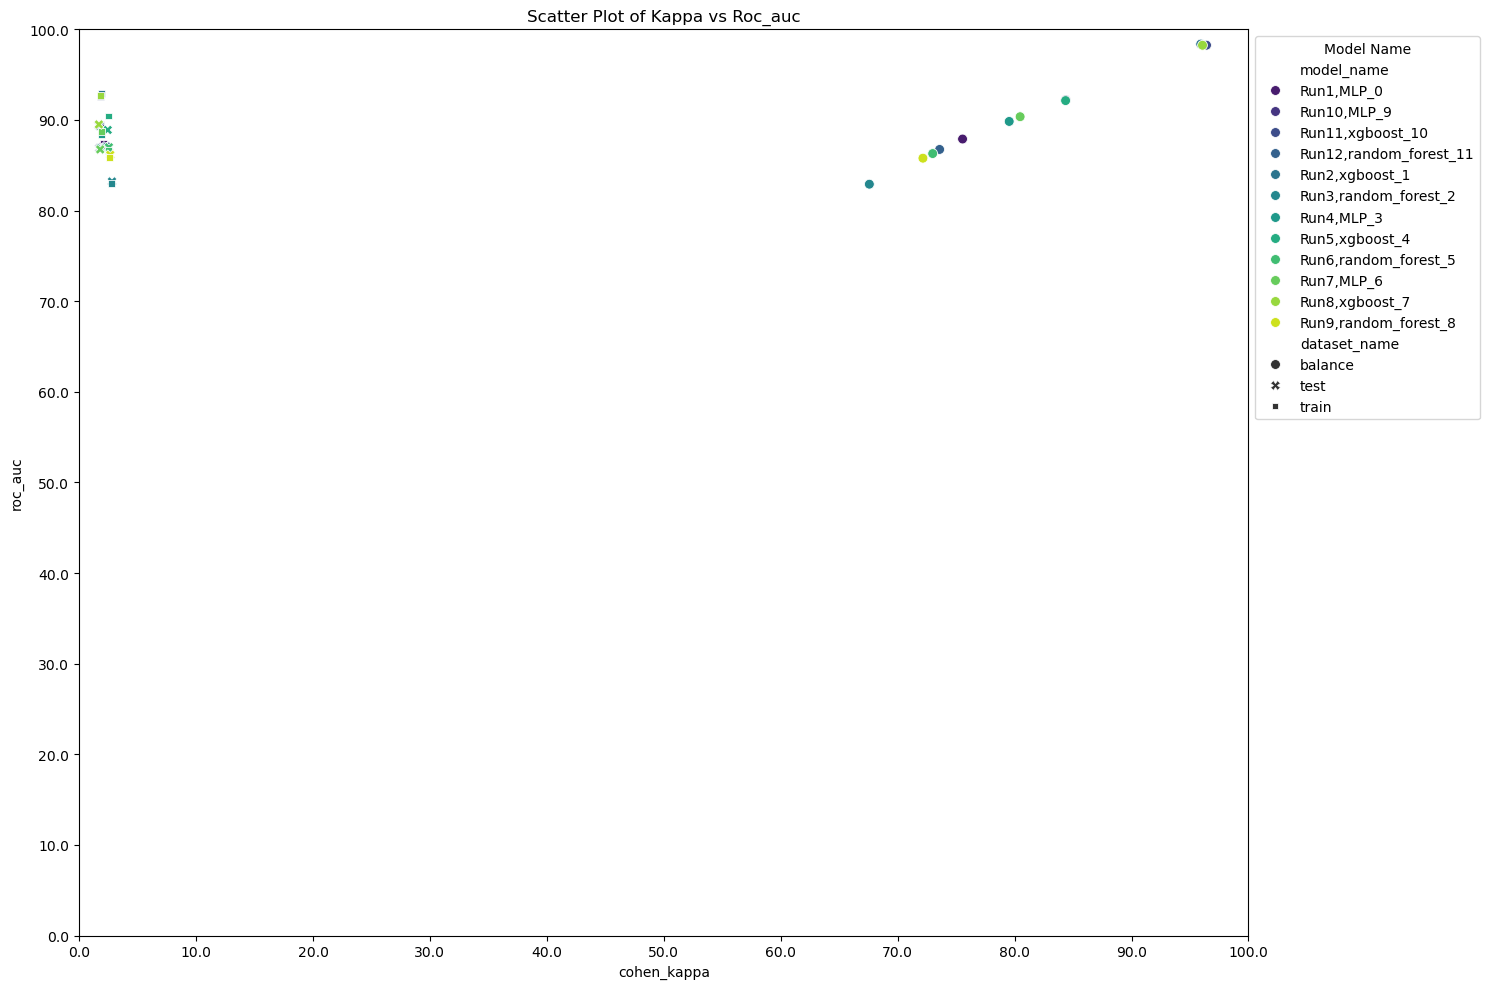

                    INFO     Graficos de desempeños en ['1', '1.0', 1, 1.0] calculadas sobre y         ]8;id=296934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py\nodes.py]8;;\:]8;id=422382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py#919\919]8;;\
                             f1-score                                                                              

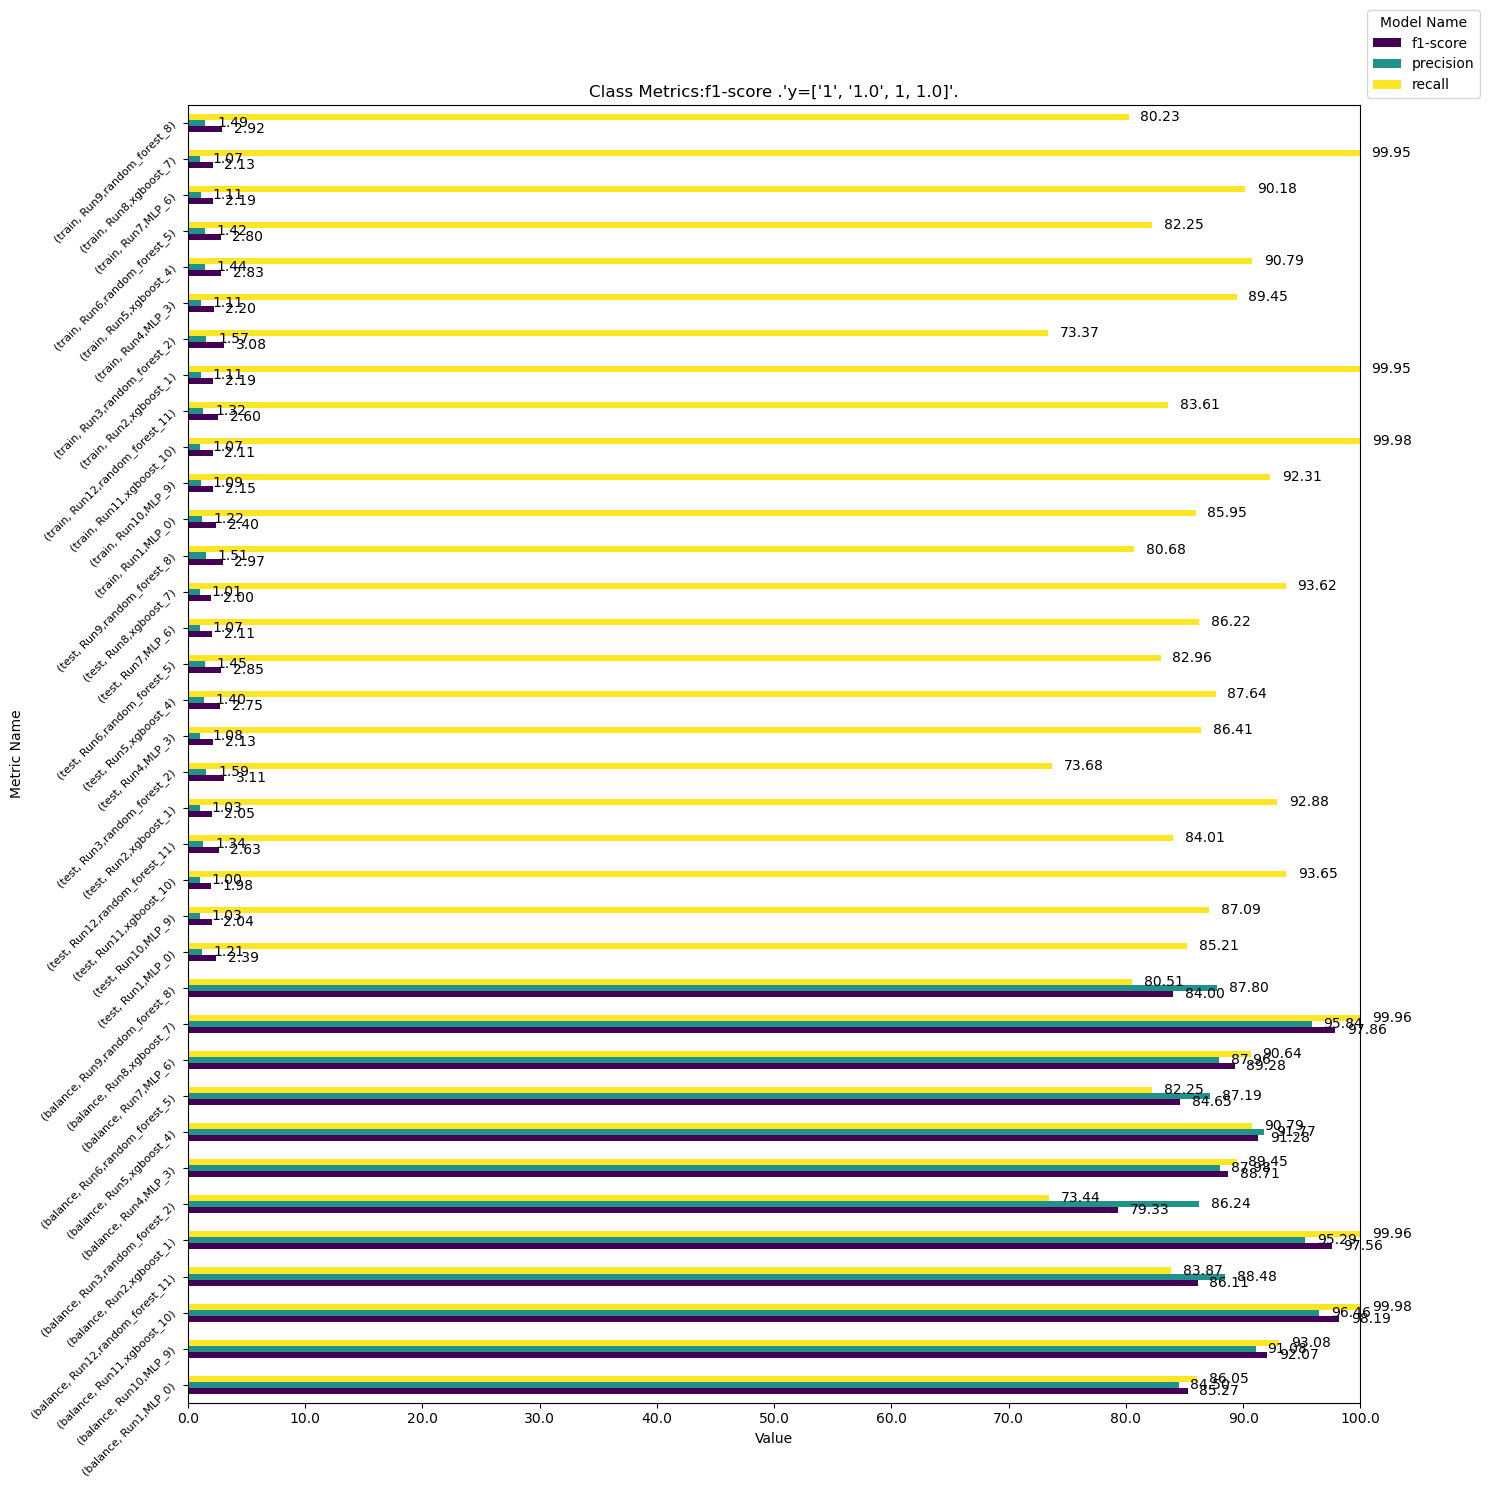

[12/19/24 13:27:50] INFO     Mejores algoritmos por metrica y dataset:                                 ]8;id=696664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py\nodes.py]8;;\:]8;id=223646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py#960\960]8;;\

model_name dataset_name metric_name   metric_type class_name  \
26  Run3,random_forest_2         test    f1-score  class metric        1.0   
24  Run3,random_forest_2         test   precision  class metric        1.0   
97      Run11,xgboost_10         test      recall  class metric        1.0   
23  Run3,random_forest_2        train    f1-score  class metric        1.0   
21  Run3,random_forest_2        train   precision  class metric        1.0   
94      Run11,xgboost_10        train      recall  class metric        1.0   

      value  
26   3.1103  
24   1.5887  
97  93.6518  
23   3.0759  
21   1.5709  
94  99.9846

                    INFO     Mejores algoritmos:                                                      ]8;id=494879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py\nodes.py]8;;\:]8;id=405146;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/models/nodes.py#1007\1007]8;;\

best_model_name   best_unbiased_model best_fitting_model
model_name   Run3,random_forest_2  Run3,random_forest_2         Run1,MLP_0
metric_name              f1-score              f1-score           f1-score
metric_type          class metric          class metric       class metric
class_name                    1.0                   1.0                1.0
test                       3.1103                3.1103             2.3905
balance                   79.3269               79.3269            85.2701
train                      3.0759                3.0759             2.3962
bias                      -76.251               -76.251           -82.8739
real_bias                    True                  True               True
test-train                 0.0344                0.0344            -0.0057
fitting              Underfitting          Underfitting        overfitting

In [11]:
# sin EDA
info_temp = models.compare_metrics_models(info_save_all,params)

In [12]:
pct = 0.70

In [ ]:
# con EDA
df = info_save_all['all_results']
df = df[df["metric_name"] == "f1-score"]
df = df[df["class_name"].isin(["1","1.0",1])]
df

In [ ]:
df_metrics_train = df[df['dataset_name']=='train'].sort_values(by ='value', ascending = False)
df_metrics_test = df[df['dataset_name']=='test'].sort_values(by ='value', ascending = False)
df_metrics_train = df_metrics_train.iloc[:int(df_metrics_train.shape[0]*pct)].sort_values(by = "value", ascending = False)
df_metrics_test = df_metrics_test.iloc[:int(df_metrics_test.shape[0]*pct)].sort_values(by = "value", ascending = False)

In [ ]:
ensamble = []
names = []
for model_name in df_metrics_test['model_name']:
    if model_name in df_metrics_train['model_name'].values:
        names.append(model_name)
        ensamble.append(int(model_name.split(",")[0][3:]))
ensambles = sorted(ensamble)
ensamble = ["Run"+str(i) for i in ensambles]
weightss = [1]*len(ensamble)
print(ensamble)
print(weightss)

In [ ]:
df_metrics_test[df_metrics_test['model_name'].isin(names)]

In [ ]:
df_metrics_train[df_metrics_train['model_name'].isin(names)]

In [ ]:
info_save_all['best_model_metrics_dataset']

In [13]:
# sin EDA
df = info_save_all['all_results']
df = df[df["metric_name"] == "f1-score"]
df = df[df["class_name"].isin(["1","1.0",1])]
df_metrics_train = df[df['dataset_name']=='train'].sort_values(by ='value', ascending = False)
df_metrics_test = df[df['dataset_name']=='test'].sort_values(by ='value', ascending = False)
df_metrics_train = df_metrics_train.iloc[:int(df_metrics_train.shape[0]*pct)].sort_values(by = "value", ascending = False)
df_metrics_test = df_metrics_test.iloc[:int(df_metrics_test.shape[0]*pct)].sort_values(by = "value", ascending = False)
ensamble = []
names = []
for model_name in df_metrics_test['model_name']:
    if model_name in df_metrics_train['model_name'].values:
        names.append(model_name)
        ensamble.append(int(model_name.split(",")[0][3:]))
ensambles = sorted(ensamble)
ensamble = ["Run"+str(i) for i in ensambles]
weightss = [1]*len(ensamble)
print(ensamble)
print(weightss)
display(df_metrics_test[df_metrics_test['model_name'].isin(names)])
display(df_metrics_train[df_metrics_train['model_name'].isin(names)])
info_save_all['best_model_metrics_dataset']

['Run1', 'Run3', 'Run4', 'Run5', 'Run6', 'Run9', 'Run12']
[1, 1, 1, 1, 1, 1, 1]


model_name dataset_name metric_name   metric_type class_name  \
16    Run3,random_forest_2         test    f1-score  class metric        1.0   
16    Run9,random_forest_8         test    f1-score  class metric        1.0   
16    Run6,random_forest_5         test    f1-score  class metric        1.0   
16          Run5,xgboost_4         test    f1-score  class metric        1.0   
16  Run12,random_forest_11         test    f1-score  class metric        1.0   
16              Run1,MLP_0         test    f1-score  class metric        1.0   
16              Run4,MLP_3         test    f1-score  class metric        1.0   

     value  
16  3.1103  
16  2.9653  
16  2.8493  
16  2.7504  
16  2.6346  
16  2.3905  
16  2.1308

model_name dataset_name metric_name   metric_type class_name  \
16    Run3,random_forest_2        train    f1-score  class metric        1.0   
16    Run9,random_forest_8        train    f1-score  class metric        1.0   
16          Run5,xgboost_4        train    f1-score  class metric        1.0   
16    Run6,random_forest_5        train    f1-score  class metric        1.0   
16  Run12,random_forest_11        train    f1-score  class metric        1.0   
16              Run1,MLP_0        train    f1-score  class metric        1.0   
16              Run4,MLP_3        train    f1-score  class metric        1.0   

     value  
16  3.0759  
16  2.9238  
16  2.8314  
16  2.8010  
16  2.6018  
16  2.3962  
16  2.1954

model_name dataset_name metric_name   metric_type class_name  \
26  Run3,random_forest_2         test    f1-score  class metric        1.0   
24  Run3,random_forest_2         test   precision  class metric        1.0   
97      Run11,xgboost_10         test      recall  class metric        1.0   
23  Run3,random_forest_2        train    f1-score  class metric        1.0   
21  Run3,random_forest_2        train   precision  class metric        1.0   
94      Run11,xgboost_10        train      recall  class metric        1.0   

      value  
26   3.1103  
24   1.5887  
97  93.6518  
23   3.0759  
21   1.5709  
94  99.9846

## model_selection

In [17]:
## algoritmo best_model_name unico:

In [ ]:
info_save_select_ini = catalog.load('info_save_select_best') # best model unico

In [ ]:
check_df = info_save_select_ini['select_model2']
check_df = check_df[np.in1d(check_df.index.get_level_values(1),['backtest'])].reset_index() 
check_df = check_df.set_index(['select_model','name_model','dataset_name','class_name']).sort_index()
check_df

In [ ]:
info_save_select_mvp2 = catalog.load('info_save_select_mvp2') # best model unico

In [ ]:
check_df_mvp2 = info_save_select_mvp2['select_model2']
check_df_mvp2 = check_df_mvp2[np.in1d(check_df_mvp2.index.get_level_values(1),['backtest'])].reset_index() 
check_df_mvp2 = check_df_mvp2.set_index(['select_model','name_model','dataset_name','class_name']).sort_index()
check_df_mvp2

In [14]:
params['Ensamble']['want'] = True
params['optimizacion_bayesiana']['want'] = False
params['Ensamble']['Algoritmos'] = ensamble
params['Ensamble']['weights'] = weightss

In [15]:
params['n_obs_filter']

0.3

In [16]:
params['use_key']

{'want': False, 'llave': ['Run10,xgboost_9'], 'estrategia': ['best_model_name']}

In [17]:
params['Ensamble']


{
    'want': True,
    'Algoritmos': ['Run1', 'Run3', 'Run4', 'Run5', 'Run6', 'Run9', 'Run12'],
    'weights': [1, 1, 1, 1, 1, 1, 1],
    'scorer': 'backtest_scorer'
}

In [18]:
info_save_temp=ms.generate_modelo_produccion(info_save_all, params)

[12/19/24 13:30:31] INFO     Iniciando el Ensamblado de modelos...                                     ]8;id=764528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=18560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#747\747]8;;\

                    INFO     train                                                                     ]8;id=177838;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=627228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#707\707]8;;\

                    INFO     Nodo 0, Run1                                                              ]8;id=759286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=750205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[12/19/24 13:30:34] INFO     Nodo 2, Run3                                                              ]8;id=600857;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=568316;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.5s remaining:    0.9s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.1s finished


[12/19/24 13:30:39] INFO     Nodo 3, Run4                                                              ]8;id=398633;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=884779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[12/19/24 13:30:47] INFO     Nodo 4, Run5                                                              ]8;id=262414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=852826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[12/19/24 13:30:48] INFO     Nodo 5, Run6                                                              ]8;id=485814;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=466051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.8s remaining:    1.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.5s finished


[12/19/24 13:30:53] INFO     Nodo 8, Run9                                                              ]8;id=622874;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=689377;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.7s remaining:    0.9s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.3s finished


[12/19/24 13:30:57] INFO     Nodo 11, Run12                                                            ]8;id=517479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=456246;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    9.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   18.7s
[Parallel(n_jobs=64)]: Done 900 out of 900 | elapsed:   24.5s finished


[12/19/24 13:31:25] INFO     test                                                                      ]8;id=754515;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=159401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#707\707]8;;\

                    INFO     Nodo 0, Run1                                                              ]8;id=741250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=999117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[12/19/24 13:31:26] INFO     Nodo 2, Run3                                                              ]8;id=548523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=251608;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.7s finished


[12/19/24 13:31:27] INFO     Nodo 3, Run4                                                              ]8;id=254963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=707750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[12/19/24 13:31:29] INFO     Nodo 4, Run5                                                              ]8;id=320745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=539121;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[12/19/24 13:31:30] INFO     Nodo 5, Run6                                                              ]8;id=264297;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=442334;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.9s finished


[12/19/24 13:31:31] INFO     Nodo 8, Run9                                                              ]8;id=880107;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=65702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.9s finished


[12/19/24 13:31:32] INFO     Nodo 11, Run12                                                            ]8;id=730545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=563459;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#660\660]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    2.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    4.7s
[Parallel(n_jobs=64)]: Done 900 out of 900 | elapsed:    6.2s finished


[12/19/24 13:31:49] INFO     Ok Forecast                                                               ]8;id=970865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=882810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#723\723]8;;\

                    INFO     Iniciando el calculo de las metricas...                                  ]8;id=730479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=150158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1073\1073]8;;\

                    INFO     Tipo de Threshold: KS                                                    ]8;id=273868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=234166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1079\1079]8;;\

                    INFO     Models: best_model_name                                                  ]8;id=46225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=186838;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1104\1104]8;;\

                    INFO     Estrategy: best_model_name                                               ]8;id=492719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=350009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1110\1110]8;;\

                    INFO     TOP N: 2449579                                                           ]8;id=215467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=851164;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1116\1116]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.5s remaining:    0.9s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.1s finished


[12/19/24 13:31:57] INFO     TOP N: 612394                                                            ]8;id=858743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=946399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1116\1116]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.8s finished


value name_model       model_name  \
class_name metric_name    dataset_name                                       
1          f1-score n_top test          0.9944       Run3  random_forest_2   
           true_sum n_top test            3060       Run3  random_forest_2   
           backtest       test          0.4997       Run3  random_forest_2   

                                           select_model  
class_name metric_name    dataset_name                   
1          f1-score n_top test          best_model_name  
           true_sum n_top test          best_model_name  
           backtest       test          best_model_name

[12/19/24 13:31:58] INFO     Models: best_unbiased_model                                              ]8;id=31991;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=104458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1104\1104]8;;\

                    INFO     Estrategy: best_unbiased_model                                           ]8;id=277561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=530863;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1110\1110]8;;\

                    INFO     TOP N: 2449579                                                           ]8;id=867118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=319241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1116\1116]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.5s remaining:    0.9s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.1s finished


[12/19/24 13:32:06] INFO     TOP N: 612394                                                            ]8;id=664912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=316012;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1116\1116]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.8s finished


value name_model       model_name  \
class_name metric_name    dataset_name                                       
1          f1-score n_top test          0.9944       Run3  random_forest_2   
           true_sum n_top test            3060       Run3  random_forest_2   
           backtest       test          0.4997       Run3  random_forest_2   

                                               select_model  
class_name metric_name    dataset_name                       
1          f1-score n_top test          best_unbiased_model  
           true_sum n_top test          best_unbiased_model  
           backtest       test          best_unbiased_model

[12/19/24 13:32:08] INFO     Models: best_fitting_model                                               ]8;id=338573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=255474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1104\1104]8;;\

                    INFO     Estrategy: best_fitting_model                                            ]8;id=456888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=916307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1110\1110]8;;\

                    INFO     TOP N: 2449579                                                           ]8;id=503951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=319132;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1116\1116]8;;\

[12/19/24 13:32:13] INFO     TOP N: 612394                                                            ]8;id=722254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=177529;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1116\1116]8;;\

value name_model model_name  \
class_name metric_name    dataset_name                                 
1          f1-score n_top test          1.0012       Run1      MLP_0   
           true_sum n_top test            3081       Run1      MLP_0   
           backtest       test          0.5031       Run1      MLP_0   

                                              select_model  
class_name metric_name    dataset_name                      
1          f1-score n_top test          best_fitting_model  
           true_sum n_top test          best_fitting_model  
           backtest       test          best_fitting_model

[12/19/24 13:32:15] INFO     Estrategy: modelo_produccion                                             ]8;id=276853;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=443545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1110\1110]8;;\

                    INFO     TOP N: 2449579                                                           ]8;id=807729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=829331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1116\1116]8;;\

[12/19/24 13:32:19] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=418274;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=852846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=927039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=182225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85,    ]8;id=487408;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=884412;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             84, 83]                                                                               

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=891778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=704613;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=761298;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=877678;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=980063;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=304476;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=723224;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=630627;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=512901;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=162270;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=725175;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=848805;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=46363;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=720549;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=224605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=726612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.5s remaining:    0.9s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.1s finished


[12/19/24 13:32:24] INFO     Try Segment Dist Probs: 90                                               ]8;id=924658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=395882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1150\1150]8;;\

[12/19/24 13:32:25] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=387843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=23716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=807364;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=513494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [89, 88, 87, 86, 85, 84, 83, 82, 81, 80,    ]8;id=453207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=808002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             78]                                                                                   

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=259538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=676387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=566000;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=508177;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=345619;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=952824;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=95462;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=955962;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=510365;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=519940;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=974933;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=439905;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=176849;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=272657;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=626660;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=743985;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=646842;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=737197;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=440541;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=761788;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=908331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=269624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[12/19/24 13:32:35] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=970794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=20468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=38621;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=442272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85,    ]8;id=297065;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=551916;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             84, 83]                                                                               

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=298528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=97964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=684590;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=404453;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=176167;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=511488;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=227463;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=911093;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=346410;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=415829;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=878522;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=157;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=394366;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=429316;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[12/19/24 13:32:37] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=775964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=438718;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=527841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=701696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85]    ]8;id=178383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=238125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=149409;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=707290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=466110;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=719818;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=125502;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=326852;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=457705;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=140378;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=804572;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=870076;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=381021;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=953906;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=238340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=336518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.9s remaining:    1.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.5s finished


[12/19/24 13:32:43] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=333456;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=658973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=157381;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=872023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85]    ]8;id=232755;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=40645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=213876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=952364;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=535464;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=499301;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=831037;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=43155;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=709998;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=985204;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=784094;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=812195;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=210731;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=170117;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=796051;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=798918;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=478706;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=827304;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=543335;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=690864;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=854567;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=100323;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=45205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=173083;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.7s remaining:    1.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.3s finished


[12/19/24 13:32:49] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=443373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=618751;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=789875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=168877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85,    ]8;id=460866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=327899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             84]                                                                                   

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=478353;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=200467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=441076;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=993972;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=828593;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=228542;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=581333;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=465600;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=729003;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=602708;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=665556;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=199504;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=526513;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=978840;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=80656;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=625802;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=270784;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=578147;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=225463;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=822328;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=915570;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=136013;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=156124;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=245614;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    9.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   18.8s
[Parallel(n_jobs=64)]: Done 900 out of 900 | elapsed:   24.6s finished


[12/19/24 13:33:16] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=108734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=727265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=953714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=418958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85,    ]8;id=953429;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=566101;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             84]                                                                                   

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=71478;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=613736;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=52807;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=224244;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=694439;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=614372;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=474024;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=808877;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=226048;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=217215;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=576296;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=904613;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=391006;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=879140;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=660297;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=134230;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=578163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=805707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

                    INFO     Tipo de Threshold: KS                                                     ]8;id=415803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=711788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#295\295]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=258592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=562877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: MLP_0,Run1. Weight: 1                                             ]8;id=413060;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=308383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[12/19/24 13:33:20] INFO     Update probs: Selected: 0, Target Select: 2449579, Diff %: -1.0           ]8;id=950385;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=960331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

[12/19/24 13:33:22] INFO     Update probs: Selected: 85919, Target Select: 2449579, Diff %:            ]8;id=56006;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=282012;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9649249932335312                                                                   

[12/19/24 13:33:23] INFO     Update probs: Selected: 171940, Target Select: 2449579, Diff %:           ]8;id=510133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=221590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9298083466587523                                                                   

[12/19/24 13:33:25] INFO     Update probs: Selected: 258029, Target Select: 2449579, Diff %:           ]8;id=151054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=99703;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.894663940211767                                                                    

[12/19/24 13:33:26] INFO     Update probs: Selected: 343696, Target Select: 2449579, Diff %:           ]8;id=546977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=700946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8596918082658286                                                                   

[12/19/24 13:33:28] INFO     Update probs: Selected: 429687, Target Select: 2449579, Diff %:           ]8;id=668581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=945501;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8245874086934939                                                                   

[12/19/24 13:33:29] INFO     Update probs: Selected: 515564, Target Select: 2449579, Diff %:           ]8;id=28705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=948176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7895295477304467                                                                   

[12/19/24 13:33:30] INFO     Update probs: Selected: 601591, Target Select: 2449579, Diff %:           ]8;id=884302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=578923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7544104517551792                                                                   

[12/19/24 13:33:32] INFO     Update probs: Selected: 687498, Target Select: 2449579, Diff %:           ]8;id=771392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=227006;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7193403437896879                                                                   

[12/19/24 13:33:33] INFO     Update probs: Selected: 773544, Target Select: 2449579, Diff %:           ]8;id=461208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=94783;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6842134913795391                                                                   

[12/19/24 13:33:35] INFO     Update probs: Selected: 859585, Target Select: 2449579, Diff %:           ]8;id=317423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=996859;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6490886801364643                                                                   

[12/19/24 13:33:36] INFO     Update probs: Selected: 945491, Target Select: 2449579, Diff %:           ]8;id=388430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=303096;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6140189804043878                                                                   

[12/19/24 13:33:38] INFO     Update probs: Selected: 1031399, Target Select: 2449579, Diff %:          ]8;id=57368;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=370523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5789484642054818                                                                   

[12/19/24 13:33:39] INFO     Update probs: Selected: 1117249, Target Select: 2449579, Diff %:          ]8;id=851850;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=175694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5439016255446344                                                                   

[12/19/24 13:33:41] INFO     Update probs: Selected: 1203223, Target Select: 2449579, Diff %:          ]8;id=955631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=745705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5088041659403514                                                                   

[12/19/24 13:33:42] INFO     Update probs: Selected: 1289501, Target Select: 2449579, Diff %:          ]8;id=454881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=543990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4735826033779682                                                                   

[12/19/24 13:33:43] INFO     Update probs: Selected: 1375342, Target Select: 2449579, Diff %:          ]8;id=161140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=182826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.438539438817854                                                                    

[12/19/24 13:33:45] INFO     Update probs: Selected: 1461345, Target Select: 2449579, Diff %:          ]8;id=196973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=707266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4034301404445417                                                                   

[12/19/24 13:33:46] INFO     Update probs: Selected: 1547066, Target Select: 2449579, Diff %:          ]8;id=775415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=421692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.36843596389420386                                                                  

[12/19/24 13:33:48] INFO     Update probs: Selected: 1632304, Target Select: 2449579, Diff %:          ]8;id=788415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=673882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3336389640832159                                                                   

[12/19/24 13:33:49] INFO     Update probs: Selected: 1718972, Target Select: 2449579, Diff %:          ]8;id=301187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=301430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.29825819048905955                                                                  

[12/19/24 13:33:51] INFO     Update probs: Selected: 1804839, Target Select: 2449579, Diff %:          ]8;id=226624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=571852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.26320441186016047                                                                  

[12/19/24 13:33:52] INFO     Update probs: Selected: 1890861, Target Select: 2449579, Diff %:          ]8;id=733127;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=184982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2280873570519669                                                                   

[12/19/24 13:33:54] INFO     Update probs: Selected: 2062575, Target Select: 2449579, Diff %:          ]8;id=662329;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=757618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.15798796446246477                                                                  

[12/19/24 13:33:55] INFO     Update probs: Selected: 2234689, Target Select: 2449579, Diff %:          ]8;id=132599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=984213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08772527850704141                                                                  

[12/19/24 13:33:56] INFO     Update probs: Selected: 2408081, Target Select: 2449579, Diff %:          ]8;id=304298;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=933557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.016940870247499674                                                                 

[12/19/24 13:33:58] INFO     Update probs: Selected: 2449579, Target Select: 2449579, Diff %: 0.0      ]8;id=244178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=862461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=849478;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=519730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=929461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=464909;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: random_forest_2,Run3. Weight: 1                                   ]8;id=158625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=671786;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.6s remaining:    0.9s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.2s finished


[12/19/24 13:34:03] INFO     Update probs: Selected: 0, Target Select: 2449579, Diff %: -1.0           ]8;id=451142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=705925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

[12/19/24 13:34:04] INFO     Update probs: Selected: 91069, Target Select: 2449579, Diff %:            ]8;id=955967;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=46898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9628225911472951                                                                   

[12/19/24 13:34:06] INFO     Update probs: Selected: 186478, Target Select: 2449579, Diff %:           ]8;id=26333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=320049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9238734492743447                                                                   

[12/19/24 13:34:07] INFO     Update probs: Selected: 271420, Target Select: 2449579, Diff %:           ]8;id=254077;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=435095;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8891972865541384                                                                   

[12/19/24 13:34:09] INFO     Update probs: Selected: 362205, Target Select: 2449579, Diff %:           ]8;id=465069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=885923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8521358159912377                                                                   

[12/19/24 13:34:10] INFO     Update probs: Selected: 453561, Target Select: 2449579, Diff %:           ]8;id=712557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=849750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8148412441484842                                                                   

[12/19/24 13:34:12] INFO     Update probs: Selected: 544344, Target Select: 2449579, Diff %:           ]8;id=227085;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=85805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7777805900524131                                                                   

[12/19/24 13:34:13] INFO     Update probs: Selected: 635050, Target Select: 2449579, Diff %:           ]8;id=998886;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=817642;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7407513699292817                                                                   

[12/19/24 13:34:15] INFO     Update probs: Selected: 725859, Target Select: 2449579, Diff %:           ]8;id=425980;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=814528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7036801017644256                                                                   

[12/19/24 13:34:16] INFO     Update probs: Selected: 816474, Target Select: 2449579, Diff %:           ]8;id=848041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=698248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6666880308820413                                                                   

[12/19/24 13:34:17] INFO     Update probs: Selected: 997863, Target Select: 2449579, Diff %:           ]8;id=633027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=263139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5926389800043191                                                                   

[12/19/24 13:34:19] INFO     Update probs: Selected: 1088321, Target Select: 2449579, Diff %:          ]8;id=156228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=658518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5557110017680589                                                                   

[12/19/24 13:34:20] INFO     Update probs: Selected: 1179406, Target Select: 2449579, Diff %:          ]8;id=704725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=534519;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5185270611807172                                                                   

[12/19/24 13:34:22] INFO     Update probs: Selected: 1270194, Target Select: 2449579, Diff %:          ]8;id=550428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=774008;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.48146436591757197                                                                  

[12/19/24 13:34:23] INFO     Update probs: Selected: 1360460, Target Select: 2449579, Diff %:          ]8;id=706573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=310954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.44461476849695397                                                                  

[12/19/24 13:34:25] INFO     Update probs: Selected: 1450382, Target Select: 2449579, Diff %:          ]8;id=961277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=202673;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40790560337102827                                                                  

[12/19/24 13:34:26] INFO     Update probs: Selected: 1541648, Target Select: 2449579, Diff %:          ]8;id=233695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=160350;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.37064777253560716                                                                  

[12/19/24 13:34:28] INFO     Update probs: Selected: 1723514, Target Select: 2449579, Diff %:          ]8;id=445093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=969199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2964039943190238                                                                   

[12/19/24 13:34:29] INFO     Update probs: Selected: 1905475, Target Select: 2449579, Diff %:          ]8;id=453019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=83422;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.22212143392803416                                                                  

[12/19/24 13:34:30] INFO     Update probs: Selected: 1995869, Target Select: 2449579, Diff %:          ]8;id=60122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=998934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.18521958263032137                                                                  

[12/19/24 13:34:32] INFO     Update probs: Selected: 2176803, Target Select: 2449579, Diff %:          ]8;id=440380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=116220;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.11135627795633454                                                                  

[12/19/24 13:34:33] INFO     Update probs: Selected: 2268239, Target Select: 2449579, Diff %:          ]8;id=662020;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=665469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.0740290474403969                                                                   

[12/19/24 13:34:35] INFO     Update probs: Selected: 2449579, Target Select: 2449579, Diff %: 0.0      ]8;id=780872;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=370713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=311716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=868410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=324897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=846231;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: MLP_3,Run4. Weight: 1                                             ]8;id=156760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=596701;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[12/19/24 13:34:44] INFO     Update probs: Selected: 0, Target Select: 2449579, Diff %: -1.0           ]8;id=17392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=863106;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

[12/19/24 13:34:46] INFO     Update probs: Selected: 85904, Target Select: 2449579, Diff %:            ]8;id=895653;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=498178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9649311167347532                                                                   

[12/19/24 13:34:47] INFO     Update probs: Selected: 171818, Target Select: 2449579, Diff %:           ]8;id=712748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=985464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9298581511353584                                                                   

[12/19/24 13:34:49] INFO     Update probs: Selected: 257965, Target Select: 2449579, Diff %:           ]8;id=42716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=591465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8946900671503144                                                                   

[12/19/24 13:34:50] INFO     Update probs: Selected: 343795, Target Select: 2449579, Diff %:           ]8;id=6881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=439759;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8596513931577631                                                                   

[12/19/24 13:34:52] INFO     Update probs: Selected: 429747, Target Select: 2449579, Diff %:           ]8;id=8792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=487984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8245629146886057                                                                   

[12/19/24 13:34:53] INFO     Update probs: Selected: 515754, Target Select: 2449579, Diff %:           ]8;id=943965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=980205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894519833816341                                                                   

[12/19/24 13:34:54] INFO     Update probs: Selected: 601646, Target Select: 2449579, Diff %:           ]8;id=35378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=337948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.754387998917365                                                                    

[12/19/24 13:34:56] INFO     Update probs: Selected: 687299, Target Select: 2449579, Diff %:           ]8;id=418939;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=665134;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7194215822392338                                                                   

[12/19/24 13:34:57] INFO     Update probs: Selected: 773600, Target Select: 2449579, Diff %:           ]8;id=615499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=720878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6841906303083102                                                                   

[12/19/24 13:34:59] INFO     Update probs: Selected: 859467, Target Select: 2449579, Diff %:           ]8;id=132075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=644009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.649136851679411                                                                    

[12/19/24 13:35:00] INFO     Update probs: Selected: 945454, Target Select: 2449579, Diff %:           ]8;id=756457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=564990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6140340850407355                                                                   

[12/19/24 13:35:02] INFO     Update probs: Selected: 1031441, Target Select: 2449579, Diff %:          ]8;id=457767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=876401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5789313184020601                                                                   

[12/19/24 13:35:03] INFO     Update probs: Selected: 1117302, Target Select: 2449579, Diff %:          ]8;id=722049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=874771;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5438799891736499                                                                   

[12/19/24 13:35:04] INFO     Update probs: Selected: 1203257, Target Select: 2449579, Diff %:          ]8;id=481232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=274498;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.508790286004248                                                                    

[12/19/24 13:35:06] INFO     Update probs: Selected: 1289364, Target Select: 2449579, Diff %:          ]8;id=552855;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=540145;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.47363853135579626                                                                  

[12/19/24 13:35:07] INFO     Update probs: Selected: 1375185, Target Select: 2449579, Diff %:          ]8;id=472786;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=817687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.43860353146397807                                                                  

[12/19/24 13:35:09] INFO     Update probs: Selected: 1461269, Target Select: 2449579, Diff %:          ]8;id=627960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=819628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40346116618406674                                                                  

[12/19/24 13:35:10] INFO     Update probs: Selected: 1547156, Target Select: 2449579, Diff %:          ]8;id=643096;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=793188;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3683992228868716                                                                   

[12/19/24 13:35:12] INFO     Update probs: Selected: 1632924, Target Select: 2449579, Diff %:          ]8;id=930038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=578978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.333385859366038                                                                    

[12/19/24 13:35:13] INFO     Update probs: Selected: 1719260, Target Select: 2449579, Diff %:          ]8;id=397549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=598921;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.29814061926559626                                                                  

[12/19/24 13:35:14] INFO     Update probs: Selected: 1805143, Target Select: 2449579, Diff %:          ]8;id=592193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=160679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2630803089020603                                                                   

[12/19/24 13:35:16] INFO     Update probs: Selected: 1891435, Target Select: 2449579, Diff %:          ]8;id=196489;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=492851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2278530310718699                                                                   

[12/19/24 13:35:17] INFO     Update probs: Selected: 1974576, Target Select: 2449579, Diff %:          ]8;id=101852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=116367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.1939120967317241                                                                   

[12/19/24 13:35:19] INFO     Update probs: Selected: 2149844, Target Select: 2449579, Diff %:          ]8;id=914031;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=352450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.12236184258601172                                                                  

[12/19/24 13:35:20] INFO     Update probs: Selected: 2234891, Target Select: 2449579, Diff %:          ]8;id=817154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=429617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08764281535725119                                                                  

[12/19/24 13:35:22] INFO     Update probs: Selected: 2320553, Target Select: 2449579, Diff %:          ]8;id=149990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=345524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.05267272457838674                                                                  

[12/19/24 13:35:23] INFO     Update probs: Selected: 2406792, Target Select: 2449579, Diff %:          ]8;id=137803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=941246;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.01746708311918089                                                                  

[12/19/24 13:35:25] INFO     Update probs: Selected: 2449579, Target Select: 2449579, Diff %: 0.0      ]8;id=595747;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=530947;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=59273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=29916;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=933110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=996626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: xgboost_4,Run5. Weight: 1                                         ]8;id=792627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=681688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[12/19/24 13:35:26] INFO     Update probs: Selected: 0, Target Select: 2449579, Diff %: -1.0           ]8;id=217791;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=805089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

[12/19/24 13:35:28] INFO     Update probs: Selected: 85819, Target Select: 2449579, Diff %:            ]8;id=224815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=971576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9649658165750115                                                                   

[12/19/24 13:35:29] INFO     Update probs: Selected: 171898, Target Select: 2449579, Diff %:           ]8;id=417686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=56568;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9298254924621742                                                                   

[12/19/24 13:35:31] INFO     Update probs: Selected: 257702, Target Select: 2449579, Diff %:           ]8;id=847295;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=297931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8947974325384076                                                                   

[12/19/24 13:35:32] INFO     Update probs: Selected: 343710, Target Select: 2449579, Diff %:           ]8;id=458991;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=243893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8596860929980213                                                                   

[12/19/24 13:35:33] INFO     Update probs: Selected: 429769, Target Select: 2449579, Diff %:           ]8;id=724502;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=859177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8245539335534801                                                                   

[12/19/24 13:35:35] INFO     Update probs: Selected: 515685, Target Select: 2449579, Diff %:           ]8;id=748815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=496944;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894801514872556                                                                   

[12/19/24 13:35:36] INFO     Update probs: Selected: 601645, Target Select: 2449579, Diff %:           ]8;id=422980;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=208492;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7543884071507798                                                                   

[12/19/24 13:35:37] INFO     Update probs: Selected: 687589, Target Select: 2449579, Diff %:           ]8;id=212883;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=801426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7193031945489409                                                                   

[12/19/24 13:35:39] INFO     Update probs: Selected: 773625, Target Select: 2449579, Diff %:           ]8;id=597739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=408865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.68418042447294                                                                     

[12/19/24 13:35:40] INFO     Update probs: Selected: 945398, Target Select: 2449579, Diff %:           ]8;id=292265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=808724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6140569461119646                                                                   

[12/19/24 13:35:42] INFO     Update probs: Selected: 1031398, Target Select: 2449579, Diff %:          ]8;id=516182;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=13;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5789488724388966                                                                   

[12/19/24 13:35:43] INFO     Update probs: Selected: 1117401, Target Select: 2449579, Diff %:          ]8;id=976967;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=323868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5438395740655844                                                                   

[12/19/24 13:35:44] INFO     Update probs: Selected: 1203318, Target Select: 2449579, Diff %:          ]8;id=273204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=584506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.508765383765945                                                                    

[12/19/24 13:35:46] INFO     Update probs: Selected: 1289379, Target Select: 2449579, Diff %:          ]8;id=306576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=868115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.47363240785457417                                                                  

[12/19/24 13:35:47] INFO     Update probs: Selected: 1375304, Target Select: 2449579, Diff %:          ]8;id=184662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=65255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.43855495168761655                                                                  

[12/19/24 13:35:49] INFO     Update probs: Selected: 1461353, Target Select: 2449579, Diff %:          ]8;id=933096;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=700492;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40342687457722326                                                                  

[12/19/24 13:35:50] INFO     Update probs: Selected: 1546904, Target Select: 2449579, Diff %:          ]8;id=584514;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=554022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.36850209770740194                                                                  

[12/19/24 13:35:51] INFO     Update probs: Selected: 1719007, Target Select: 2449579, Diff %:          ]8;id=349095;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=933503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.29824390231954145                                                                  

[12/19/24 13:35:53] INFO     Update probs: Selected: 1805234, Target Select: 2449579, Diff %:          ]8;id=40604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=808624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.26304315966131325                                                                  

[12/19/24 13:35:54] INFO     Update probs: Selected: 1977341, Target Select: 2449579, Diff %:          ]8;id=92301;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=685600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.1927833313397935                                                                   

[12/19/24 13:35:56] INFO     Update probs: Selected: 2062788, Target Select: 2449579, Diff %:          ]8;id=530255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=669379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.1579010107451117                                                                   

[12/19/24 13:35:57] INFO     Update probs: Selected: 2148504, Target Select: 2449579, Diff %:          ]8;id=104689;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=999911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.1229088753618479                                                                   

[12/19/24 13:35:58] INFO     Update probs: Selected: 2406720, Target Select: 2449579, Diff %:          ]8;id=848016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=635929;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.017496475925046714                                                                 

[12/19/24 13:36:00] INFO     Update probs: Selected: 2449579, Target Select: 2449579, Diff %: 0.0      ]8;id=26388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=888925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=841233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=317375;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=351680;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=719133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: random_forest_5,Run6. Weight: 1                                   ]8;id=647087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=97283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.9s remaining:    1.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.6s finished


[12/19/24 13:36:06] INFO     Update probs: Selected: 0, Target Select: 2449579, Diff %: -1.0           ]8;id=547717;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=954911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

[12/19/24 13:36:07] INFO     Update probs: Selected: 86192, Target Select: 2449579, Diff %:            ]8;id=761310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=402195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.96481354551129                                                                     

[12/19/24 13:36:09] INFO     Update probs: Selected: 171685, Target Select: 2449579, Diff %:           ]8;id=528209;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=195094;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9299124461795272                                                                   

[12/19/24 13:36:10] INFO     Update probs: Selected: 257825, Target Select: 2449579, Diff %:           ]8;id=101668;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=363356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8947472198283868                                                                   

[12/19/24 13:36:11] INFO     Update probs: Selected: 343902, Target Select: 2449579, Diff %:           ]8;id=789760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=611097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8596077121823791                                                                   

[12/19/24 13:36:13] INFO     Update probs: Selected: 429361, Target Select: 2449579, Diff %:           ]8;id=307456;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=752202;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8247204927867197                                                                   

[12/19/24 13:36:14] INFO     Update probs: Selected: 515687, Target Select: 2449579, Diff %:           ]8;id=622414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=487053;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.789479335020426                                                                    

[12/19/24 13:36:16] INFO     Update probs: Selected: 601675, Target Select: 2449579, Diff %:           ]8;id=363711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=768381;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7543761601483356                                                                   

[12/19/24 13:36:17] INFO     Update probs: Selected: 687698, Target Select: 2449579, Diff %:           ]8;id=458744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=604902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7192586971067273                                                                   

[12/19/24 13:36:19] INFO     Update probs: Selected: 773595, Target Select: 2449579, Diff %:           ]8;id=426317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=601415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6841926714753841                                                                   

[12/19/24 13:36:20] INFO     Update probs: Selected: 859610, Target Select: 2449579, Diff %:           ]8;id=948427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=670973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6490784743010942                                                                   

[12/19/24 13:36:22] INFO     Update probs: Selected: 945664, Target Select: 2449579, Diff %:           ]8;id=559296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=989605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.613948356023627                                                                    

[12/19/24 13:36:23] INFO     Update probs: Selected: 1117336, Target Select: 2449579, Diff %:          ]8;id=768915;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=335957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5438661092375465                                                                   

[12/19/24 13:36:25] INFO     Update probs: Selected: 1289184, Target Select: 2449579, Diff %:          ]8;id=675815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=232349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4737120133704608                                                                   

[12/19/24 13:36:26] INFO     Update probs: Selected: 1374752, Target Select: 2449579, Diff %:          ]8;id=544554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=60982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4387802965325878                                                                   

[12/19/24 13:36:27] INFO     Update probs: Selected: 1461186, Target Select: 2449579, Diff %:          ]8;id=272307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=861733;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4034950495574954                                                                   

[12/19/24 13:36:29] INFO     Update probs: Selected: 1547422, Target Select: 2449579, Diff %:          ]8;id=839695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=901191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.36829063279853397                                                                  

[12/19/24 13:36:30] INFO     Update probs: Selected: 1634468, Target Select: 2449579, Diff %:          ]8;id=560727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=939347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.332755546973582                                                                    

[12/19/24 13:36:32] INFO     Update probs: Selected: 1804735, Target Select: 2449579, Diff %:          ]8;id=354780;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=206727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.26324686813529996                                                                  

[12/19/24 13:36:33] INFO     Update probs: Selected: 1977296, Target Select: 2449579, Diff %:          ]8;id=669456;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=65664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.19280170184345963                                                                  

[12/19/24 13:36:35] INFO     Update probs: Selected: 2062695, Target Select: 2449579, Diff %:          ]8;id=686804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=478818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.1579389764526884                                                                   

[12/19/24 13:36:36] INFO     Update probs: Selected: 2148465, Target Select: 2449579, Diff %:          ]8;id=353729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=516149;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.12292479646502522                                                                  

[12/19/24 13:36:38] INFO     Update probs: Selected: 2234261, Target Select: 2449579, Diff %:          ]8;id=515416;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=217154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08790000240857715                                                                  

[12/19/24 13:36:39] INFO     Update probs: Selected: 2320835, Target Select: 2449579, Diff %:          ]8;id=786052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=711741;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.052557602755412255                                                                 

[12/19/24 13:36:41] INFO     Update probs: Selected: 2406833, Target Select: 2449579, Diff %:          ]8;id=546032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=424603;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.01745034554917396                                                                  

[12/19/24 13:36:42] INFO     Update probs: Selected: 2449579, Target Select: 2449579, Diff %: 0.0      ]8;id=789676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=64148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=736887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=282670;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

[12/19/24 13:36:43] INFO     ------------------------------------------------------                    ]8;id=957032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=219903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: random_forest_8,Run9. Weight: 1                                   ]8;id=639073;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=797449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.7s remaining:    1.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.3s finished


[12/19/24 13:36:48] INFO     Update probs: Selected: 0, Target Select: 2449579, Diff %: -1.0           ]8;id=502825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=652810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

[12/19/24 13:36:49] INFO     Update probs: Selected: 85920, Target Select: 2449579, Diff %:            ]8;id=378430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=821848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9649245850001164                                                                   

[12/19/24 13:36:51] INFO     Update probs: Selected: 171669, Target Select: 2449579, Diff %:           ]8;id=868569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=289330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.929918977914164                                                                    

[12/19/24 13:36:52] INFO     Update probs: Selected: 258149, Target Select: 2449579, Diff %:           ]8;id=28556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=737849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8946149522019906                                                                   

[12/19/24 13:36:54] INFO     Update probs: Selected: 343779, Target Select: 2449579, Diff %:           ]8;id=903597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=161462;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8596579248923999                                                                   

[12/19/24 13:36:55] INFO     Update probs: Selected: 430057, Target Select: 2449579, Diff %:           ]8;id=481154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=960646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8244363623300167                                                                   

[12/19/24 13:36:57] INFO     Update probs: Selected: 515613, Target Select: 2449579, Diff %:           ]8;id=571452;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=392890;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7895095442931214                                                                   

[12/19/24 13:36:58] INFO     Update probs: Selected: 603139, Target Select: 2449579, Diff %:           ]8;id=179991;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=984044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.753778506429064                                                                    

[12/19/24 13:37:00] INFO     Update probs: Selected: 687666, Target Select: 2449579, Diff %:           ]8;id=292247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=632888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7192717605760011                                                                   

[12/19/24 13:37:01] INFO     Update probs: Selected: 772991, Target Select: 2449579, Diff %:           ]8;id=253711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=712331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6844392444579253                                                                   

[12/19/24 13:37:03] INFO     Update probs: Selected: 859468, Target Select: 2449579, Diff %:           ]8;id=159943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=133641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6491364434459962                                                                   

[12/19/24 13:37:04] INFO     Update probs: Selected: 1031096, Target Select: 2449579, Diff %:          ]8;id=782554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=776727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5790721589301672                                                                   

[12/19/24 13:37:05] INFO     Update probs: Selected: 1117203, Target Select: 2449579, Diff %:          ]8;id=152963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=779081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5439204042817154                                                                   

[12/19/24 13:37:07] INFO     Update probs: Selected: 1289335, Target Select: 2449579, Diff %:          ]8;id=902377;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=699038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4736503701248255                                                                   

[12/19/24 13:37:08] INFO     Update probs: Selected: 1461180, Target Select: 2449579, Diff %:          ]8;id=17112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=500463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4034974989579842                                                                   

[12/19/24 13:37:10] INFO     Update probs: Selected: 1547262, Target Select: 2449579, Diff %:          ]8;id=580178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=346963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.36835595014490247                                                                  

[12/19/24 13:37:11] INFO     Update probs: Selected: 1632918, Target Select: 2449579, Diff %:          ]8;id=992467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=857052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3333883087665268                                                                   

[12/19/24 13:37:13] INFO     Update probs: Selected: 1719521, Target Select: 2449579, Diff %:          ]8;id=342494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=433090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.29803407034433266                                                                  

[12/19/24 13:37:14] INFO     Update probs: Selected: 1805156, Target Select: 2449579, Diff %:          ]8;id=255960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=765885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.26307500186766786                                                                  

[12/19/24 13:37:16] INFO     Update probs: Selected: 1976512, Target Select: 2449579, Diff %:          ]8;id=192959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=964281;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.19312175684066527                                                                  

[12/19/24 13:37:17] INFO     Update probs: Selected: 2061847, Target Select: 2449579, Diff %:          ]8;id=668595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=566470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.15828515838844145                                                                  

[12/19/24 13:37:19] INFO     Update probs: Selected: 2234319, Target Select: 2449579, Diff %:          ]8;id=321568;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=248342;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08787632487051857                                                                  

[12/19/24 13:37:20] INFO     Update probs: Selected: 2321174, Target Select: 2449579, Diff %:          ]8;id=900526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=511832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.052419211627794                                                                    

[12/19/24 13:37:22] INFO     Update probs: Selected: 2406887, Target Select: 2449579, Diff %:          ]8;id=38124;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=52349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.017428300944774593                                                                 

[12/19/24 13:37:23] INFO     Update probs: Selected: 2449579, Target Select: 2449579, Diff %: 0.0      ]8;id=157506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=50610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=115340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=946039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

[12/19/24 13:37:24] INFO     ------------------------------------------------------                    ]8;id=291980;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=727612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: random_forest_11,Run12. Weight: 1                                 ]8;id=54836;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=709912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    9.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   18.0s
[Parallel(n_jobs=64)]: Done 900 out of 900 | elapsed:   23.9s finished


[12/19/24 13:37:50] INFO     Update probs: Selected: 0, Target Select: 2449579, Diff %: -1.0           ]8;id=842797;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=640660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

[12/19/24 13:37:51] INFO     Update probs: Selected: 85722, Target Select: 2449579, Diff %:            ]8;id=425655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=851244;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9650054152162474                                                                   

[12/19/24 13:37:53] INFO     Update probs: Selected: 171898, Target Select: 2449579, Diff %:           ]8;id=377675;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=750419;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9298254924621742                                                                   

[12/19/24 13:37:54] INFO     Update probs: Selected: 258577, Target Select: 2449579, Diff %:           ]8;id=366561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=794789;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8944402283004549                                                                   

[12/19/24 13:37:55] INFO     Update probs: Selected: 343618, Target Select: 2449579, Diff %:           ]8;id=894715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=928743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8597236504721831                                                                   

[12/19/24 13:37:57] INFO     Update probs: Selected: 429688, Target Select: 2449579, Diff %:           ]8;id=897546;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=977235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.824587000460079                                                                    

[12/19/24 13:37:58] INFO     Update probs: Selected: 515779, Target Select: 2449579, Diff %:           ]8;id=983369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=556590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894417775462641                                                                   

[12/19/24 13:38:00] INFO     Update probs: Selected: 601685, Target Select: 2449579, Diff %:           ]8;id=186911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=690739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7543720778141877                                                                   

[12/19/24 13:38:01] INFO     Update probs: Selected: 687559, Target Select: 2449579, Diff %:           ]8;id=164005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=610473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7193154415513849                                                                   

[12/19/24 13:38:03] INFO     Update probs: Selected: 773620, Target Select: 2449579, Diff %:           ]8;id=470560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=412505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6841824656400141                                                                   

[12/19/24 13:38:04] INFO     Update probs: Selected: 859496, Target Select: 2449579, Diff %:           ]8;id=980575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=861027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6491250129103817                                                                   

[12/19/24 13:38:06] INFO     Update probs: Selected: 945459, Target Select: 2449579, Diff %:           ]8;id=710884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=40493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6140320438736615                                                                   

[12/19/24 13:38:07] INFO     Update probs: Selected: 1031583, Target Select: 2449579, Diff %:          ]8;id=300257;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=815439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.578873349257158                                                                    

[12/19/24 13:38:08] INFO     Update probs: Selected: 1117158, Target Select: 2449579, Diff %:          ]8;id=109960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=152798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5439387747853814                                                                   

[12/19/24 13:38:10] INFO     Update probs: Selected: 1202760, Target Select: 2449579, Diff %:          ]8;id=201849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=998303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5089931780114052                                                                   

[12/19/24 13:38:11] INFO     Update probs: Selected: 1289521, Target Select: 2449579, Diff %:          ]8;id=626579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=819302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.47357443870967214                                                                  

[12/19/24 13:38:13] INFO     Update probs: Selected: 1375462, Target Select: 2449579, Diff %:          ]8;id=818518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=639856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.43849045080807764                                                                  

[12/19/24 13:38:14] INFO     Update probs: Selected: 1460942, Target Select: 2449579, Diff %:          ]8;id=690576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=702113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40359465851070736                                                                  

[12/19/24 13:38:16] INFO     Update probs: Selected: 1719348, Target Select: 2449579, Diff %:          ]8;id=955359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=190266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2981046947250936                                                                   

[12/19/24 13:38:17] INFO     Update probs: Selected: 1805183, Target Select: 2449579, Diff %:          ]8;id=106159;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=124786;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2630639795654682                                                                   

[12/19/24 13:38:18] INFO     Update probs: Selected: 1890985, Target Select: 2449579, Diff %:          ]8;id=202129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=730538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2280367361085313                                                                   

[12/19/24 13:38:20] INFO     Update probs: Selected: 1977291, Target Select: 2449579, Diff %:          ]8;id=875914;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=191512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.19280374301053366                                                                  

[12/19/24 13:38:21] INFO     Update probs: Selected: 2148624, Target Select: 2449579, Diff %:          ]8;id=318045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=775128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.12285988735207153                                                                  

[12/19/24 13:38:23] INFO     Update probs: Selected: 2235089, Target Select: 2449579, Diff %:          ]8;id=422694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=641880;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08756198514112017                                                                  

[12/19/24 13:38:24] INFO     Update probs: Selected: 2406668, Target Select: 2449579, Diff %:          ]8;id=281713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=600139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.017517704062616473                                                                 

[12/19/24 13:38:26] INFO     Update probs: Selected: 2449579, Target Select: 2449579, Diff %: 0.0      ]8;id=629028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=493940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=552039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=887979;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

[12/19/24 13:38:27] INFO     Iniciando sistema de votaciones..                                         ]8;id=754416;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=590733;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#331\331]8;;\

[12/19/24 13:38:29] INFO     Ok Sistema de votaciones                                                  ]8;id=191019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=936628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#350\350]8;;\

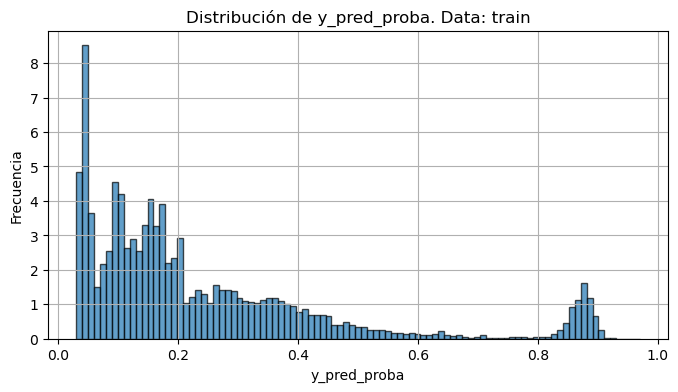

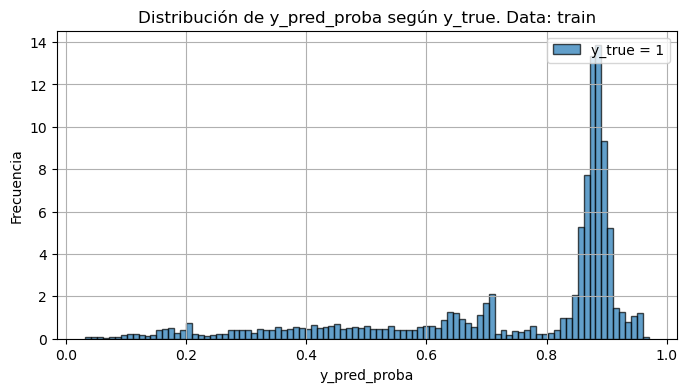

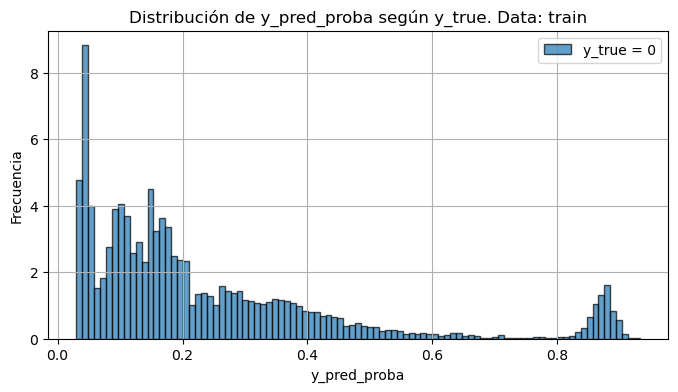

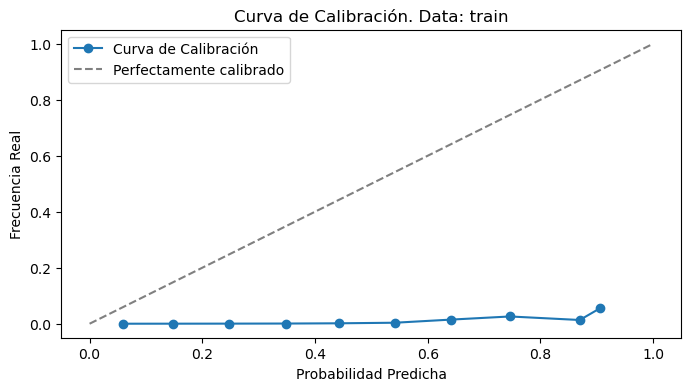

[12/19/24 13:38:37] INFO     TOP N: 612394                                                            ]8;id=899248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=669461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1116\1116]8;;\

[12/19/24 13:38:38] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=755192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=442061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=408778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=614846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85,    ]8;id=456881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=284730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             84]                                                                                   

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=10952;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=981236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=506600;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=374364;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=562007;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=799805;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=745210;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=660803;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=564171;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=802162;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

[12/19/24 13:38:39] WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=448244;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=490866;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=474288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=152198;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.7s finished


[12/19/24 13:38:40] INFO     Try Segment Dist Probs: 90                                               ]8;id=498830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=345917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1150\1150]8;;\

                    INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=805169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=89347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=609724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=20979;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [89, 88, 87, 86, 85, 84, 83, 82, 81, 79,    ]8;id=268115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=83967;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             78]                                                                                   

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=959581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=602983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=53238;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=757007;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=37220;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=886864;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=713630;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=32451;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=381422;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=460282;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=26993;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=633096;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=144156;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=688966;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=894182;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=322774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[12/19/24 13:38:43] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=505032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=369576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=98784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=125100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85,    ]8;id=885492;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=381725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             84, 83, 82]                                                                           

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=240804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=419193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=927472;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=395026;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=312215;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=848714;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=837517;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=109139;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=657835;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=643336;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=676160;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=110178;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=369024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=988680;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

                    INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=720695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=132251;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=163789;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=576601;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86]        ]8;id=972428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=264792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=226216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=277448;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=25523;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=2452;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=788941;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=963393;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=374044;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=923419;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=872036;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=105493;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=815738;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=332395;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=817844;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=361283;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=750305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=157442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.8s finished


[12/19/24 13:38:45] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=28535;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=281192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=744592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=23553;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85]    ]8;id=431172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=335313;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=933100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=327698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=735993;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=409631;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=188822;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=753664;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=554101;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=659381;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=721743;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=219532;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=398354;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=187385;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=704746;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=123041;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=4148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=142729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.8s finished


[12/19/24 13:38:46] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=800030;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=582608;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=314292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=244158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85,    ]8;id=420627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\
                             83]                                                                                   

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=164086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=139927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=643943;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=471933;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=419633;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=229053;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=300991;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=679385;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=941199;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=466795;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=310481;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=641267;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=976907;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=96833;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=830934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=248177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    2.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    4.6s
[Parallel(n_jobs=64)]: Done 900 out of 900 | elapsed:    6.1s finished


[12/19/24 13:38:53] INFO     Iniciando análisis KS por deciles de probabilidad...                      ]8;id=622144;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=166453;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#700\700]8;;\

                    INFO     Calculando el estadístico KS para cada decil...                           ]8;id=812174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=550420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#738\738]8;;\

                    INFO     Deciles donde el ks aumenta:  [94, 93, 92, 91, 90, 89, 88, 87, 86, 85]    ]8;id=34739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=156233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#762\762]8;;\

                    INFO     Iniciando el procesamiento del ks                                        ]8;id=899769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=396753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1169\1169]8;;\

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=708558;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=234122;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=215185;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=617743;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=561211;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=707945;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=716112;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=750673;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=415399;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=808023;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    WARNING  /home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_b ]8;id=987803;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=133391;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             bog_integration_fabrica_personas/pipelines/model_selection/nodes.py:11                
                             8: SettingWithCopyWarning:                                                            
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sub_group.loc[index,'prob_min'] = value_copy                                        
                                                                                                                   

                    INFO     Finalizando el procesamiento del ks                                      ]8;id=803971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=760753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#1177\1177]8;;\

                    INFO     Tipo de Threshold: KS                                                     ]8;id=608579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=146548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#295\295]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=620386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=272197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: MLP_0,Run1. Weight: 1                                             ]8;id=383612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=817119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[12/19/24 13:38:54] INFO     Update probs: Selected: 0, Target Select: 612394, Diff %: -1.0            ]8;id=222949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Update probs: Selected: 21499, Target Select: 612394, Diff %:             ]8;id=324371;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=220396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9648935162656721                                                                   

                    INFO     Update probs: Selected: 42998, Target Select: 612394, Diff %:             ]8;id=419890;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=28442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9297870325313442                                                                   

[12/19/24 13:38:55] INFO     Update probs: Selected: 64457, Target Select: 612394, Diff %:             ]8;id=999148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=191011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.894745866223379                                                                    

                    INFO     Update probs: Selected: 85943, Target Select: 612394, Diff %:             ]8;id=778178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=597157;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8596606106526191                                                                   

                    INFO     Update probs: Selected: 107434, Target Select: 612394, Diff %:            ]8;id=459574;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=915333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8245671904035637                                                                   

                    INFO     Update probs: Selected: 128946, Target Select: 612394, Diff %:            ]8;id=754279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=288621;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894394785056679                                                                   

[12/19/24 13:38:56] INFO     Update probs: Selected: 150401, Target Select: 612394, Diff %:            ]8;id=518893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=139251;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.754404843940339                                                                    

                    INFO     Update probs: Selected: 171899, Target Select: 612394, Diff %:            ]8;id=76891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=70269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7192999931416703                                                                   

                    INFO     Update probs: Selected: 193380, Target Select: 612394, Diff %:            ]8;id=246758;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=102525;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6842229022492056                                                                   

                    INFO     Update probs: Selected: 214868, Target Select: 612394, Diff %:            ]8;id=755810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=798841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6491343808071275                                                                   

[12/19/24 13:38:57] INFO     Update probs: Selected: 236368, Target Select: 612394, Diff %:            ]8;id=170951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=486254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6140262641371405                                                                   

                    INFO     Update probs: Selected: 257857, Target Select: 612394, Diff %:            ]8;id=651158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=163455;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5789361097594032                                                                   

                    INFO     Update probs: Selected: 279354, Target Select: 612394, Diff %:            ]8;id=339546;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=532300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5438328918963935                                                                   

                    INFO     Update probs: Selected: 300808, Target Select: 612394, Diff %:            ]8;id=11743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=787781;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5087998902667237                                                                   

[12/19/24 13:38:58] INFO     Update probs: Selected: 322301, Target Select: 612394, Diff %:            ]8;id=598251;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=239807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4737032041463502                                                                   

                    INFO     Update probs: Selected: 343825, Target Select: 612394, Diff %:            ]8;id=620451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=978331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4385558970205456                                                                   

                    INFO     Update probs: Selected: 365281, Target Select: 612394, Diff %:            ]8;id=765080;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=632191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40351962951955767                                                                  

[12/19/24 13:38:59] INFO     Update probs: Selected: 386727, Target Select: 612394, Diff %:            ]8;id=326146;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=591327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3684996913751604                                                                   

                    INFO     Update probs: Selected: 429576, Target Select: 612394, Diff %:            ]8;id=794986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=194200;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.29853003131970596                                                                  

                    INFO     Update probs: Selected: 451020, Target Select: 612394, Diff %:            ]8;id=400266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=167804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.26351335904662687                                                                  

                    INFO     Update probs: Selected: 472494, Target Select: 612394, Diff %:            ]8;id=121327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=157199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.22844769870377568                                                                  

[12/19/24 13:39:00] INFO     Update probs: Selected: 494069, Target Select: 612394, Diff %:            ]8;id=908269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=838319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.19321711185935853                                                                  

                    INFO     Update probs: Selected: 515558, Target Select: 612394, Diff %:            ]8;id=996192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=994811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.1581269574816213                                                                   

                    INFO     Update probs: Selected: 537025, Target Select: 612394, Diff %:            ]8;id=636657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=594864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.12307272768838362                                                                  

                    INFO     Update probs: Selected: 558578, Target Select: 612394, Diff %:            ]8;id=12581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=335487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08787806542846599                                                                  

[12/19/24 13:39:01] INFO     Update probs: Selected: 579896, Target Select: 612394, Diff %:            ]8;id=793534;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=582053;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.053067143048429605                                                                 

                    INFO     Update probs: Selected: 601570, Target Select: 612394, Diff %:            ]8;id=557545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=804334;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.0176748955737646                                                                   

                    INFO     Update probs: Selected: 612394, Target Select: 612394, Diff %: 0.0        ]8;id=622423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=283661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=357317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=85510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=246705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=505166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: random_forest_2,Run3. Weight: 1                                   ]8;id=394423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=785917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.7s finished


[12/19/24 13:39:02] INFO     Update probs: Selected: 0, Target Select: 612394, Diff %: -1.0            ]8;id=315379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=774946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

[12/19/24 13:39:03] INFO     Update probs: Selected: 22790, Target Select: 612394, Diff %:             ]8;id=935271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=469265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9627853963298139                                                                   

                    INFO     Update probs: Selected: 46207, Target Select: 612394, Diff %:             ]8;id=146743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=750630;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9245469420013913                                                                   

                    INFO     Update probs: Selected: 67809, Target Select: 612394, Diff %:             ]8;id=892157;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=97302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8892722658941793                                                                   

                    INFO     Update probs: Selected: 90748, Target Select: 612394, Diff %:             ]8;id=70611;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=237834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8518143548107917                                                                   

[12/19/24 13:39:04] INFO     Update probs: Selected: 113269, Target Select: 612394, Diff %:            ]8;id=517298;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=519179;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8150390108328952                                                                   

                    INFO     Update probs: Selected: 136086, Target Select: 612394, Diff %:            ]8;id=767665;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=850206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7777803178999141                                                                   

                    INFO     Update probs: Selected: 158767, Target Select: 612394, Diff %:            ]8;id=538651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=121042;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7407437042165664                                                                   

                    INFO     Update probs: Selected: 181461, Target Select: 612394, Diff %:            ]8;id=962817;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=743279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7036858623696509                                                                   

[12/19/24 13:39:05] INFO     Update probs: Selected: 204116, Target Select: 612394, Diff %:            ]8;id=597506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=985057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6666917050134391                                                                   

                    INFO     Update probs: Selected: 226794, Target Select: 612394, Diff %:            ]8;id=857209;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=533388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6296599901370686                                                                   

                    INFO     Update probs: Selected: 249389, Target Select: 612394, Diff %:            ]8;id=839501;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=169516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5927638089204009                                                                   

[12/19/24 13:39:06] INFO     Update probs: Selected: 272142, Target Select: 612394, Diff %:            ]8;id=415372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=68712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5556096238696003                                                                   

                    INFO     Update probs: Selected: 294866, Target Select: 612394, Diff %:            ]8;id=142354;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=696737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5185027939529127                                                                   

                    INFO     Update probs: Selected: 317651, Target Select: 612394, Diff %:            ]8;id=469069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=837668;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4812963549610218                                                                   

                    INFO     Update probs: Selected: 340301, Target Select: 612394, Diff %:            ]8;id=173629;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=928737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.44431036228310533                                                                  

[12/19/24 13:39:07] INFO     Update probs: Selected: 362786, Target Select: 612394, Diff %:            ]8;id=175071;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=279294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40759380398893524                                                                  

                    INFO     Update probs: Selected: 385341, Target Select: 612394, Diff %:            ]8;id=354523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=185723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3707629401986303                                                                   

                    INFO     Update probs: Selected: 430974, Target Select: 612394, Diff %:            ]8;id=981935;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=675565;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.29624718726832727                                                                  

                    INFO     Update probs: Selected: 476248, Target Select: 612394, Diff %:            ]8;id=676908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=231265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.22231765823963004                                                                  

[12/19/24 13:39:08] INFO     Update probs: Selected: 499120, Target Select: 612394, Diff %:            ]8;id=788551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=242122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.1849691538454002                                                                   

                    INFO     Update probs: Selected: 521706, Target Select: 612394, Diff %:            ]8;id=953037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=57698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.1480876690496641                                                                   

                    INFO     Update probs: Selected: 566919, Target Select: 612394, Diff %:            ]8;id=154292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=561271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.07425774909617011                                                                  

                    INFO     Update probs: Selected: 589760, Target Select: 612394, Diff %:            ]8;id=541335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=752444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.0369598657073714                                                                   

[12/19/24 13:39:09] INFO     Update probs: Selected: 612394, Target Select: 612394, Diff %: 0.0        ]8;id=455570;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=403147;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=820065;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=414409;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=931896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=214192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: MLP_3,Run4. Weight: 1                                             ]8;id=363021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=909897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[12/19/24 13:39:11] INFO     Update probs: Selected: 0, Target Select: 612394, Diff %: -1.0            ]8;id=981611;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=478694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Update probs: Selected: 21525, Target Select: 612394, Diff %:             ]8;id=899166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=109296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9648510599385363                                                                   

[12/19/24 13:39:12] INFO     Update probs: Selected: 42953, Target Select: 612394, Diff %:             ]8;id=574813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=611268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9298605146360023                                                                   

                    INFO     Update probs: Selected: 64457, Target Select: 612394, Diff %:             ]8;id=62801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=535725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.894745866223379                                                                    

                    INFO     Update probs: Selected: 85949, Target Select: 612394, Diff %:             ]8;id=778205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=14030;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8596508130386646                                                                   

                    INFO     Update probs: Selected: 107438, Target Select: 612394, Diff %:            ]8;id=815829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=714892;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8245606586609274                                                                   

[12/19/24 13:39:13] INFO     Update probs: Selected: 128909, Target Select: 612394, Diff %:            ]8;id=716807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=577423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894998971250535                                                                   

                    INFO     Update probs: Selected: 150410, Target Select: 612394, Diff %:            ]8;id=119010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=339387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7543901475194075                                                                   

                    INFO     Update probs: Selected: 171897, Target Select: 612394, Diff %:            ]8;id=526183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=778293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7193032590129884                                                                   

[12/19/24 13:39:14] INFO     Update probs: Selected: 193378, Target Select: 612394, Diff %:            ]8;id=223142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=996868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6842261681205237                                                                   

                    INFO     Update probs: Selected: 214880, Target Select: 612394, Diff %:            ]8;id=632076;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=333039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6491147855792186                                                                   

                    INFO     Update probs: Selected: 236392, Target Select: 612394, Diff %:            ]8;id=364776;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=166335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6139870736813228                                                                   

                    INFO     Update probs: Selected: 257846, Target Select: 612394, Diff %:            ]8;id=384799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=437931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5789540720516531                                                                   

[12/19/24 13:39:15] INFO     Update probs: Selected: 279327, Target Select: 612394, Diff %:            ]8;id=215937;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=539085;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5438769811591884                                                                   

                    INFO     Update probs: Selected: 300843, Target Select: 612394, Diff %:            ]8;id=271727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=689784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5087427375186563                                                                   

                    INFO     Update probs: Selected: 322340, Target Select: 612394, Diff %:            ]8;id=254238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=90561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.47363951965564655                                                                  

                    INFO     Update probs: Selected: 365310, Target Select: 612394, Diff %:            ]8;id=29479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=547005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40347227438544464                                                                  

[12/19/24 13:39:16] INFO     Update probs: Selected: 386764, Target Select: 612394, Diff %:            ]8;id=409020;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=270243;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.36843927275577487                                                                  

                    INFO     Update probs: Selected: 408418, Target Select: 612394, Diff %:            ]8;id=392539;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=776522;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3330796839942913                                                                   

                    INFO     Update probs: Selected: 429748, Target Select: 612394, Diff %:            ]8;id=141186;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=601383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.298249166386346                                                                    

                    INFO     Update probs: Selected: 451222, Target Select: 612394, Diff %:            ]8;id=201240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=767630;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2631835060434949                                                                   

[12/19/24 13:39:17] INFO     Update probs: Selected: 472666, Target Select: 612394, Diff %:            ]8;id=186668;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=848640;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.22816683377041577                                                                  

                    INFO     Update probs: Selected: 494887, Target Select: 612394, Diff %:            ]8;id=194324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=602164;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.19188137049023996                                                                  

                    INFO     Update probs: Selected: 515650, Target Select: 612394, Diff %:            ]8;id=664838;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=539511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.15797672740098695                                                                  

                    INFO     Update probs: Selected: 558690, Target Select: 612394, Diff %:            ]8;id=144632;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=879041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08769517663465023                                                                  

[12/19/24 13:39:18] INFO     Update probs: Selected: 580196, Target Select: 612394, Diff %:            ]8;id=77177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=322250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.05257726235070886                                                                  

                    INFO     Update probs: Selected: 601605, Target Select: 612394, Diff %:            ]8;id=311658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=115416;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.017617742825697183                                                                 

                    INFO     Update probs: Selected: 612394, Target Select: 612394, Diff %: 0.0        ]8;id=102392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=777290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=263565;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=436190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=301888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=868567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: xgboost_4,Run5. Weight: 1                                         ]8;id=954941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=377951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[12/19/24 13:39:19] INFO     Update probs: Selected: 0, Target Select: 612394, Diff %: -1.0            ]8;id=363000;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=654594;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Update probs: Selected: 21489, Target Select: 612394, Diff %:             ]8;id=609731;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=827460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9649098456222628                                                                   

                    INFO     Update probs: Selected: 42945, Target Select: 612394, Diff %:             ]8;id=416794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=717693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9298735781212749                                                                   

                    INFO     Update probs: Selected: 64484, Target Select: 612394, Diff %:             ]8;id=898561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=873305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8947017769605842                                                                   

[12/19/24 13:39:20] INFO     Update probs: Selected: 85943, Target Select: 612394, Diff %:             ]8;id=801045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=489940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8596606106526191                                                                   

                    INFO     Update probs: Selected: 107451, Target Select: 612394, Diff %:            ]8;id=696331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=248874;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8245394304973596                                                                   

                    INFO     Update probs: Selected: 128921, Target Select: 612394, Diff %:            ]8;id=979177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=568119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894803018971447                                                                   

[12/19/24 13:39:21] INFO     Update probs: Selected: 150410, Target Select: 612394, Diff %:            ]8;id=235982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=677520;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7543901475194075                                                                   

                    INFO     Update probs: Selected: 171903, Target Select: 612394, Diff %:            ]8;id=361601;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=480239;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7192934613990339                                                                   

                    INFO     Update probs: Selected: 193376, Target Select: 612394, Diff %:            ]8;id=271706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=637483;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6842294339918419                                                                   

                    INFO     Update probs: Selected: 214872, Target Select: 612394, Diff %:            ]8;id=858755;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=841949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6491278490644912                                                                   

[12/19/24 13:39:22] INFO     Update probs: Selected: 236353, Target Select: 612394, Diff %:            ]8;id=854554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=186930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6140507581720265                                                                   

                    INFO     Update probs: Selected: 257851, Target Select: 612394, Diff %:            ]8;id=944206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=393488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5789459073733577                                                                   

                    INFO     Update probs: Selected: 279372, Target Select: 612394, Diff %:            ]8;id=545003;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=364689;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5438034990545303                                                                   

                    INFO     Update probs: Selected: 322278, Target Select: 612394, Diff %:            ]8;id=909228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=768855;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4737407616665088                                                                   

[12/19/24 13:39:23] INFO     Update probs: Selected: 343806, Target Select: 612394, Diff %:            ]8;id=546510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=516321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.43858692279806794                                                                  

                    INFO     Update probs: Selected: 365248, Target Select: 612394, Diff %:            ]8;id=199142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=347949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40357351639630695                                                                  

                    INFO     Update probs: Selected: 386824, Target Select: 612394, Diff %:            ]8;id=614599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=330044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3683412966162307                                                                   

                    INFO     Update probs: Selected: 408293, Target Select: 612394, Diff %:            ]8;id=247857;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=226418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3332838009516749                                                                   

[12/19/24 13:39:24] INFO     Update probs: Selected: 429715, Target Select: 612394, Diff %:            ]8;id=404902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=995373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2983030532630953                                                                   

                    INFO     Update probs: Selected: 451327, Target Select: 612394, Diff %:            ]8;id=704800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=267420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2630120477992926                                                                   

                    INFO     Update probs: Selected: 494129, Target Select: 612394, Diff %:            ]8;id=952497;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=385884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.19311913571981437                                                                  

[12/19/24 13:39:25] INFO     Update probs: Selected: 537147, Target Select: 612394, Diff %:            ]8;id=37120;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=236784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.12287350953797718                                                                  

                    INFO     Update probs: Selected: 558819, Target Select: 612394, Diff %:            ]8;id=819387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=891018;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08748452793463032                                                                  

                    INFO     Update probs: Selected: 580204, Target Select: 612394, Diff %:            ]8;id=150126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=219176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.052564198865436305                                                                 

                    INFO     Update probs: Selected: 601807, Target Select: 612394, Diff %:            ]8;id=72379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=959681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.01728788982256521                                                                  

[12/19/24 13:39:26] INFO     Update probs: Selected: 612394, Target Select: 612394, Diff %: 0.0        ]8;id=400396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=587328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=710693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=526946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=234506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=769382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: random_forest_5,Run6. Weight: 1                                   ]8;id=663860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=585225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.8s finished


[12/19/24 13:39:27] INFO     Update probs: Selected: 0, Target Select: 612394, Diff %: -1.0            ]8;id=717083;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=498701;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Update probs: Selected: 21504, Target Select: 612394, Diff %:             ]8;id=968678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=296432;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9648853515873768                                                                   

                    INFO     Update probs: Selected: 42923, Target Select: 612394, Diff %:             ]8;id=169695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=475927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9299095027057744                                                                   

[12/19/24 13:39:28] INFO     Update probs: Selected: 64344, Target Select: 612394, Diff %:             ]8;id=890784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=21517;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8949303879528538                                                                   

                    INFO     Update probs: Selected: 85984, Target Select: 612394, Diff %:             ]8;id=321782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=521319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8595936602905973                                                                   

                    INFO     Update probs: Selected: 107401, Target Select: 612394, Diff %:            ]8;id=457256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=110227;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.824621077280313                                                                    

[12/19/24 13:39:29] INFO     Update probs: Selected: 128927, Target Select: 612394, Diff %:            ]8;id=862405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=171837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894705042831902                                                                   

                    INFO     Update probs: Selected: 150407, Target Select: 612394, Diff %:            ]8;id=76465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=97014;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7543950463263847                                                                   

                    INFO     Update probs: Selected: 171888, Target Select: 612394, Diff %:            ]8;id=466607;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=700015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.71931795543392                                                                     

                    INFO     Update probs: Selected: 193382, Target Select: 612394, Diff %:            ]8;id=395678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=860826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6842196363778874                                                                   

[12/19/24 13:39:30] INFO     Update probs: Selected: 214916, Target Select: 612394, Diff %:            ]8;id=721067;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=43202;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6490559998954921                                                                   

                    INFO     Update probs: Selected: 236426, Target Select: 612394, Diff %:            ]8;id=594351;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=125537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6139315538689144                                                                   

                    INFO     Update probs: Selected: 257834, Target Select: 612394, Diff %:            ]8;id=853291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=896241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5789736672795619                                                                   

                    INFO     Update probs: Selected: 279370, Target Select: 612394, Diff %:            ]8;id=773556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=695137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5438067649258483                                                                   

[12/19/24 13:39:31] INFO     Update probs: Selected: 300860, Target Select: 612394, Diff %:            ]8;id=789808;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=496858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5087149776124521                                                                   

                    INFO     Update probs: Selected: 322334, Target Select: 612394, Diff %:            ]8;id=980682;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=598002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.47364931726960097                                                                  

                    INFO     Update probs: Selected: 365326, Target Select: 612394, Diff %:            ]8;id=575391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=522115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.40344614741489954                                                                  

[12/19/24 13:39:32] INFO     Update probs: Selected: 386861, Target Select: 612394, Diff %:            ]8;id=74030;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=915711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.36828087799684517                                                                  

                    INFO     Update probs: Selected: 408205, Target Select: 612394, Diff %:            ]8;id=184455;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=197898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.33342749928967297                                                                  

                    INFO     Update probs: Selected: 451308, Target Select: 612394, Diff %:            ]8;id=465591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=260206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.26304307357681495                                                                  

                    INFO     Update probs: Selected: 472648, Target Select: 612394, Diff %:            ]8;id=408315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=612225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.22819622661227904                                                                  

[12/19/24 13:39:33] INFO     Update probs: Selected: 494101, Target Select: 612394, Diff %:            ]8;id=639787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=401345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.19316485791826832                                                                  

                    INFO     Update probs: Selected: 515767, Target Select: 612394, Diff %:            ]8;id=462227;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=943807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.15778567392887585                                                                  

                    INFO     Update probs: Selected: 558794, Target Select: 612394, Diff %:            ]8;id=905346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=681593;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08752535132610705                                                                  

                    INFO     Update probs: Selected: 601564, Target Select: 612394, Diff %:            ]8;id=357730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=254521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.01768469318771902                                                                  

[12/19/24 13:39:34] INFO     Update probs: Selected: 612394, Target Select: 612394, Diff %: 0.0        ]8;id=215600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=120881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=522921;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=63940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=145313;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: random_forest_8,Run9. Weight: 1                                   ]8;id=679249;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=83387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.8s finished


[12/19/24 13:39:35] INFO     Update probs: Selected: 0, Target Select: 612394, Diff %: -1.0            ]8;id=266539;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=281457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Update probs: Selected: 21474, Target Select: 612394, Diff %:             ]8;id=421108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=670161;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9649343396571488                                                                   

[12/19/24 13:39:36] INFO     Update probs: Selected: 42958, Target Select: 612394, Diff %:             ]8;id=449031;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=810334;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9298523499577069                                                                   

                    INFO     Update probs: Selected: 64312, Target Select: 612394, Diff %:             ]8;id=213131;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=420560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.894982641893944                                                                    

                    INFO     Update probs: Selected: 86094, Target Select: 612394, Diff %:             ]8;id=967596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=890386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8594140373680996                                                                   

                    INFO     Update probs: Selected: 107443, Target Select: 612394, Diff %:            ]8;id=46588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=94864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8245524939826321                                                                   

[12/19/24 13:39:37] INFO     Update probs: Selected: 128918, Target Select: 612394, Diff %:            ]8;id=301387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=520964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894852007041219                                                                   

                    INFO     Update probs: Selected: 150454, Target Select: 612394, Diff %:            ]8;id=533554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=472433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7543182983504084                                                                   

                    INFO     Update probs: Selected: 171821, Target Select: 612394, Diff %:            ]8;id=379742;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=109242;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7194273621230777                                                                   

[12/19/24 13:39:38] INFO     Update probs: Selected: 193030, Target Select: 612394, Diff %:            ]8;id=252929;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=481126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6847944297298798                                                                   

                    INFO     Update probs: Selected: 214477, Target Select: 612394, Diff %:            ]8;id=114923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=997576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6497728586498235                                                                   

                    INFO     Update probs: Selected: 235995, Target Select: 612394, Diff %:            ]8;id=533264;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=215704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6146353491379732                                                                   

                    INFO     Update probs: Selected: 257450, Target Select: 612394, Diff %:            ]8;id=669959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=571265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5796007145726444                                                                   

[12/19/24 13:39:39] INFO     Update probs: Selected: 279112, Target Select: 612394, Diff %:            ]8;id=213586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=738664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5442280623258883                                                                   

                    INFO     Update probs: Selected: 300450, Target Select: 612394, Diff %:            ]8;id=646831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=233155;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5093844812326704                                                                   

                    INFO     Update probs: Selected: 322004, Target Select: 612394, Diff %:            ]8;id=692654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=374648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4741881860370938                                                                   

                    INFO     Update probs: Selected: 343516, Target Select: 612394, Diff %:            ]8;id=333966;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=430026;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.43906047413919796                                                                  

[12/19/24 13:39:40] INFO     Update probs: Selected: 386308, Target Select: 612394, Diff %:            ]8;id=528153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=137934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.3691838914163104                                                                   

                    INFO     Update probs: Selected: 407986, Target Select: 612394, Diff %:            ]8;id=937321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=305225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.33378511219900914                                                                  

                    INFO     Update probs: Selected: 429426, Target Select: 612394, Diff %:            ]8;id=956878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=443279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2987749716685663                                                                   

[12/19/24 13:39:41] INFO     Update probs: Selected: 450868, Target Select: 612394, Diff %:            ]8;id=655957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=171624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.26376156526680533                                                                  

                    INFO     Update probs: Selected: 472242, Target Select: 612394, Diff %:            ]8;id=90523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=256924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2288591984898611                                                                   

                    INFO     Update probs: Selected: 493842, Target Select: 612394, Diff %:            ]8;id=30085;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=102993;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.19358778825396722                                                                  

                    INFO     Update probs: Selected: 558176, Target Select: 612394, Diff %:            ]8;id=739348;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=761615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08853450556341179                                                                  

[12/19/24 13:39:42] INFO     Update probs: Selected: 579820, Target Select: 612394, Diff %:            ]8;id=46142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=441512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.05319124615851886                                                                  

                    INFO     Update probs: Selected: 601179, Target Select: 612394, Diff %:            ]8;id=729749;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=991819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.018313373416460645                                                                 

                    INFO     Update probs: Selected: 612394, Target Select: 612394, Diff %: 0.0        ]8;id=389730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=246859;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=731957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=542325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

                    INFO     ------------------------------------------------------                    ]8;id=993630;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=434871;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#313\313]8;;\

                    INFO     Modelo: random_forest_11,Run12. Weight: 1                                 ]8;id=186384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=887957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#314\314]8;;\

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    2.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    4.7s
[Parallel(n_jobs=64)]: Done 900 out of 900 | elapsed:    6.2s finished


[12/19/24 13:39:49] INFO     Update probs: Selected: 0, Target Select: 612394, Diff %: -1.0            ]8;id=242877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=493069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Update probs: Selected: 21550, Target Select: 612394, Diff %:             ]8;id=809610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=308303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9648102365470596                                                                   

[12/19/24 13:39:50] INFO     Update probs: Selected: 43017, Target Select: 612394, Diff %:             ]8;id=6888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=434329;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.9297560067538219                                                                   

                    INFO     Update probs: Selected: 64651, Target Select: 612394, Diff %:             ]8;id=61822;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=895892;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8944290767055196                                                                   

                    INFO     Update probs: Selected: 86021, Target Select: 612394, Diff %:             ]8;id=899899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=366909;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8595332416712117                                                                   

                    INFO     Update probs: Selected: 107414, Target Select: 612394, Diff %:            ]8;id=316968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=348678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.8245998491167451                                                                   

[12/19/24 13:39:51] INFO     Update probs: Selected: 128912, Target Select: 612394, Diff %:            ]8;id=755170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=803041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7894949983180762                                                                   

                    INFO     Update probs: Selected: 150394, Target Select: 612394, Diff %:            ]8;id=173041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=766710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.7544162744899525                                                                   

                    INFO     Update probs: Selected: 171860, Target Select: 612394, Diff %:            ]8;id=624384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=514515;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.719363677632374                                                                    

[12/19/24 13:39:52] INFO     Update probs: Selected: 193334, Target Select: 612394, Diff %:            ]8;id=711864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=442110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6842980172895228                                                                   

                    INFO     Update probs: Selected: 214822, Target Select: 612394, Diff %:            ]8;id=795650;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=229837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.6492094958474446                                                                   

                    INFO     Update probs: Selected: 236317, Target Select: 612394, Diff %:            ]8;id=83428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=282982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.614109543855753                                                                    

                    INFO     Update probs: Selected: 257847, Target Select: 612394, Diff %:            ]8;id=589059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=143920;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5789524391159939                                                                   

[12/19/24 13:39:53] INFO     Update probs: Selected: 279311, Target Select: 612394, Diff %:            ]8;id=475171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=888468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5439031081297335                                                                   

                    INFO     Update probs: Selected: 300838, Target Select: 612394, Diff %:            ]8;id=626891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=501522;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.5087509021969516                                                                   

                    INFO     Update probs: Selected: 322221, Target Select: 612394, Diff %:            ]8;id=967465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=504879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.4738338389990758                                                                   

[12/19/24 13:39:54] INFO     Update probs: Selected: 343806, Target Select: 612394, Diff %:            ]8;id=396578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=297184;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.43858692279806794                                                                  

                    INFO     Update probs: Selected: 386698, Target Select: 612394, Diff %:            ]8;id=528434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=706896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.36854704650927345                                                                  

                    INFO     Update probs: Selected: 408276, Target Select: 612394, Diff %:            ]8;id=274984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=206894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.33331156085787905                                                                  

                    INFO     Update probs: Selected: 451110, Target Select: 612394, Diff %:            ]8;id=727171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=113968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.2633663948373106                                                                   

[12/19/24 13:39:55] INFO     Update probs: Selected: 472662, Target Select: 612394, Diff %:            ]8;id=10113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=541908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.22817336551305206                                                                  

                    INFO     Update probs: Selected: 515679, Target Select: 612394, Diff %:            ]8;id=425054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=837599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.15792937226687395                                                                  

                    INFO     Update probs: Selected: 537145, Target Select: 612394, Diff %:            ]8;id=907674;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=178357;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.12287677540929533                                                                  

                    INFO     Update probs: Selected: 558720, Target Select: 612394, Diff %:            ]8;id=368292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=498474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.08764618856487817                                                                  

[12/19/24 13:39:56] INFO     Update probs: Selected: 580141, Target Select: 612394, Diff %:            ]8;id=895815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=358185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.05266707381195766                                                                  

                    INFO     Update probs: Selected: 601653, Target Select: 612394, Diff %:            ]8;id=122825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=37314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\
                             -0.01753936191406186                                                                  

                    INFO     Update probs: Selected: 612394, Target Select: 612394, Diff %: 0.0        ]8;id=202754;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=464381;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#225\225]8;;\

                    INFO     Finish                                                                    ]8;id=921044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=115686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#251\251]8;;\

[12/19/24 13:39:57] INFO     Iniciando sistema de votaciones..                                         ]8;id=656806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=345112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#331\331]8;;\

                    INFO     Ok Sistema de votaciones                                                  ]8;id=870304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py\nodes.py]8;;\:]8;id=311372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_selection/nodes.py#350\350]8;;\

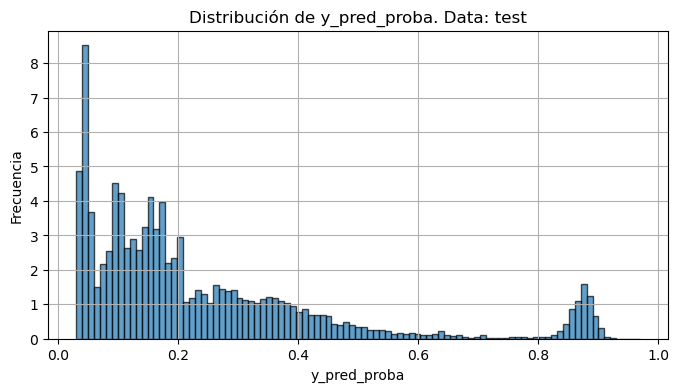

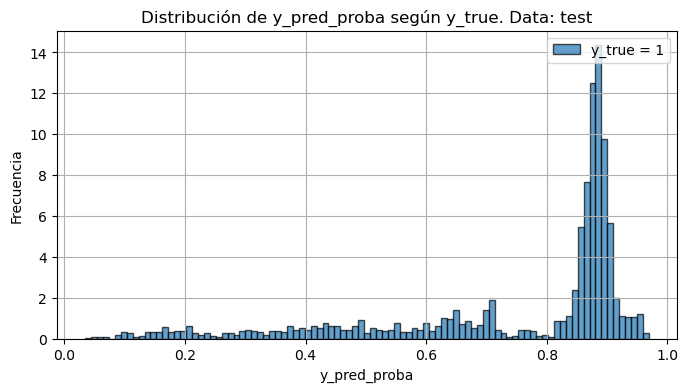

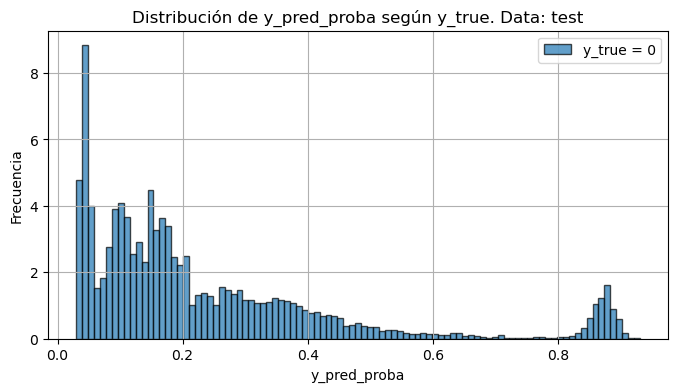

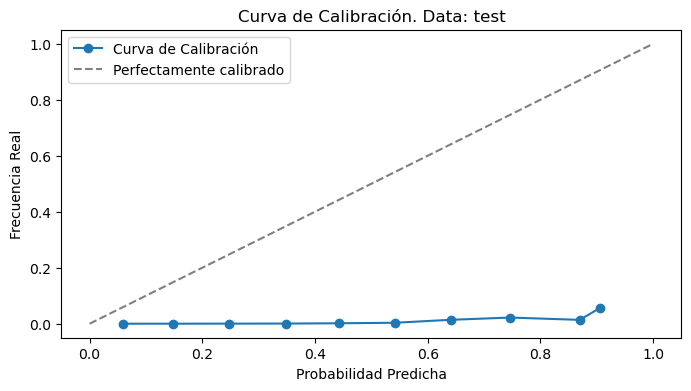

value              name_model  \
class_name metric_name    dataset_name                                   
1          f1-score n_top test          1.0128  [0, 2, 3, 4, 5, 8, 11]   
           true_sum n_top test            3117  [0, 2, 3, 4, 5, 8, 11]   
           backtest       test           0.509  [0, 2, 3, 4, 5, 8, 11]   

                                       model_name       select_model  
class_name metric_name    dataset_name                                
1          f1-score n_top test           Ensamble  modelo_produccion  
           true_sum n_top test           Ensamble  modelo_produccion  
           backtest       test           Ensamble  modelo_produccion

In [19]:
info_save2=ms.calc_metrics_before_backtesting(info_save_all, info_save_temp,params)

In [ ]:
# con eda
check_df_cientifico = info_save2['select_model2']
check_df_cientifico = check_df_cientifico[np.in1d(check_df_cientifico.index.get_level_values(1),['backtest'])].reset_index()
check_df_cientifico = check_df_cientifico.set_index(['select_model','name_model','dataset_name','class_name']).sort_index()
check_df_cientifico

In [20]:
# sin eda
check_df_cientifico = info_save2['select_model2']
check_df_cientifico = check_df_cientifico[np.in1d(check_df_cientifico.index.get_level_values(1),['backtest'])].reset_index() 
check_df_cientifico = check_df_cientifico.set_index(['select_model','name_model','dataset_name','class_name']).sort_index()
check_df_cientifico

metric_name  \
select_model        name_model             dataset_name class_name               
best_fitting_model  Run1                   test         1             backtest   
                                           train        1             backtest   
best_model_name     Run3                   test         1             backtest   
                                           train        1             backtest   
best_unbiased_model Run3                   test         1             backtest   
                                           train        1             backtest   
modelo_produccion   [0, 2, 3, 4, 5, 8, 11] test         1             backtest   
                                           train        1             backtest   

                                                                     value  \
select_model        name_model             dataset_name class_name           
best_fitting_model  Run1                   test         1           0.5031   
                                           train        1           0.5109   
best_model_name     Run3                   test         1           0.4997   
                                           train        1            0.499   
best_unbiased_model Run3                   test         1           0.4997   
                                           train        1            0.499   
modelo_produccion   [0, 2, 3, 4, 5, 8, 11] test         1            0.509   
                                           train        1            0.514   

                                                                         model_name  
select_model        name_model             dataset_name class_name                   
best_fitting_model  Run1                   test         1                     MLP_0  
                                           train        1                     MLP_0  
best_model_name     Run3                   test         1           random_forest_2  
                                           train        1           random_forest_2  
best_unbiased_model Run3                   test         1           random_forest_2  
                                           train        1           random_forest_2  
modelo_produccion   [0, 2, 3, 4, 5, 8, 11] test         1                  Ensamble  
                                           train        1                  Ensamble

In [21]:
# ks en uno de los modeos del ensamble
display(info_save2[info_save2['modelo_produccion']['nodos_select'][0]]['ks_train'].head())
display(info_save2[info_save2['modelo_produccion']['nodos_select'][0]]['ks_test'].head())

prob_min  prob_max  tasa_aperturas
0     92.61     99.77            3.03
1     89.36     92.61            1.91
2     86.74     89.36            1.69
3     84.37     86.74            1.48
4     81.86     84.37            1.21

prob_min  prob_max  tasa_aperturas
0     92.63     99.77            3.09
1     89.36     92.63            1.88
2     86.73     89.36            1.51
3     84.33     86.73            1.38
4     81.79     84.33            1.17

# optimizar ensamblado

In [24]:
train = info_save2['Votaciones']['train']
train2 = train.replace(0,np.nan).dropna(how = 'all').replace(np.nan,0)
index_train = ~train.index.isin(train2.index.tolist())
drops = train.index[index_train]
train.shape

test = info_save2['Votaciones']['test']
test2 = test.replace(0,np.nan).dropna(how = 'all').replace(np.nan,0)
index_test = ~test.index.isin(test2.index.tolist())
drops2 = test.index[index_test]
#test.index = list(range(test.shape[0]))
test.shape

(2041316, 8)

In [25]:
best_probs = params['n_obs_filter']
best_probs = 0.2
import itertools
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
def calcular_metricas(itter,best_probs = best_probs):
    res = results[itter]
    total_count = res.shape[0]
    selected = res.nlargest(int(total_count * best_probs)).index
    return itter, y_true['y'][selected].sum()  # o la métrica que necesites

In [26]:
mejor_test_dado_mejores_train = True
ignore_train = False

In [41]:
mejor_test_dado_mejores_train = False
ignore_train = True

In [42]:
# Obtener el número de núcleos disponibles
timing = time.time()
num_nucleos = int(cpu_count()/2) # Puedes ajustar este número según sea necesario
msj = ['Train Data','Test Data']
lopps_df = [train,test]
nulls = [drops,drops2]
if ignore_train == True:
    msj = ["test Data"]
    lopps_df = [test]
    nulls = [drops2]
df_model_unic = pd.DataFrame()

for t,df_select in enumerate(lopps_df):
    y_true = df_select[['y']]
    tot = int(y_true.shape[0]*best_probs)
    print("N TOP",tot,".EMPEZAMOS: ",msj[t])
    dropping = nulls[t]
    df_select = df_select.drop('y', axis = 1).drop(dropping, axis = 0)

    if t == 0:
        n = df_select.shape[1]
        # Lista de elementos
        modelos = list(range(0,min(n,3),1)) # el algoritmo se ponderara son con 3 discriminaciones
        # Obtener todas las combinaciones de 2 elementos
        combinaciones = list(itertools.product(modelos, repeat = n))
        combinaciones = pd.DataFrame(combinaciones, columns = df_select.columns.tolist())
        weights = combinaciones.div(combinaciones.sum(axis=1), axis=0).dropna(how = 'all')
        modelos_unicos = []
        for i in range(n):
            filt = combinaciones[combinaciones[combinaciones.columns[i]] == 1]
            filt = filt.drop(combinaciones.columns[i], axis = 1)
            filt = filt.loc[(filt == 0).all(axis=1)]
            modelos_unicos.append(filt.index[0])
        weights_unicos = weights.loc[modelos_unicos]
        weights = weights.drop_duplicates()
    else:
        if mejor_test_dado_mejores_train == True:
            weights = weights.loc[best_iter_w.index.tolist()+modelos_unicos]
        else:
            pass
        #results_train = results.copy()
    logger.info(f"Numero de iteraciones: {weights.shape[0]}. {msj[t]}")
    #results = df_select @ weights.T # observaciones x iteraciones
    results = df_select.astype(np.float32).values @ weights.astype(np.float32).T.values
    results = pd.DataFrame(results, index = df_select.index, columns = weights.T.columns)
    nulos_temp =pd.DataFrame(np.zeros((dropping.shape[0],weights.shape[0])),index = dropping, columns = results.columns)
    results = pd.concat([results,nulos_temp], axis = 0)
    results = results.loc[y_true.index]
    # Usar Pool para paralelizar
    if __name__ == '__main__':
        with Pool(processes=num_nucleos) as pool:  # Especificar el número de núcleos
            resultados = pool.map(calcular_metricas, results.columns)
    
        # Convertir los resultados a un DataFrame
        epochs = pd.DataFrame(resultados, columns=['Iteracion', 'Valor'])
        epochs.set_index('Iteracion', inplace=True)

    maxi_true = epochs['Valor'].max()
    best_iter_w = epochs[epochs['Valor'] == maxi_true]
    trues = y_true['y'].sum()
    logger.info(f"TP: {maxi_true}. True: {trues}. Tasa de Exito: {np.round(maxi_true/tot*100,4)}%. Usando {best_probs} deciles para {msj[t]}")
    if best_iter_w.shape[0] == 1:
        logger.info(f"Numero de Iteraciones Finales: {best_iter_w.shape[0]}")
        break
    if t == 1:
        logger.info(f"Numero de Iteraciones Finales: {best_iter_w.shape[0]}")
minutess = (time.time() - timing) /60
hrs = math.floor(minutess / 60)
minutes = minutess - hrs * 60
logger.info(f"Hrs: {hrs}. Min {minutes}")

N TOP 408263 .EMPEZAMOS:  test Data


[12/19/24 13:52:28] INFO     Numero de iteraciones: 2059. test Data                                ]8;id=938544;file:///tmp/ipykernel_230/2863225296.py\2863225296.py]8;;\:]8;id=75847;file:///tmp/ipykernel_230/2863225296.py#42\42]8;;\

[12/19/24 13:53:33] INFO     TP: 3071.0. True: 3245.0. Tasa de Exito: 0.7522%. Usando 0.2 deciles  ]8;id=538070;file:///tmp/ipykernel_230/2863225296.py\2863225296.py]8;;\:]8;id=522572;file:///tmp/ipykernel_230/2863225296.py#61\61]8;;\
                             para test Data                                                                        

                    INFO     Numero de Iteraciones Finales: 1                                      ]8;id=81067;file:///tmp/ipykernel_230/2863225296.py\2863225296.py]8;;\:]8;id=873907;file:///tmp/ipykernel_230/2863225296.py#63\63]8;;\

                    INFO     Hrs: 0. Min 1.0815377235412598                                        ]8;id=139756;file:///tmp/ipykernel_230/2863225296.py\2863225296.py]8;;\:]8;id=33922;file:///tmp/ipykernel_230/2863225296.py#70\70]8;;\

In [43]:
print(mejor_test_dado_mejores_train)
print(ignore_train)

False
True


In [44]:
epochs_select = (epochs.loc[modelos_unicos]/tot*100).round(4).sort_values(by="Valor", ascending = False)
mejor_unico = epochs_select.index[0]
print("Mejor modelo Unico")
display(combinaciones.loc[[mejor_unico]])
print("% TP en n_filt_obs de los modelos individuales o unicos ejecutados")
display(epochs_select)
print("Cominaciones e ietraciones de modelos unicos")
display(combinaciones.loc[modelos_unicos])
toti = int(y_true.shape[0]*0.1)
a,b = calcular_metricas(mejor_unico,0.1)
print("Decil 1: ",(a,np.round(100*b/toti,4)))
toti = int(y_true.shape[0]*0.2)
a,b = calcular_metricas(mejor_unico,0.2)
print("Decil 2: ",(a,np.round(100*b/toti,4)))
toti = int(y_true.shape[0]*0.3)
a,b = calcular_metricas(mejor_unico,0.3)
print("Decil 3: ",(a,np.round(100*b/toti,4)))

Mejor modelo Unico


Run1  Run3  Run4  Run5  Run6  Run9  Run12
27     0     0     0     1     0     0      0

% TP en n_filt_obs de los modelos individuales o unicos ejecutados


Valor
Iteracion        
27         0.7488
81         0.7373
9          0.7307
1          0.7287
729        0.7267
3          0.7265
243        0.7260

Cominaciones e ietraciones de modelos unicos


Run1  Run3  Run4  Run5  Run6  Run9  Run12
729     1     0     0     0     0     0      0
243     0     1     0     0     0     0      0
81      0     0     1     0     0     0      0
27      0     0     0     1     0     0      0
9       0     0     0     0     1     0      0
3       0     0     0     0     0     1      0
1       0     0     0     0     0     0      1

Decil 1:  (27, 1.3952)
Decil 2:  (27, 0.7488)
Decil 3:  (27, 0.5118)


In [45]:
epochs_select = (epochs/tot*100).round(4).sort_values(by="Valor", ascending = False)
mejor_combinado = epochs_select.index[0]
print("Mejor modelo Iteraciones")
display(combinaciones.loc[[mejor_combinado]])
print("% TP en n_filt_obs de los modelos individuales o unicos ejecutados")
display(epochs_select.head())
toti = int(y_true.shape[0]*0.1)
a,b = calcular_metricas(mejor_combinado,0.1)
print("Decil 1: ",(a,np.round(100*b/toti,4)))
toti = int(y_true.shape[0]*0.2)
a,b = calcular_metricas(mejor_combinado,0.2)
print("Decil 2: ",(a,np.round(100*b/toti,4)))
toti = int(y_true.shape[0]*0.3)
a,b = calcular_metricas(mejor_combinado,0.3)
print("Decil 3: ",(a,np.round(100*b/toti,4)))

Mejor modelo Iteraciones


Run1  Run3  Run4  Run5  Run6  Run9  Run12
135     0     0     1     2     0     0      0

% TP en n_filt_obs de los modelos individuales o unicos ejecutados


Valor
Iteracion        
135        0.7522
144        0.7503
108        0.7498
864        0.7498
225        0.7498

Decil 1:  (135, 1.3878)
Decil 2:  (135, 0.7522)
Decil 3:  (135, 0.5123)


In [ ]:
iterr = [135,144,108,864,225] # test best in test
iterr2 = [135,144,108,864,225] # test best in train
iterr3 = [27,135,108,864,783] # train best in test
iterr4 = [27,135,108,864,783] # train best in train

In [44]:
# sin eda
# test best in test
display(combinaciones.loc[iterr])
display(epochs_select.loc[iterr])

Run1  Run3  Run4  Run5  Run6  Run9  Run12
135     0     0     1     2     0     0      0
144     0     0     1     2     1     0      0
108     0     0     1     1     0     0      0
864     1     0     1     2     0     0      0
225     0     0     2     2     1     0      0

Valor
Iteracion        
135        0.7522
144        0.7503
108        0.7498
864        0.7498
225        0.7498

In [31]:
# sin eda
# test best in train
display(combinaciones.loc[iterr2])
display(epochs_select.loc[iterr2])

Run1  Run3  Run4  Run5  Run6  Run9  Run12
135     0     0     1     2     0     0      0
144     0     0     1     2     1     0      0
108     0     0     1     1     0     0      0
864     1     0     1     2     0     0      0
225     0     0     2     2     1     0      0

Valor
Iteracion        
135        0.7695
144        0.7649
108        0.7689
864        0.7678
225        0.7653

In [45]:
# sin eda
# train best in test
display(combinaciones.loc[iterr3])
display(epochs_select.loc[iterr3])

Run1  Run3  Run4  Run5  Run6  Run9  Run12
27      0     0     0     1     0     0      0
135     0     0     1     2     0     0      0
108     0     0     1     1     0     0      0
864     1     0     1     2     0     0      0
783     1     0     0     2     0     0      0

Valor
Iteracion        
27         0.7488
135        0.7522
108        0.7498
864        0.7498
783        0.7488

In [37]:
# sin eda
# train best in train
display(combinaciones.loc[iterr4])
display(epochs_select.loc[iterr4])

Run1  Run3  Run4  Run5  Run6  Run9  Run12
27      0     0     0     1     0     0      0
135     0     0     1     2     0     0      0
108     0     0     1     1     0     0      0
864     1     0     1     2     0     0      0
783     1     0     0     2     0     0      0

Valor
Iteracion        
27         0.7711
135        0.7695
108        0.7689
864        0.7678
783        0.7677

In [ ]:
# con eda
iterr = [81,171,163] # test best in test
display(combinaciones.loc[iterr])
display(epochs_select.loc[iterr])

In [ ]:
# con eda
iterr2 = [81,171,163] # test best in train
display(combinaciones.loc[iterr2])
display(epochs_select.loc[iterr2])

In [ ]:
# con eda
iterr3 = [81,171,163] # train best in test
display(combinaciones.loc[iterr3])
display(epochs_select.loc[iterr3])

In [ ]:
# con eda
iterr4 = [81,171,163] # train best in train
display(combinaciones.loc[iterr4])
display(epochs_select.loc[iterr4])

In [37]:
combinaciones_interes = list(set([mejor_unico]+iterr+iterr2+iterr3+iterr4))
rangos = sorted(list(set([params['n_obs_filter'],0.01,0.05,0.1,0.2,0.3,0.5])))
print('Iteracion: ',combinaciones_interes)
print('Calling: ',rangos)

Iteracion:  [864, 225, 135, 108, 783, 144, 27]
Calling:  [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]


In [38]:
# sin eda train
summary = pd.DataFrame()
for mejor_combinado in combinaciones_interes:
    toti = int(y_true.shape[0]*0.1)
    
    for nodo in rangos:
        a,b = calcular_metricas(mejor_combinado,nodo)
        res1234 = np.round(100*b/toti,4)
        summary.loc[mejor_combinado,nodo] = res1234
summary.index.name = 'Iteraccion'
summary

0.01    0.05    0.10    0.20    0.30    0.50
Iteraccion                                                
864         0.5782  1.1929  1.4112  1.5355  1.5636  1.5789
225         0.5710  1.1752  1.4063  1.5305  1.5624  1.5778
135         0.5766  1.2120  1.4260  1.5391  1.5668  1.5778
108         0.5734  1.1811  1.4178  1.5379  1.5663  1.5778
783         0.5770  1.2060  1.4193  1.5354  1.5639  1.5762
144         0.5702  1.1945  1.4134  1.5299  1.5611  1.5778
27          0.5697  1.2215  1.4426  1.5421  1.5652  1.5708

In [46]:
# sin eda test
summary_test = pd.DataFrame()
for mejor_combinado in combinaciones_interes:
    toti = int(y_true.shape[0]*0.1)
    
    for nodo in rangos:
        a,b = calcular_metricas(mejor_combinado,nodo)
        res1234 = np.round(100*b/toti,4)
        summary_test.loc[mejor_combinado,nodo] = res1234
summary_test.index.name = 'Iteraccion'
summary_test

0.01    0.05    0.10    0.20    0.30    0.50
Iteraccion                                                
864         0.5193  1.1248  1.3873  1.4995  1.5343  1.5603
225         0.5026  1.1130  1.3834  1.4995  1.5319  1.5627
135         0.5129  1.1360  1.3878  1.5044  1.5368  1.5573
108         0.5114  1.1150  1.3839  1.4995  1.5348  1.5573
783         0.5095  1.1346  1.3888  1.4976  1.5338  1.5559
144         0.5095  1.1331  1.3849  1.5005  1.5358  1.5627
27          0.5026  1.1346  1.3952  1.4976  1.5353  1.5529

In [ ]:
# con eda
summary = pd.DataFrame()
for mejor_combinado in combinaciones_interes:
    toti = int(y_true.shape[0]*0.1)
    
    for nodo in rangos:
        a,b = calcular_metricas(mejor_combinado,nodo)
        res1234 = np.round(100*b/toti,4)
        summary.loc[mejor_combinado,nodo] = res1234
summary.index.name = 'Iteraccion'
summary

In [ ]:
# con eda test
summary_test = pd.DataFrame()
for mejor_combinado in combinaciones_interes:
    toti = int(y_true.shape[0]*0.1)
    
    for nodo in rangos:
        a,b = calcular_metricas(mejor_combinado,nodo)
        res1234 = np.round(100*b/toti,4)
        summary_test.loc[mejor_combinado,nodo] = res1234
summary_test.index.name = 'Iteraccion'
summary_test

<Axes: ylabel='Iteraccion'>

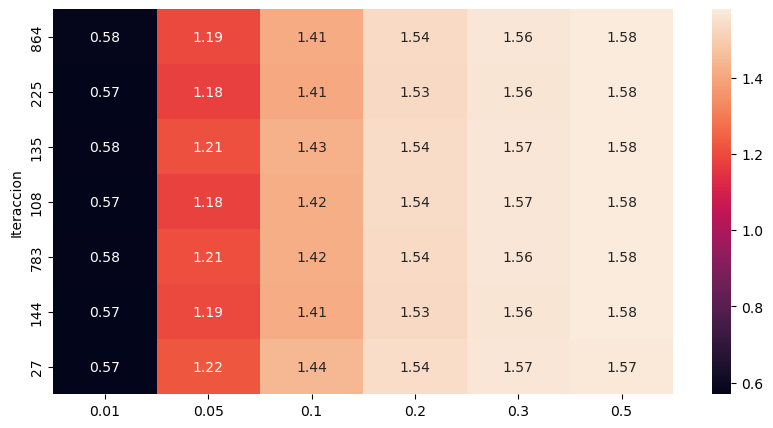

In [39]:
# sin eda train
plt.figure(figsize = (10,5))
sns.heatmap(summary, annot=True,  fmt=".2f")

<Axes: ylabel='Iteraccion'>

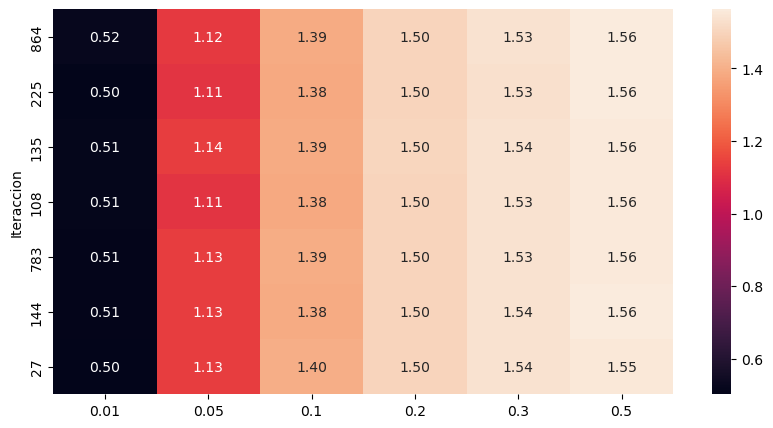

In [47]:
# sin eda test
plt.figure(figsize = (10,5))
sns.heatmap(summary_test, annot=True,  fmt=".2f")

In [ ]:
# con eda
plt.figure(figsize = (10,5))
sns.heatmap(summary, annot=True,  fmt=".2f")

In [ ]:
# con eda test
plt.figure(figsize = (10,5))
sns.heatmap(summary_test, annot=True,  fmt=".2f")

<Axes: ylabel='Iteraccion'>

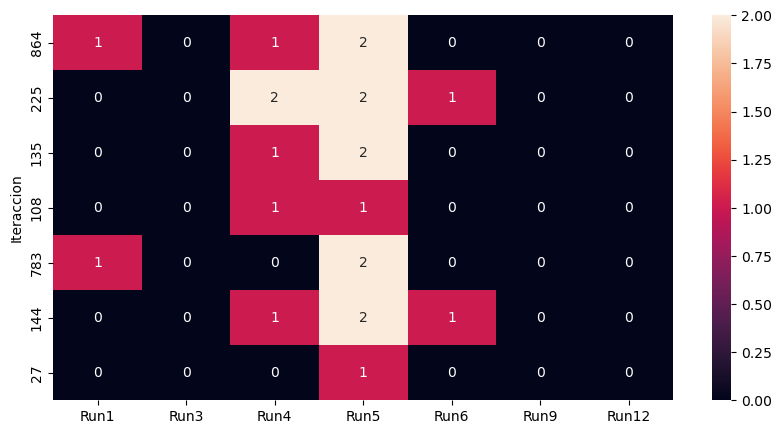

In [40]:
# sin eda
plt.figure(figsize = (10,5))
sns.heatmap(combinaciones.loc[summary.index],annot=True)

In [ ]:
# con eda
plt.figure(figsize = (10,5))
sns.heatmap(combinaciones.loc[summary.index],annot=True)

In [ ]:
# mejor modelo
check_df

In [ ]:
# MVP2
check_df_mvp2

In [ ]:
# ensamble sin optimizar
check_df_cientifico

In [ ]:
print(info_save2[3]['model_name'])
print(info_save2[3]['name_model'])

In [81]:
#info_save_select_ensamble = catalog.load("info_save_select") # modelo generado
print('Run_name: ',info_save_select_ensamble['modelo_produccion']['nodos_select'])
print('W: ',info_save_select_ensamble['modelo_produccion']['weights'])
check_df_opt = info_save_select_ensamble['select_model2']
check_df_opt = check_df_opt[np.in1d(check_df_opt.index.get_level_values(1),['backtest','recall n_top','Precision  n_top','f1-score n_top'])].reset_index() 
check_df_opt = check_df_opt[check_df_opt['class_name'].isin([1,1.0,'1','1.0'])]
check_df_opt = check_df_opt.set_index(['metric_name','dataset_name','class_name','select_model','name_model']).sort_index()
check_df_opt
check_df_opt

Run_name:  [3, 4]
W:  [1, 2]


value  \
metric_name    dataset_name class_name select_model        name_model           
backtest       test         1          best_fitting_model  Run1        0.5031   
                                       best_model_name     Run3        0.4997   
                                       best_unbiased_model Run3        0.4997   
                                       modelo_produccion   [3, 4]      0.5123   
               train        1          best_fitting_model  Run1        0.5109   
                                       best_model_name     Run3         0.499   
                                       best_unbiased_model Run3         0.499   
                                       modelo_produccion   [3, 4]      0.5223   
f1-score n_top test         1          best_fitting_model  Run1        1.0012   
                                       best_model_name     Run3        0.9944   
                                       best_unbiased_model Run3        0.9944   
                                       modelo_produccion   [3, 4]      1.0193   
               train        1          best_fitting_model  Run1        1.0165   
                                       best_model_name     Run3         0.993   
                                       best_unbiased_model Run3         0.993   
                                       modelo_produccion   [3, 4]      1.0391   
recall n_top   test         1          best_fitting_model  Run1         100.0   
                                       best_model_name     Run3         100.0   
                                       best_unbiased_model Run3         100.0   
                                       modelo_produccion   [3, 4]       100.0   
               train        1          best_fitting_model  Run1         100.0   
                                       best_model_name     Run3         100.0   
                                       best_unbiased_model Run3         100.0   
                                       modelo_produccion   [3, 4]       100.0   

                                                                            model_name  
metric_name    dataset_name class_name select_model        name_model                   
backtest       test         1          best_fitting_model  Run1                  MLP_0  
                                       best_model_name     Run3        random_forest_2  
                                       best_unbiased_model Run3        random_forest_2  
                                       modelo_produccion   [3, 4]             Ensamble  
               train        1          best_fitting_model  Run1                  MLP_0  
                                       best_model_name     Run3        random_forest_2  
                                       best_unbiased_model Run3        random_forest_2  
                                       modelo_produccion   [3, 4]             Ensamble  
f1-score n_top test         1          best_fitting_model  Run1                  MLP_0  
                                       best_model_name     Run3        random_forest_2  
                                       best_unbiased_model Run3        random_forest_2  
                                       modelo_produccion   [3, 4]             Ensamble  
               train        1          best_fitting_model  Run1                  MLP_0  
                                       best_model_name     Run3        random_forest_2  
                                       best_unbiased_model Run3        random_forest_2  
                                       modelo_produccion   [3, 4]             Ensamble  
recall n_top   test         1          best_fitting_model  Run1                  MLP_0  
                                       best_model_name     Run3        random_forest_2  
                                       best_unbiased_model Run3        random_forest_2  
                                       modelo_produccion   [3, 4]             Ensamble  
       

## backtesting

In [55]:
#info_save_select = catalog.load("info_save_select") # dio mejor en el backtesting
info_save_select = info_save_select_ensamble.copy()
print('Run_name: ',info_save_select['modelo_produccion']['nodos_select'])
print('W: ',info_save_select['modelo_produccion']['weights'])
check_df_opt = info_save_select_ensamble['select_model2']
check_df_opt = check_df_opt[np.in1d(check_df_opt.index.get_level_values(1),['backtest'])].reset_index() 
check_df_opt = check_df_opt.set_index(['select_model','name_model','dataset_name','class_name']).sort_index()
check_df_opt

Run_name:  [3, 4]
W:  [1, 2]


metric_name   value  \
select_model        name_model dataset_name class_name                       
best_fitting_model  Run1       test         1             backtest  0.5031   
                               train        1             backtest  0.5109   
best_model_name     Run3       test         1             backtest  0.4997   
                               train        1             backtest   0.499   
best_unbiased_model Run3       test         1             backtest  0.4997   
                               train        1             backtest   0.499   
modelo_produccion   [3, 4]     test         1             backtest  0.5123   
                               train        1             backtest  0.5223   

                                                             model_name  
select_model        name_model dataset_name class_name                   
best_fitting_model  Run1       test         1                     MLP_0  
                               train        1                     MLP_0  
best_model_name     Run3       test         1           random_forest_2  
                               train        1           random_forest_2  
best_unbiased_model Run3       test         1           random_forest_2  
                               train        1           random_forest_2  
modelo_produccion   [3, 4]     test         1                  Ensamble  
                               train        1                  Ensamble

In [82]:
try:
    display(info_save_select["modelo_produccion"]['Scaler'].reindex_OneHotEncoding)
    display(info_save_select["modelo_produccion"]['ks_test'])
    display(info_save_select["modelo_produccion"]['ks_train'])
except:
    display(info_save_select[info_save_select["modelo_produccion"]['nodos_select'][0]]['Scaler'].reindex_OneHotEncoding)

REINDEX     generacion  \
llave                                                                          
0                                      generacion__centennial    _millennial   
1                                    generacion__generacion_x  _generacion_x   
2                                      generacion__millennial    _centennial   
3                                      departamento_antioquia            NaN   
4                                         departamento_arauca            NaN   
5           departamento_archipielago_de_san_andres_provid...            NaN   
6                                      departamento_atlantico            NaN   
7                                    departamento_bogota_d_c_            NaN   
8                                        departamento_bolivar            NaN   
9                                         departamento_boyaca            NaN   
10                                        departamento_caldas            NaN   
11                                       departamento_caqueta            NaN   
12                                      departamento_casanare            NaN   
13                                         departamento_cauca            NaN   
14                                         departamento_cesar            NaN   
15                                         departamento_choco            NaN   
16                                       departamento_cordoba            NaN   
17                                  departamento_cundinamarca            NaN   
18                                       departamento_guainia            NaN   
19                                      departamento_guaviare            NaN   
20                                         departamento_huila            NaN   
21                                    departamento_la_guajira            NaN   
22                                     departamento_magdalena            NaN   
23                                          departamento_meta            NaN   
24                                        departamento_narino            NaN   
25                            departamento_norte_de_santander            NaN   
26                                      departamento_putumayo            NaN   
27                                       departamento_quindio            NaN   
28                                     departamento_risaralda            NaN   
29                                     departamento_santander            NaN   
30                                         departamento_sucre            NaN   
31                                        departamento_tolima            NaN   
32                               departamento_valle_del_cauca            NaN   
33                                        departamento_vaupes            NaN   
34                                       departamento_vichada            NaN   
DROP_FIRST                                                NaN   _baby_boomer   

                                        departamento  
llave                                                 
0                                          atlantico  
1                                               meta  
2                                             narino  
3                                 norte_de_santander  
4                                        bogota_d_c_  
5                                          antioquia  
6                                              cesar  
7                                       cundinamarca  
8                                              sucre  
9                                           putumayo  
10                                           bolivar  
11          archipielago_de_san_andres_providencia_y  
12                                            tolima  
13                                            boyaca  
14                                   valle_del_cauca  
15                                           cordoba  
16                     

In [83]:
print(info_save_select["modelo_produccion"]["model_name"])
print(info_save_select["modelo_produccion"]["name_model"])
if info_save_select["modelo_produccion"]["model_name"] == "Ensamble":
    print(info_save_select["modelo_produccion"]["nodos_select"])
    print(info_save_select["modelo_produccion"]["weights"])

Ensamble

[3, 4]
[1, 2]


In [ ]:
save_backtesting = catalog.load("data_backtesting")

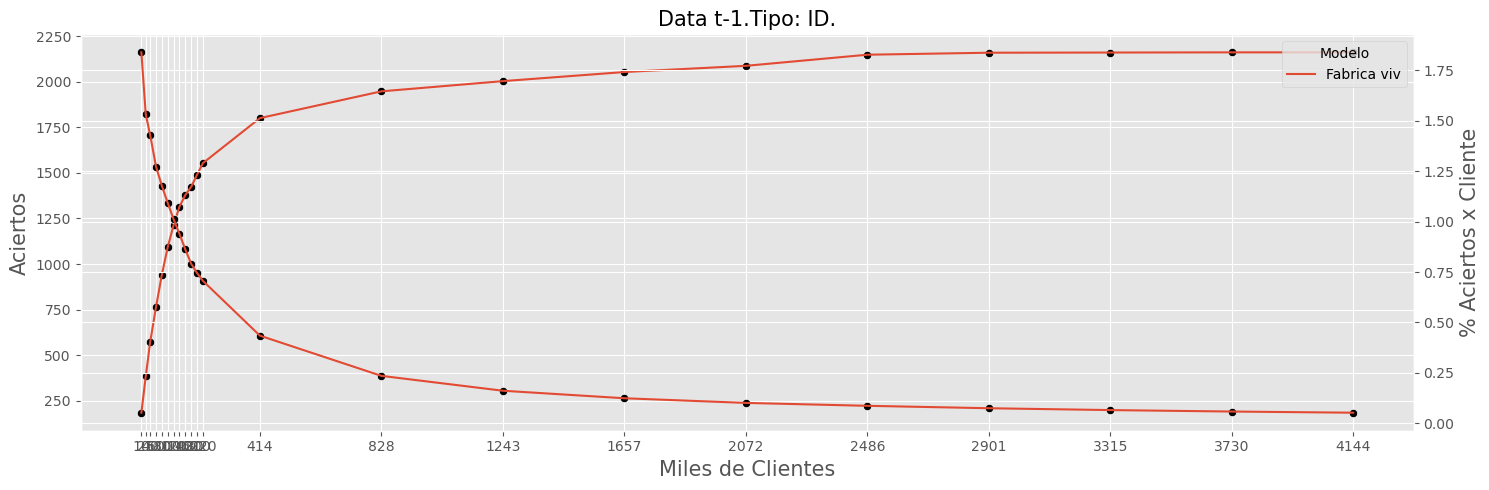

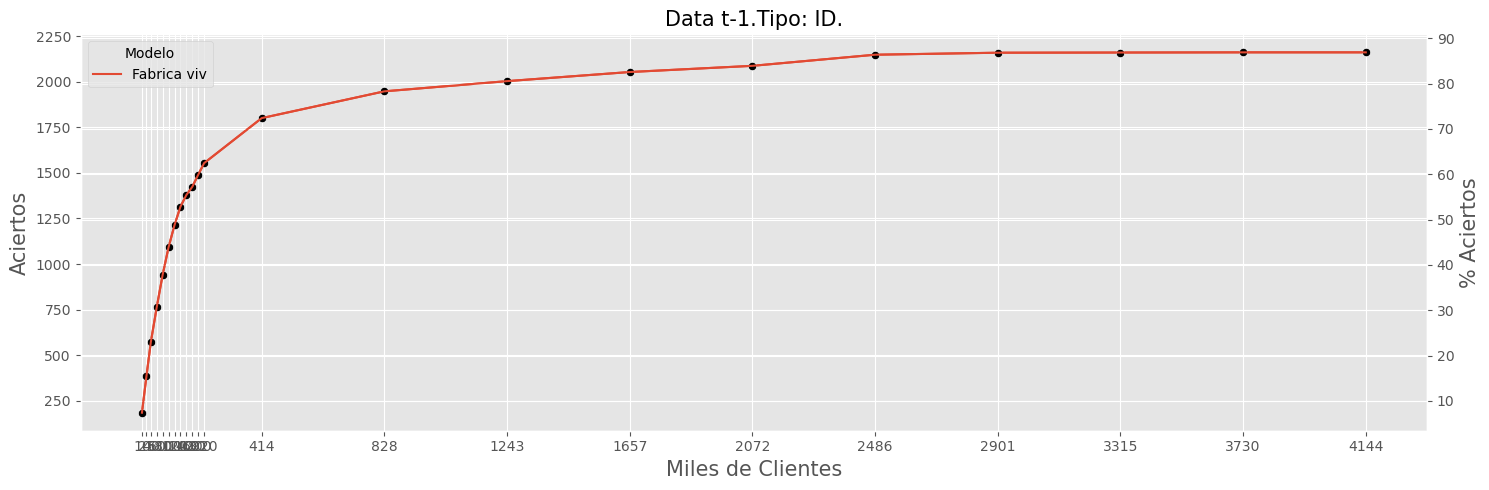

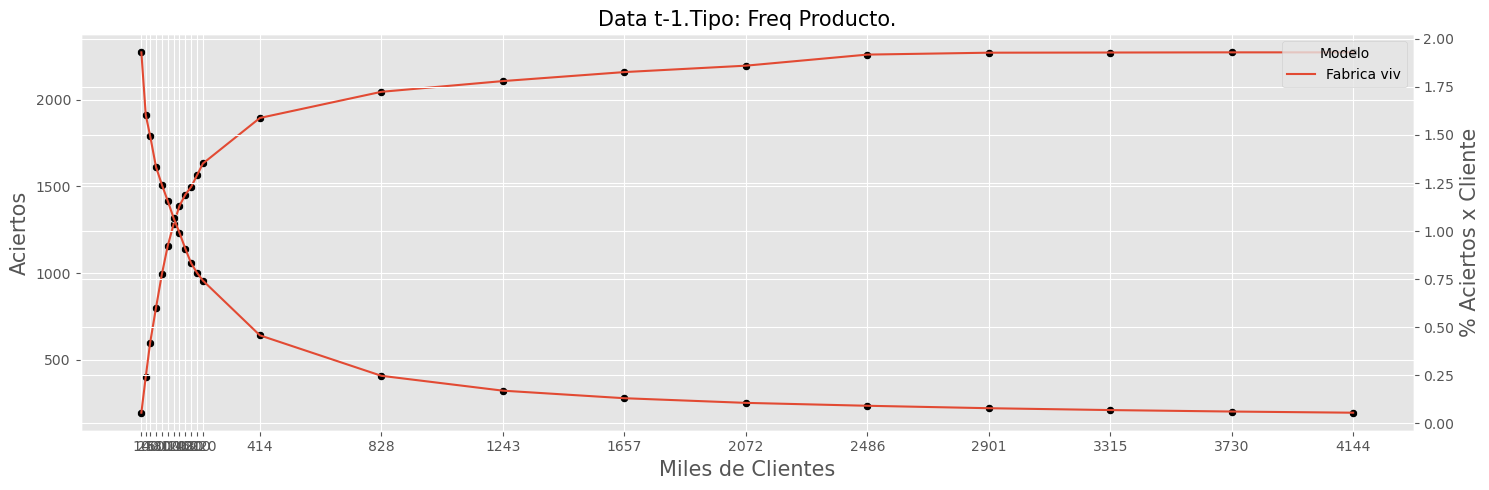

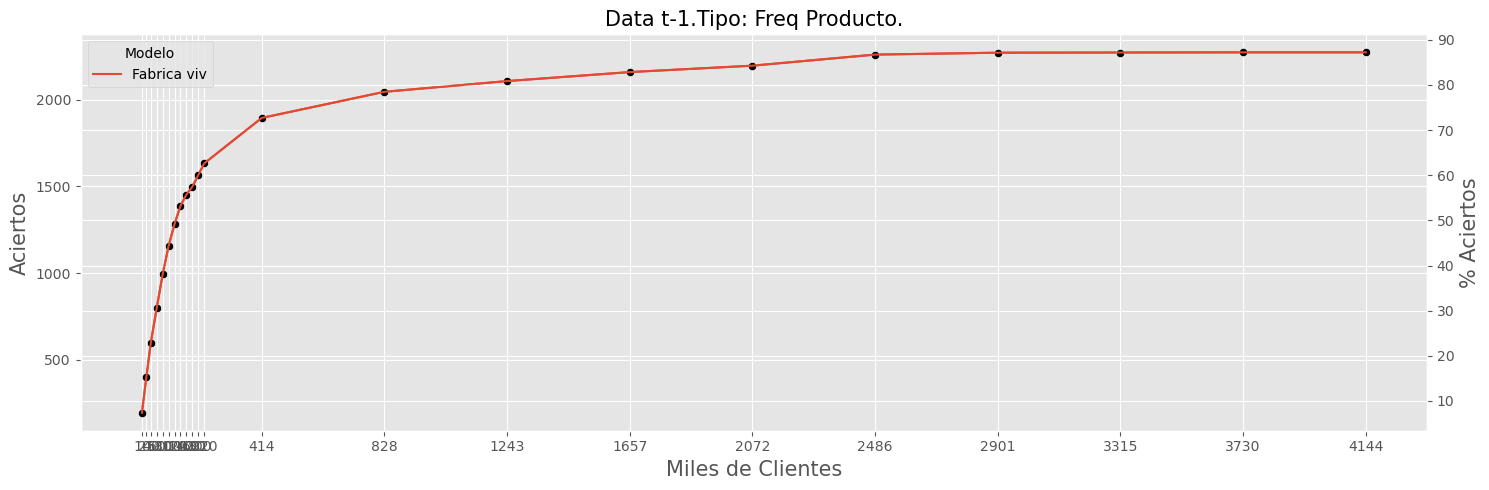

[02/07/25 16:39:12] INFO     ---------------------------------------------------                       ]8;id=388670;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=704688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#314\314]8;;\

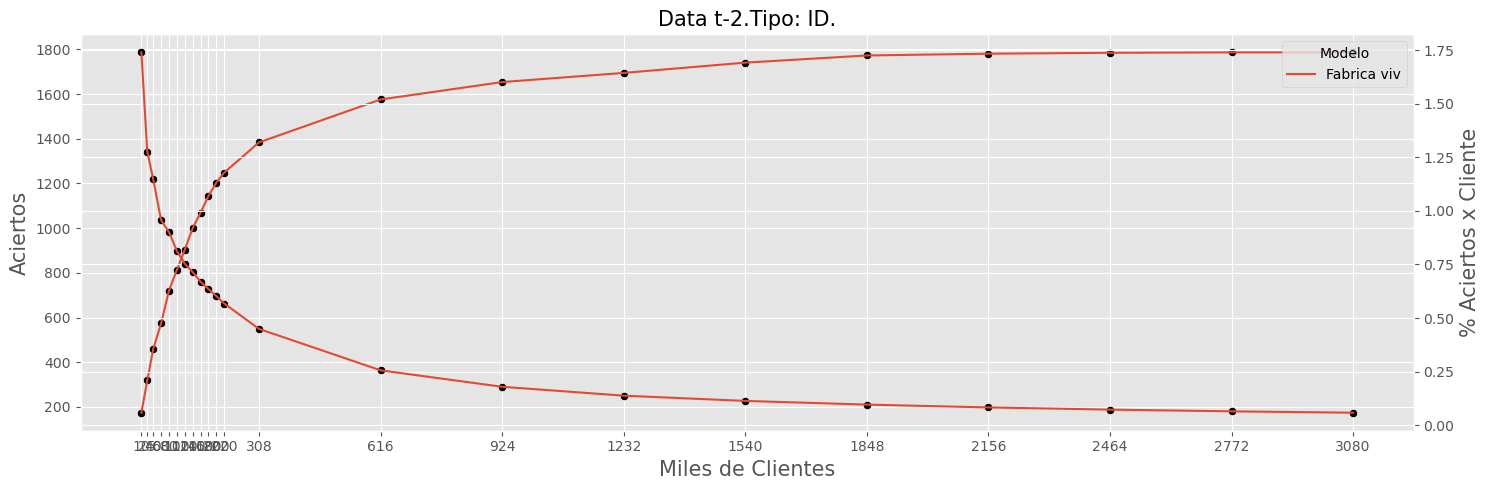

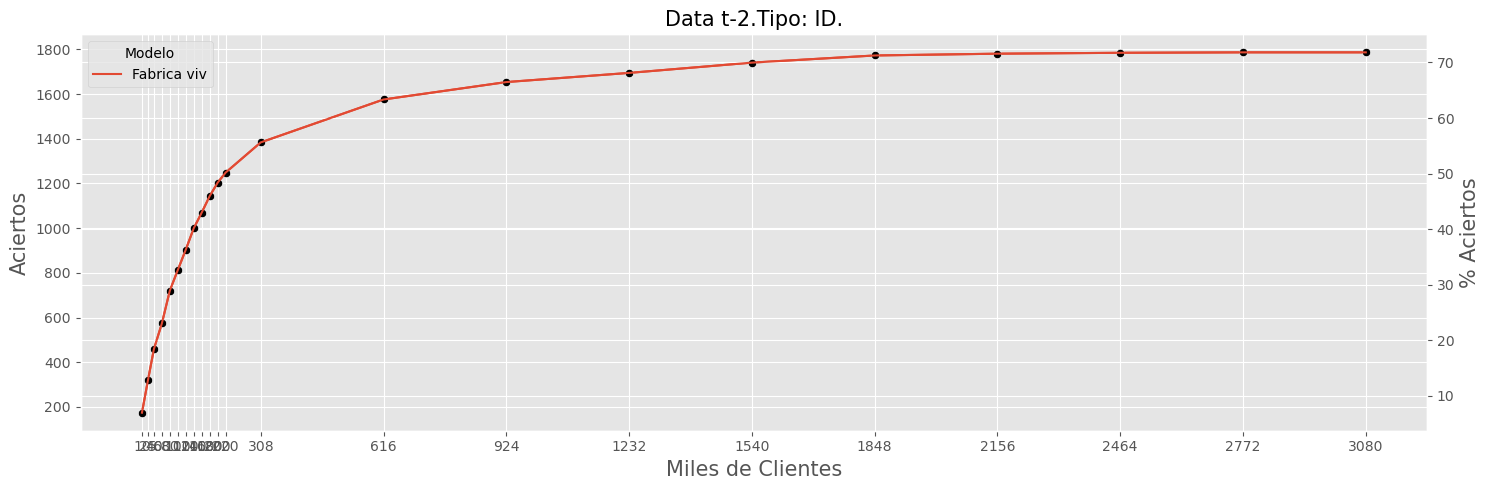

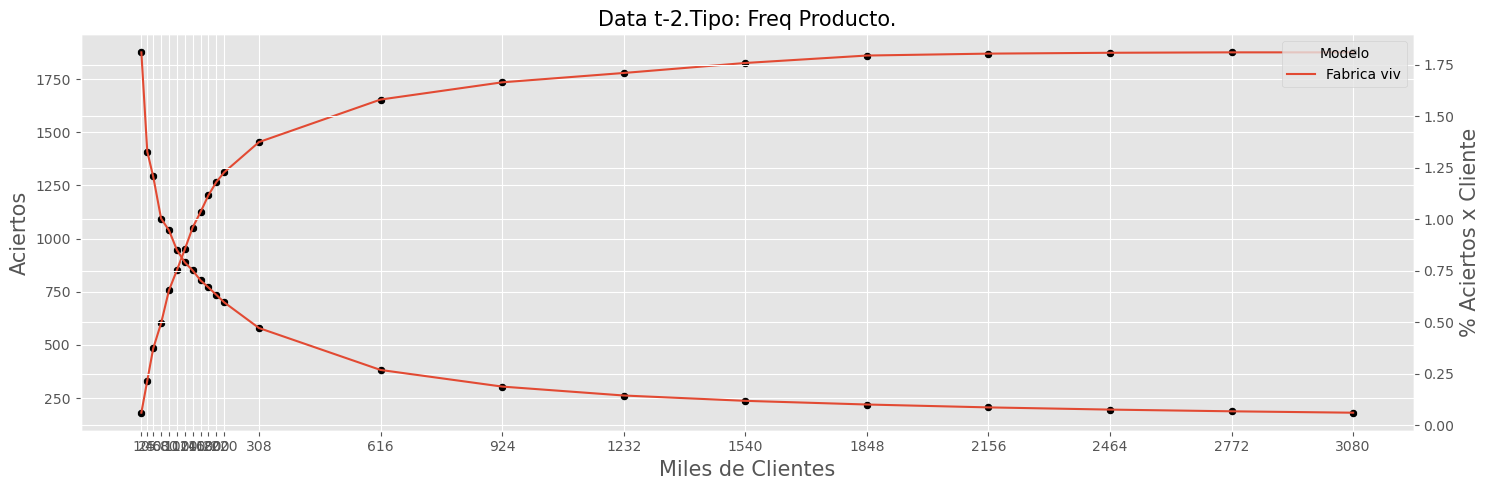

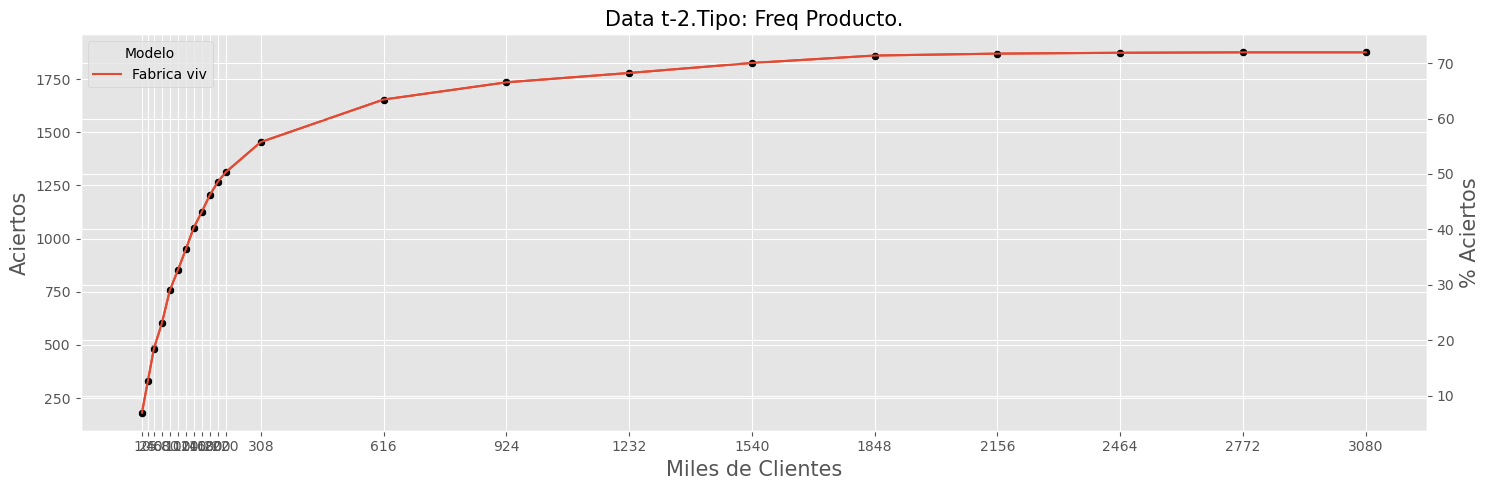

[02/07/25 16:39:14] INFO     ---------------------------------------------------                       ]8;id=946473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=635316;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#314\314]8;;\

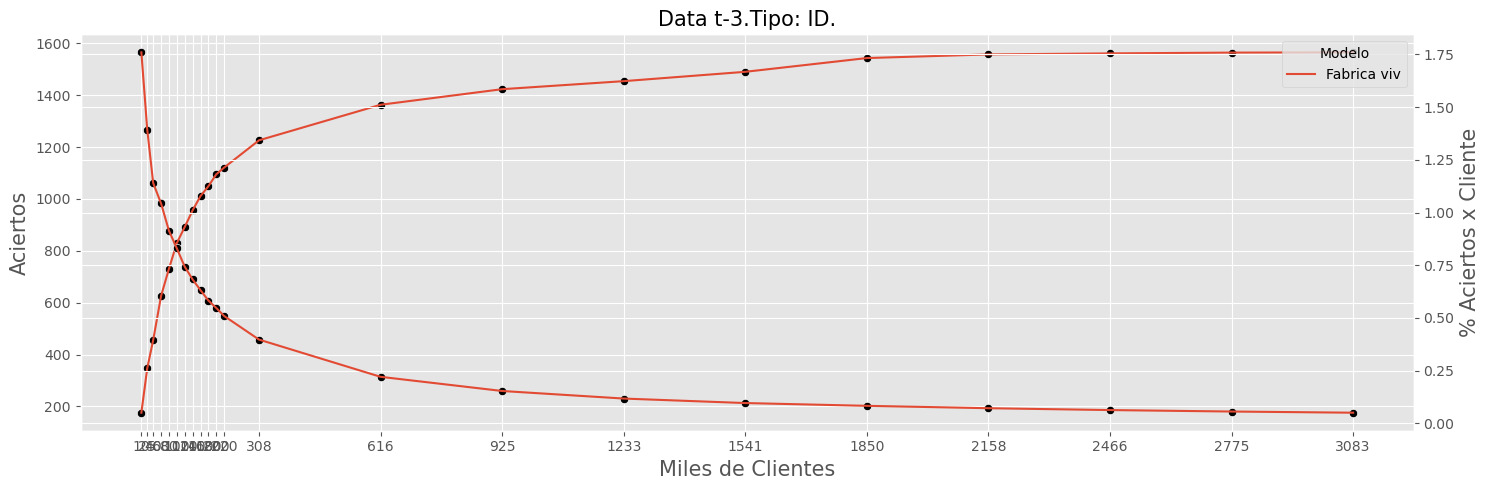

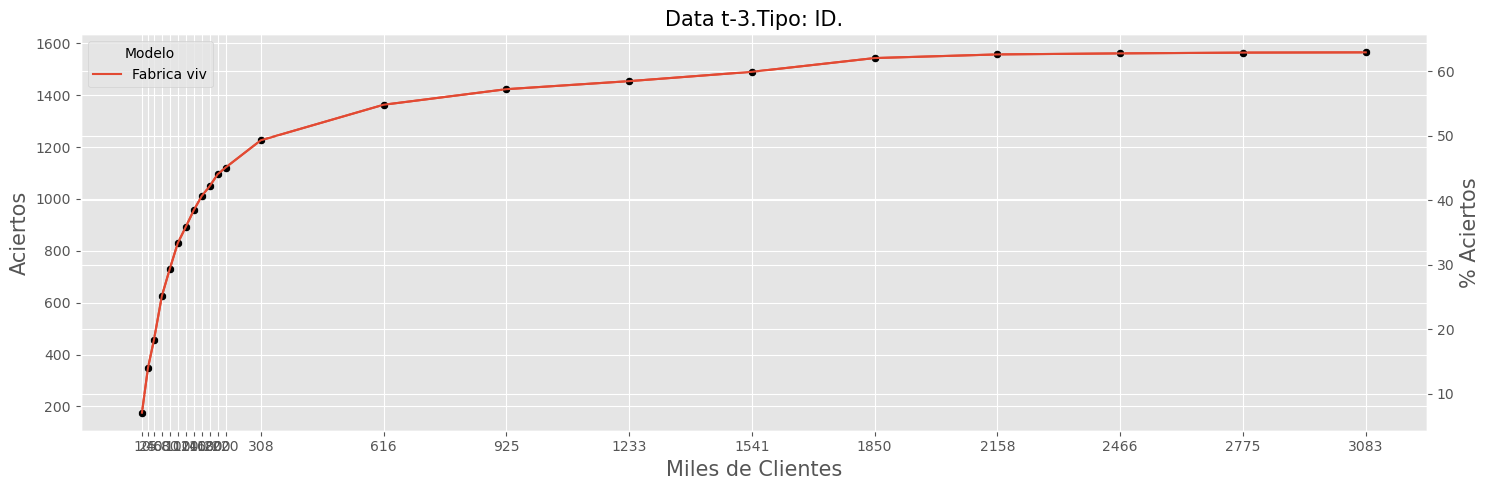

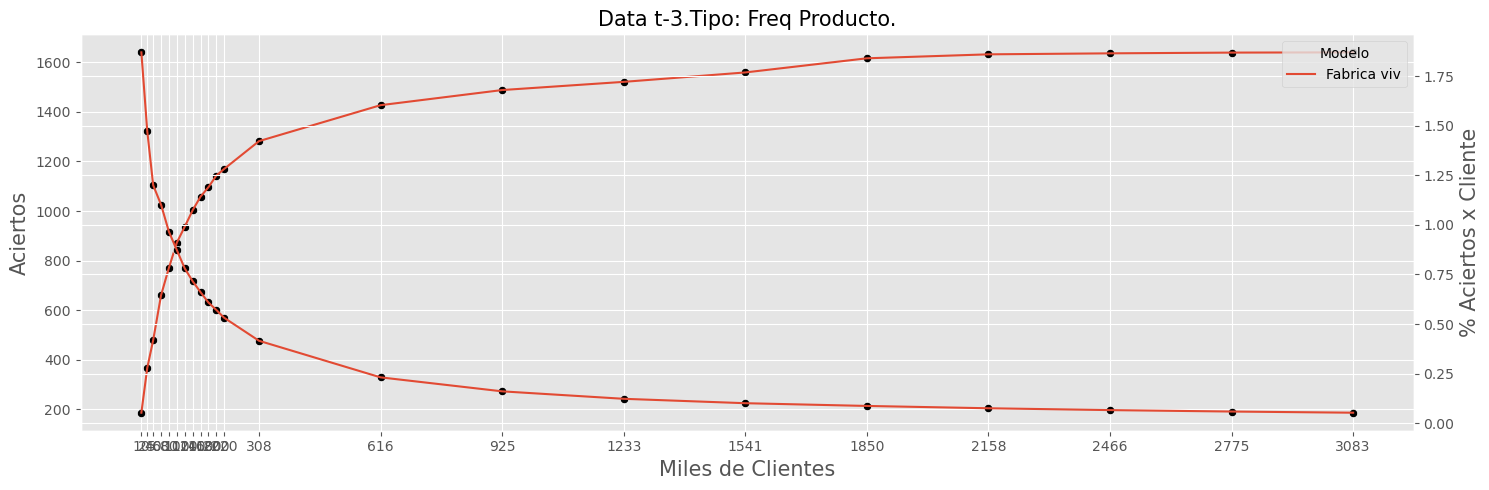

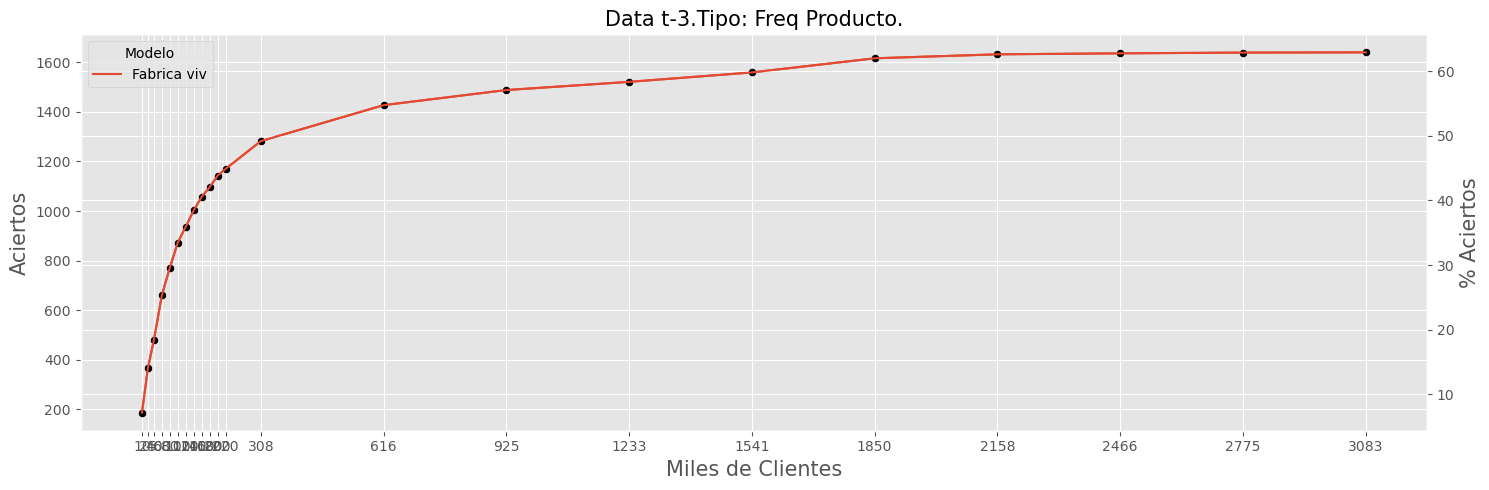

[02/07/25 16:39:15] INFO     ---------------------------------------------------                       ]8;id=801309;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=770321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#314\314]8;;\

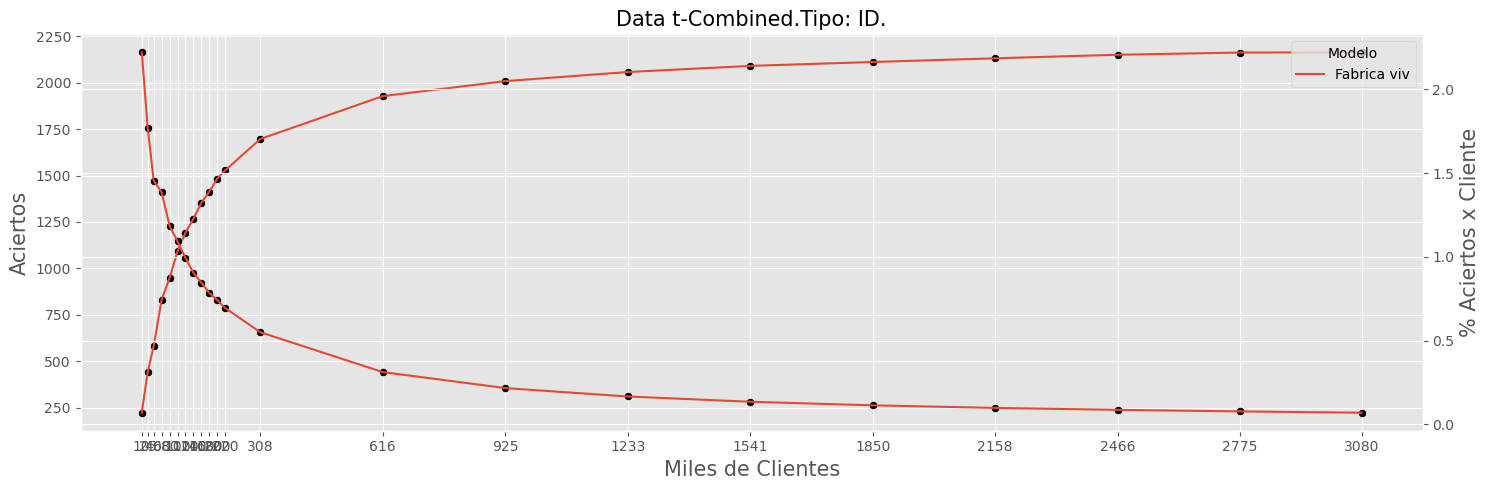

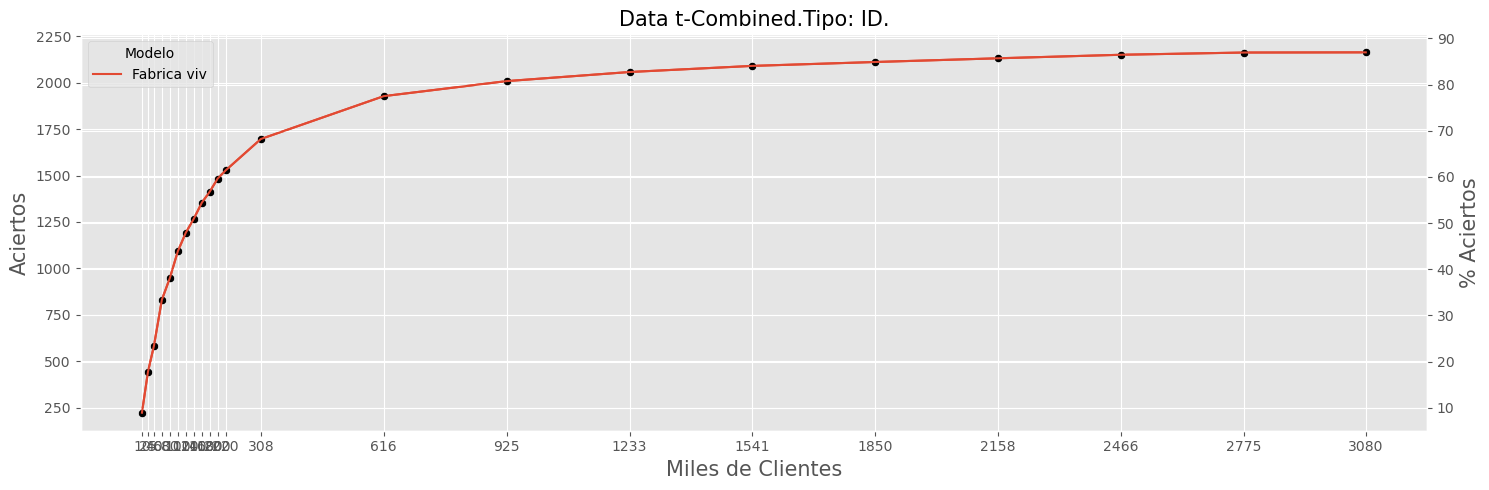

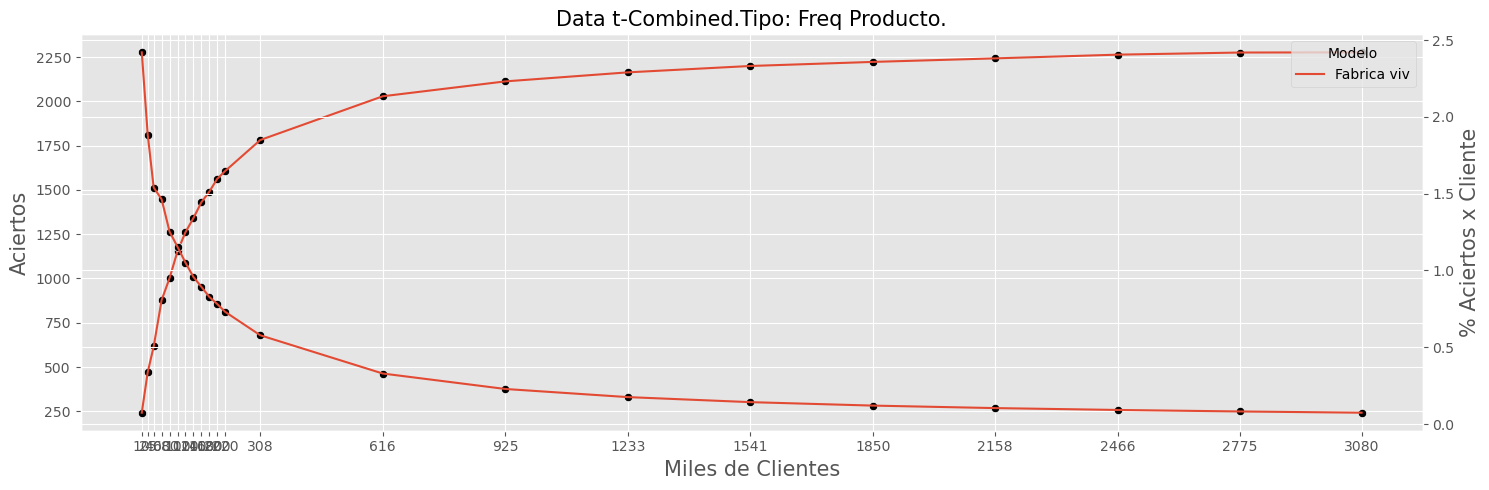

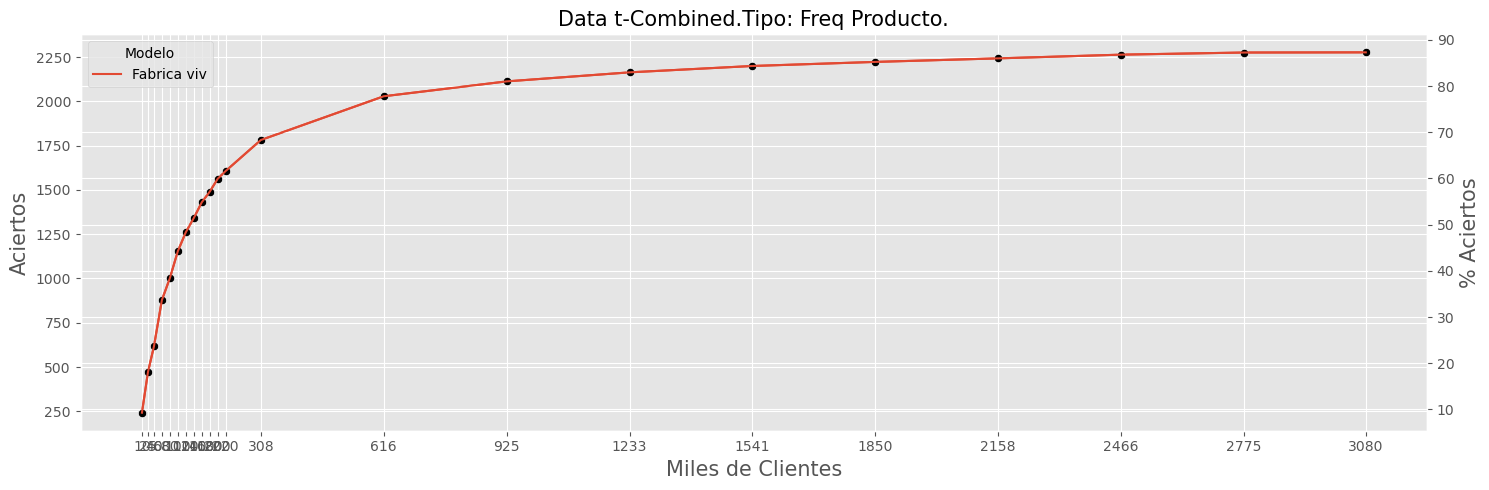

[02/07/25 16:39:17] INFO     ---------------------------------------------------                       ]8;id=19676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=150876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#314\314]8;;\

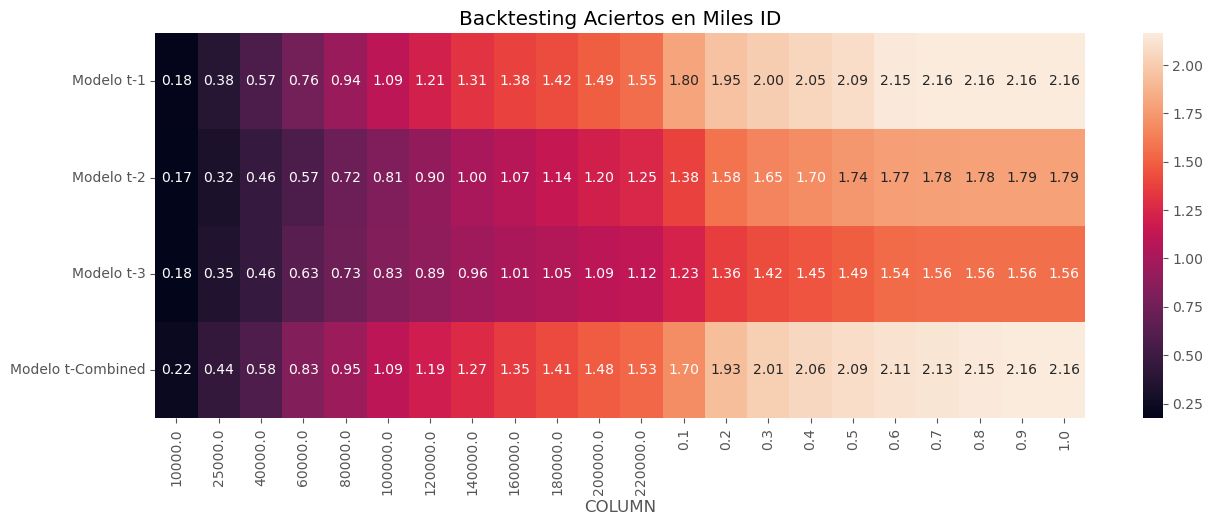

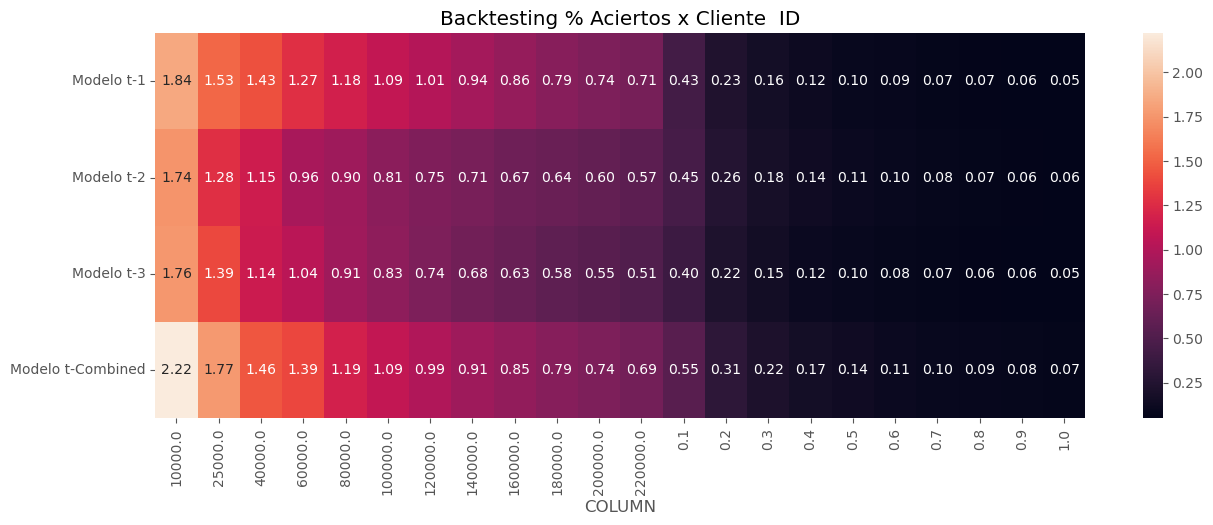

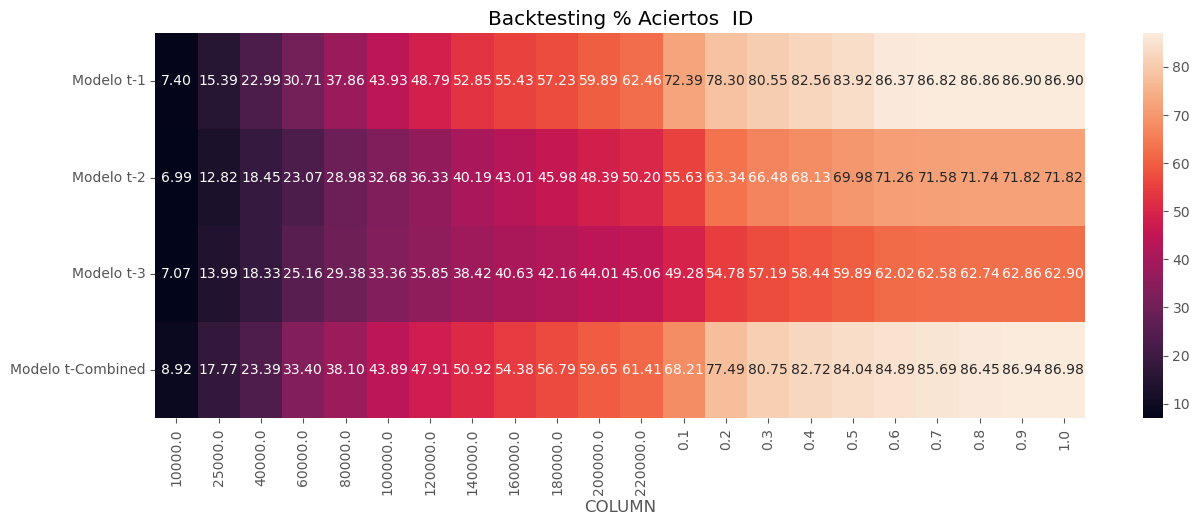

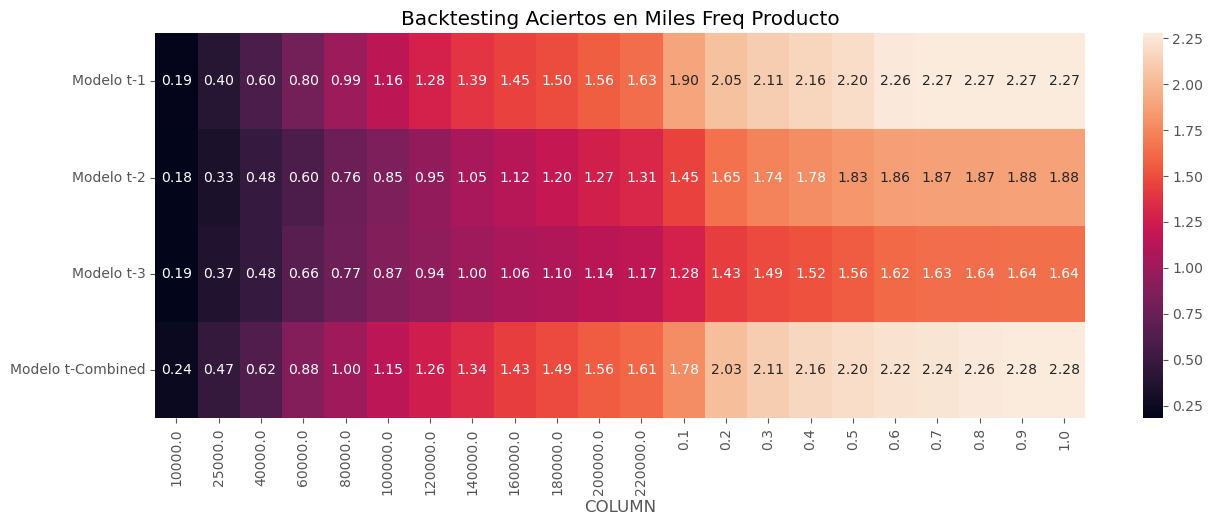

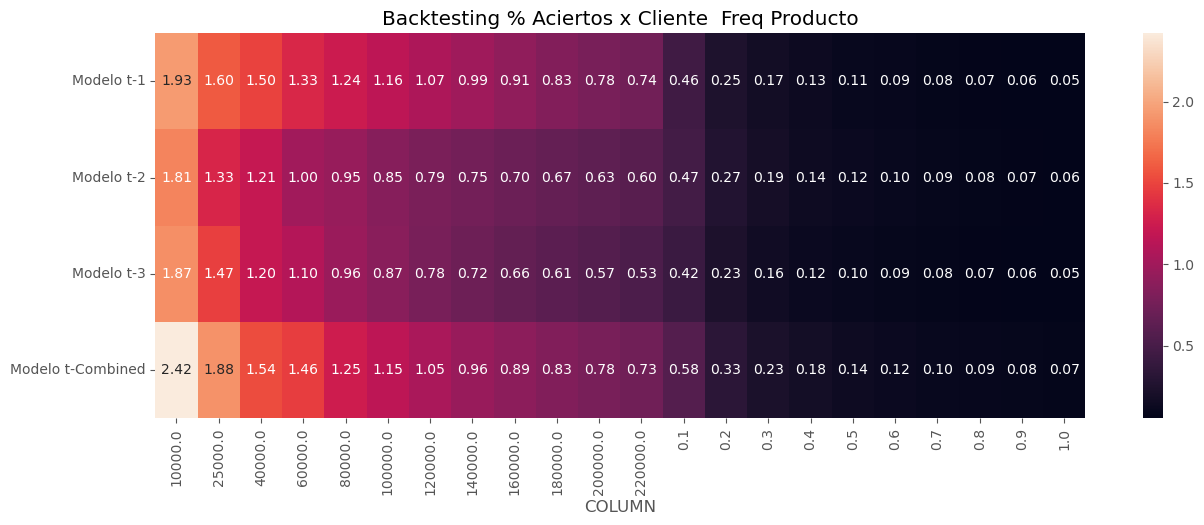

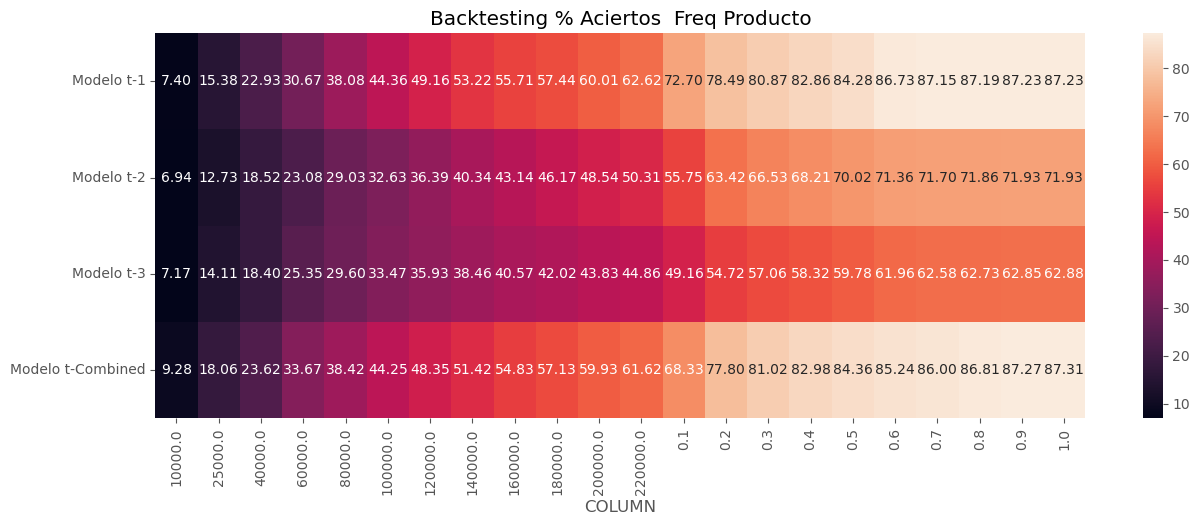

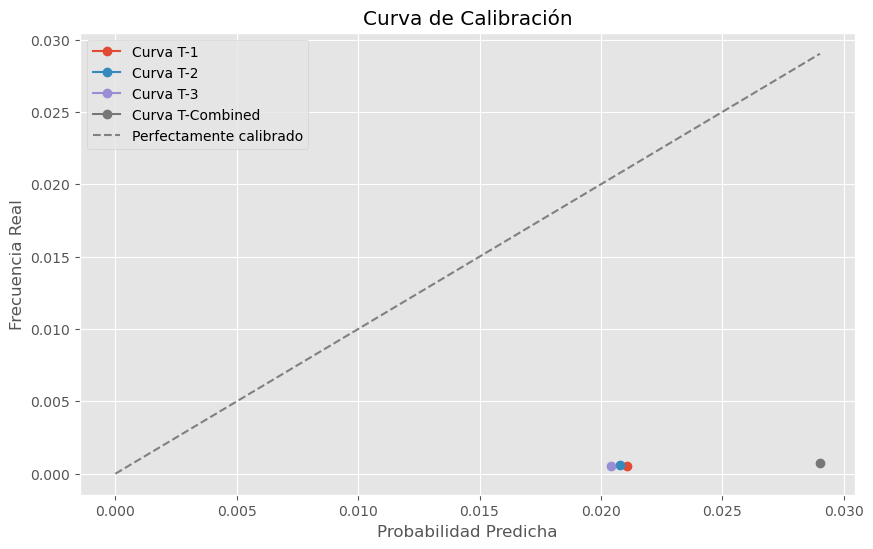

In [27]:
backtesting.plotear_curvas_rezago(save_backtesting, params)
plt.figure(figsize=(10, 6))
max_value = 0
for i in save_backtesting.keys():
    prob_true = save_backtesting[i]['prob_true']
    prob_pred = save_backtesting[i]['prob_pred']
    # Graficar la curva de calibración
    try:
        msg = str(int(i))
    except:
        msg = str(i)
    plt.plot(prob_pred, prob_true, marker='o', label='Curva'+" T-"+msg)
    max_value = np.max([max_value,np.max(prob_pred)])
plt.plot([0, max_value], [0, max_value], linestyle='--', color='gray', label='Perfectamente calibrado')
plt.title('Curva de Calibración')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Frecuencia Real')
plt.legend()
plt.show()
# curva > 45 grados = subestimar
# curva < 45 grados = sobrestimar

In [28]:
for i in save_backtesting.keys():
    print(i)
    res = save_backtesting[i]['metrics']
    display(res[res["metric_name"].isin(['No medible 1 %','N_top','f1-score','backtest_metric_ntop'])].drop('timestamp', axis=1))
    display(res[res["metric_name"].isin(['True negatives','True positives','False negatives','False positives'])])

1


model_name model_type dataset_name     metric_name     metric_type  \
12        VIV  Ensamble,       202411  No medible 1 %  overall metric   
17        VIV  Ensamble,       202411        f1-score  overall metric   
27        VIV  Ensamble,       202411        f1-score    class metric   
31        VIV  Ensamble,       202411        f1-score    class metric   

   class_name   value  
12    overall   1.976  
17    overall  0.1064  
27        0.0     0.0  
31        1.0  0.1064

timestamp model_name model_type dataset_name      metric_name  \
18  2025-02-07 16:33        VIV  Ensamble,       202411   True positives   
19  2025-02-07 16:33        VIV  Ensamble,       202411  False negatives   
20  2025-02-07 16:33        VIV  Ensamble,       202411   True negatives   
21  2025-02-07 16:33        VIV  Ensamble,       202411  False positives   

       metric_type class_name      value  
18  overall metric    overall     2162.0  
19  overall metric    overall        0.0  
20  overall metric    overall        0.0  
21  overall metric    overall  4060736.0

2


model_name model_type dataset_name     metric_name     metric_type  \
12        VIV  Ensamble,       202411  No medible 1 %  overall metric   
17        VIV  Ensamble,       202411        f1-score  overall metric   
27        VIV  Ensamble,       202411        f1-score    class metric   
31        VIV  Ensamble,       202411        f1-score    class metric   

   class_name   value  
12    overall  4.6115  
17    overall  0.1215  
27        0.0     0.0  
31        1.0  0.1215

timestamp model_name model_type dataset_name      metric_name  \
18  2025-02-07 16:33        VIV  Ensamble,       202411   True positives   
19  2025-02-07 16:33        VIV  Ensamble,       202411  False negatives   
20  2025-02-07 16:33        VIV  Ensamble,       202411   True negatives   
21  2025-02-07 16:33        VIV  Ensamble,       202411  False positives   

       metric_type class_name      value  
18  overall metric    overall     1787.0  
19  overall metric    overall        0.0  
20  overall metric    overall        0.0  
21  overall metric    overall  2937016.0

3


model_name model_type dataset_name     metric_name     metric_type  \
12        VIV  Ensamble,       202411  No medible 1 %  overall metric   
17        VIV  Ensamble,       202411        f1-score  overall metric   
27        VIV  Ensamble,       202411        f1-score    class metric   
31        VIV  Ensamble,       202411        f1-score    class metric   

   class_name   value  
12    overall  6.7717  
17    overall  0.1088  
27        0.0     0.0  
31        1.0  0.1088

timestamp model_name model_type dataset_name      metric_name  \
18  2025-02-07 16:33        VIV  Ensamble,       202411   True positives   
19  2025-02-07 16:33        VIV  Ensamble,       202411  False negatives   
20  2025-02-07 16:33        VIV  Ensamble,       202411   True negatives   
21  2025-02-07 16:33        VIV  Ensamble,       202411  False positives   

       metric_type class_name      value  
18  overall metric    overall     1565.0  
19  overall metric    overall        0.0  
20  overall metric    overall        0.0  
21  overall metric    overall  2873092.0

Combined


model_name model_type dataset_name     metric_name     metric_type  \
12        VIV  Ensamble,       202411  No medible 1 %  overall metric   
17        VIV  Ensamble,       202411        f1-score  overall metric   
27        VIV  Ensamble,       202411        f1-score    class metric   
31        VIV  Ensamble,       202411        f1-score    class metric   

   class_name   value  
12    overall  4.6349  
17    overall  0.1472  
27        0.0     0.0  
31        1.0  0.1472

timestamp model_name model_type dataset_name      metric_name  \
18  2025-02-07 16:34        VIV  Ensamble,       202411   True positives   
19  2025-02-07 16:34        VIV  Ensamble,       202411  False negatives   
20  2025-02-07 16:34        VIV  Ensamble,       202411   True negatives   
21  2025-02-07 16:34        VIV  Ensamble,       202411  False positives   

       metric_type class_name      value  
18  overall metric    overall     2164.0  
19  overall metric    overall        0.0  
20  overall metric    overall        0.0  
21  overall metric    overall  2935919.0

In [29]:
for i in save_backtesting.keys():
    print(i)
    res = save_backtesting[i]['ks']
    display(res)

1


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.28      4.16          414480           1801.0            0.43   
1      9      3.24      3.28          414480            147.0            0.04   
2      8      3.23      3.24          414040             56.0            0.01   
3      7      3.22      3.23          414909             50.0            0.01   
4      6      3.22      3.22          414490             34.0            0.01   
5      5      3.05      3.22          414480             61.0            0.01   
6      4      0.30      3.05          413878             11.0            0.00   
7      3      0.20      0.30          415053              1.0            0.00   
8      2      0.15      0.20          414508              1.0            0.00   
9      1      0.03      0.15          414480              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          83.30               10.00    73.30  
1          90.10               20.00    70.10  
2          92.69               29.99    62.70  
3          95.00               40.00    55.00  
4          96.58               50.00    46.58  
5          99.40               60.00    39.40  
6          99.91               69.99    29.92  
7          99.95               80.00    19.95  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

2


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.30      4.16          308084           1384.0            0.45   
1      9      3.24      3.30          308092            192.0            0.06   
2      8      3.23      3.24          308088             78.0            0.03   
3      7      3.23      3.23          308085             41.0            0.01   
4      6      3.21      3.23          308041             46.0            0.01   
5      5      1.18      3.21          308137             32.0            0.01   
6      4      0.35      1.18          302717              8.0            0.00   
7      3      0.23      0.35          313451              4.0            0.00   
8      2      0.17      0.23          308069              2.0            0.00   
9      1      0.04      0.17          308115              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          77.45               10.00    67.45  
1          88.19               20.00    68.19  
2          92.56               30.00    62.56  
3          94.85               40.00    54.85  
4          97.43               50.00    47.43  
5          99.22               60.00    39.22  
6          99.66               69.83    29.84  
7          99.89               80.00    19.89  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

3


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.27      4.16          308346             1226            0.40   
1      9      3.24      3.27          308346              137            0.04   
2      8      3.23      3.24          308333               60            0.02   
3      7      3.22      3.23          308359               31            0.01   
4      6      3.21      3.22          308346               36            0.01   
5      5      0.65      3.21          308346               53            0.02   
6      4      0.26      0.65          308116               14            0.00   
7      3      0.19      0.26          308576                4            0.00   
8      2      0.13      0.19          308339                3            0.00   
9      1      0.03      0.13          308353                1            0.00   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.34               10.00    68.34  
1          87.09               20.00    67.09  
2          90.93               30.00    60.93  
3          92.91               40.00    52.91  
4          95.21               50.00    45.21  
5          98.59               60.00    38.59  
6          99.49               69.99    29.50  
7          99.74               80.00    19.74  
8          99.94               90.00     9.94  
9         100.00              100.00     0.00

Combined


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.39      4.16          308088             1697            0.55   
1      9      3.27      3.39          308088              231            0.07   
2      8      3.24      3.27          308088               81            0.03   
3      7      3.24      3.24          308082               49            0.02   
4      6      3.23      3.24          308094               33            0.01   
5      5      3.23      3.23          307962               21            0.01   
6      4      3.22      3.23          308191               20            0.01   
7      3      3.13      3.22          308101               19            0.01   
8      2      0.75      3.13          308096               12            0.00   
9      1      0.35      0.75          308090                1            0.00   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.42                10.0    68.42  
1          89.09                20.0    69.09  
2          92.84                30.0    62.84  
3          95.10                40.0    55.10  
4          96.63                50.0    46.63  
5          97.60                60.0    37.60  
6          98.52                70.0    28.52  
7          99.40                80.0    19.40  
8          99.95                90.0     9.95  
9         100.00               100.0     0.00

## Comparar backtesting

In [8]:
data_backtesting1 = catalog.load("data_backtesting_202410")
data_backtesting2 = catalog.load("data_backtesting_202411")
data_backtesting3 = catalog.load("data_backtesting_202412")

[02/07/25 16:29:23] INFO     Loading data from 'data_backtesting_202410' (PickleDataSet)...     ]8;id=856733;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=799590;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[02/07/25 16:32:46] INFO     Loading data from 'data_backtesting_202411' (PickleDataSet)...     ]8;id=217139;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=795284;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[02/07/25 16:35:51] INFO     Loading data from 'data_backtesting_202412' (PickleDataSet)...     ]8;id=45195;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=393230;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [9]:
nametag_model = ['202410','202411','202412']
backtesting_all = [data_backtesting1,data_backtesting2,data_backtesting3]

dict_keys(['ID', 'Freq Producto'])


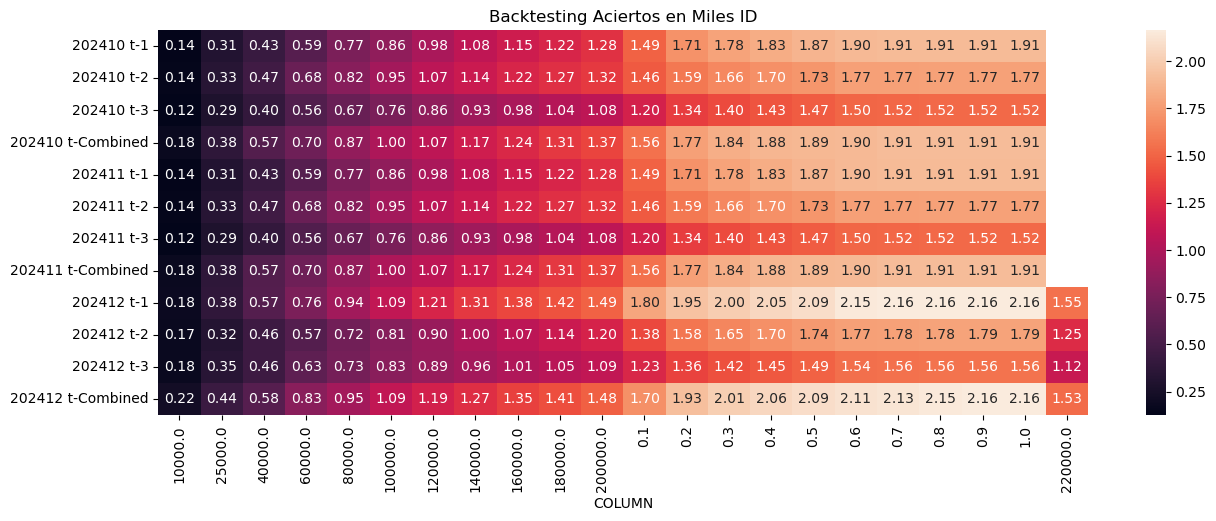

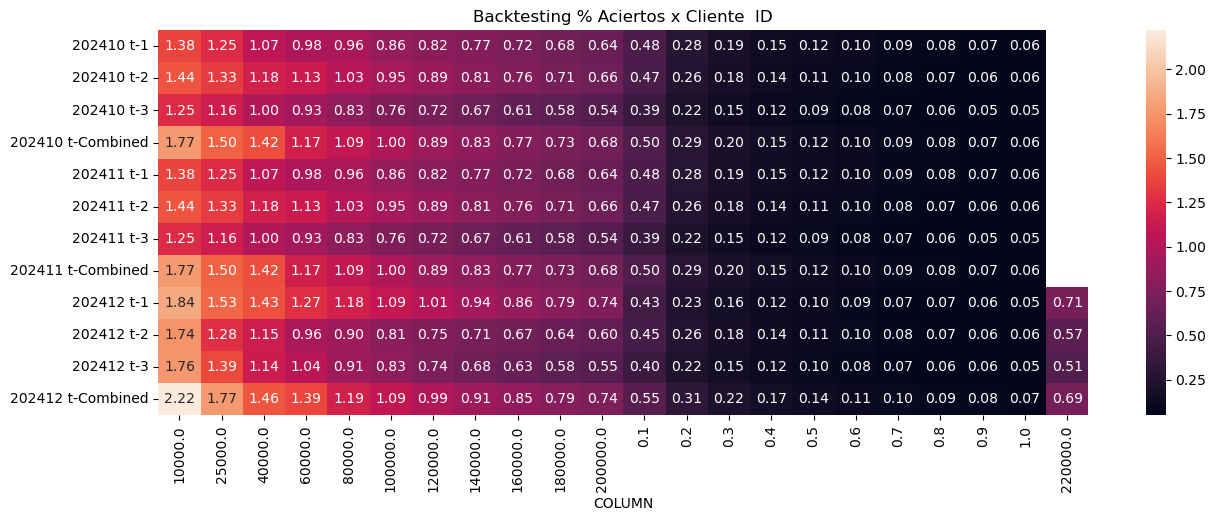

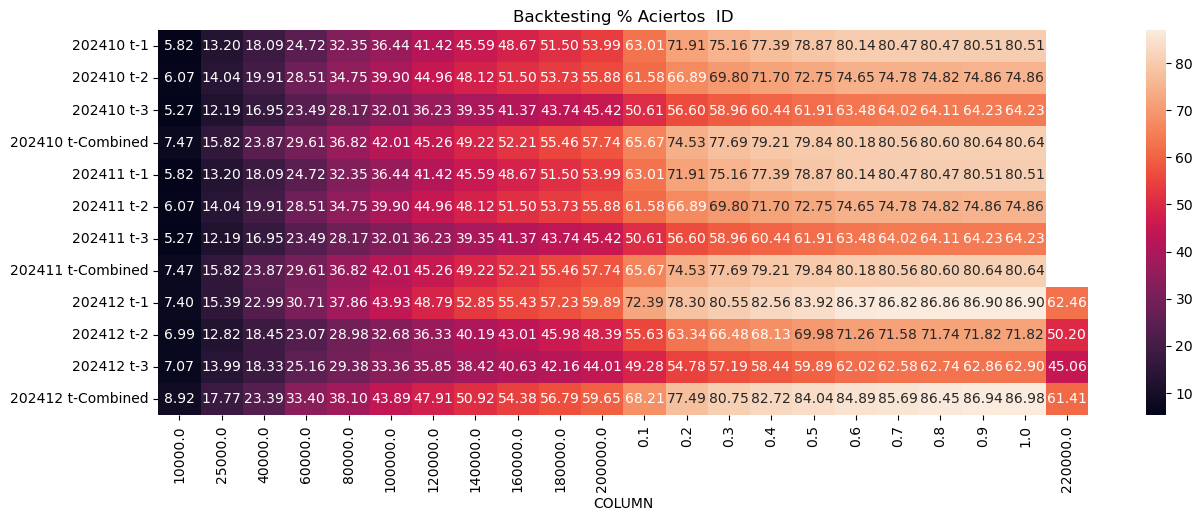

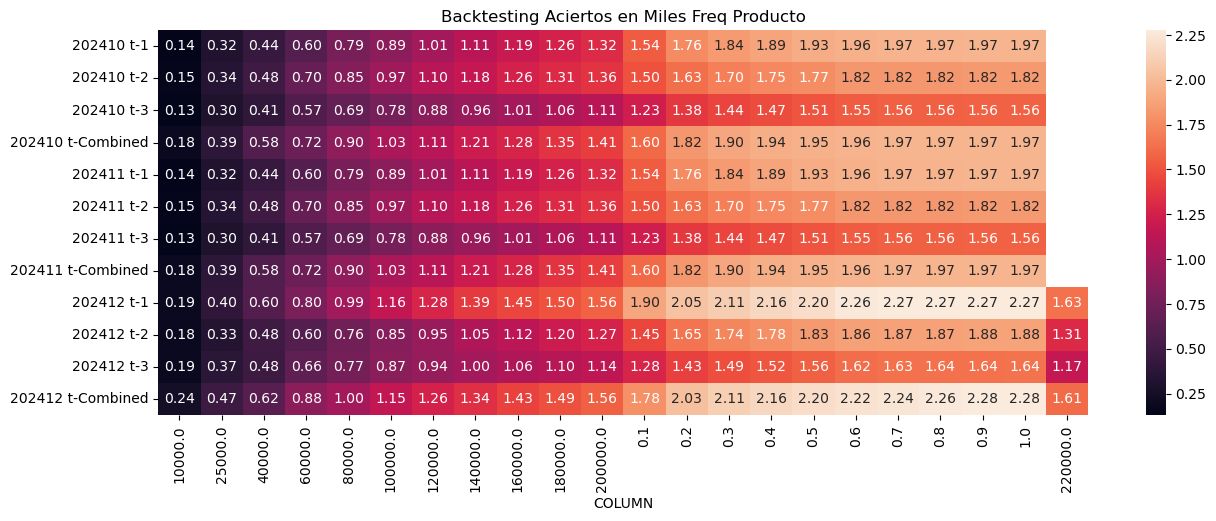

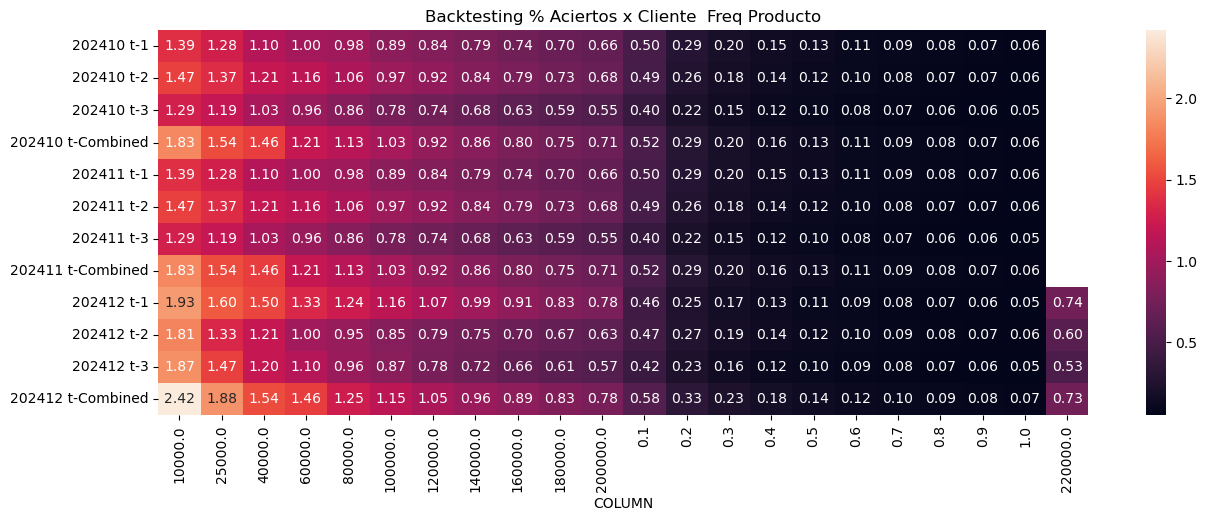

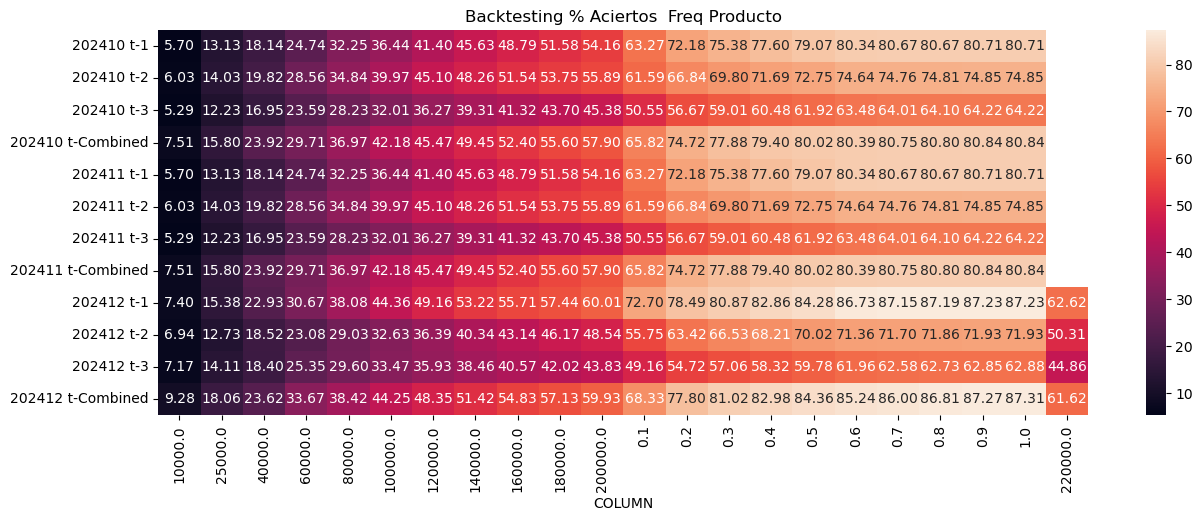

In [10]:
consolidacion_tipo = {}
for t,save_backtesting in enumerate(backtesting_all):
    for i in save_backtesting.keys():
        name = nametag_model[t]+' t-'+str(i)
        df_i = save_backtesting[i]['contactabilidad_curva']#.keys()
        df_i = df_i[~df_i['Aciertos'].isnull()]
        df_i = df_i.replace('Fabrica '+params['target'].split('_')[0],name)
        df_i = df_i[df_i['Modelo'] == name]
        for tipo in df_i['Tipo'].unique():
            df_ii = df_i[df_i['Tipo'] == tipo]
            df_ii = df_ii.set_index('COLUMN')
            if tipo not in consolidacion_tipo:
                consolidacion_tipo[tipo] = {'Aciertos': pd.DataFrame(),'% Aciertos x Cliente':pd.DataFrame(),'% Aciertos': pd.DataFrame()}
            for col in ['Aciertos','% Aciertos x Cliente','% Aciertos']:
                consolidacion_tipo[tipo][col] = pd.concat([consolidacion_tipo[tipo][col],df_ii[[col]].rename(columns = {col:name})], axis = 1)
print(consolidacion_tipo.keys())
import seaborn as sns
for col in list(consolidacion_tipo.keys()):
    for tipo in ['Aciertos','% Aciertos x Cliente','% Aciertos']:
        if tipo == 'Aciertos':
            graph = consolidacion_tipo[col][tipo].T/1000
            msj = f'Backtesting {tipo} en Miles {col}'
        else:
            graph = consolidacion_tipo[col][tipo].T
            msj = f'Backtesting {tipo}  {col}'
        plt.figure(figsize=(15,5))
        sns.heatmap(graph, annot = True, fmt= '0.02f')
        plt.title(msj)
        plt.show()

In [11]:
for t,save_backtesting in enumerate(backtesting_all):
    for i in save_backtesting.keys():
        name = nametag_model[t]+' t-'+str(i)
        print(name)
        res = save_backtesting[i]['ks']
        display(res)

202410 t-1


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.30      4.16          308084           1494.0            0.48   
1      9      3.24      3.30          308092            211.0            0.07   
2      8      3.23      3.24          308088             77.0            0.02   
3      7      3.23      3.23          308085             53.0            0.02   
4      6      3.21      3.23          308041             35.0            0.01   
5      5      1.18      3.21          308137             30.0            0.01   
6      4      0.35      1.18          302717              8.0            0.00   
7      3      0.23      0.35          313451              NaN             NaN   
8      2      0.17      0.23          308069              1.0            0.00   
9      1      0.04      0.17          308115              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.26               10.00    68.26  
1          89.31               20.00    69.31  
2          93.35               30.00    63.35  
3          96.12               40.00    56.12  
4          97.96               50.00    47.96  
5          99.53               60.00    39.53  
6          99.95               69.83    30.12  
7            NaN               80.00      NaN  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

202410 t-2


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.27      4.16          308346           1460.0            0.47   
1      9      3.24      3.27          308346            126.0            0.04   
2      8      3.23      3.24          308333             69.0            0.02   
3      7      3.22      3.23          308359             45.0            0.01   
4      6      3.21      3.22          308346             25.0            0.01   
5      5      0.65      3.21          308346             45.0            0.01   
6      4      0.26      0.65          308116              3.0            0.00   
7      3      0.19      0.26          308576              1.0            0.00   
8      2      0.13      0.19          308339              1.0            0.00   
9      1      0.03      0.13          308353              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          82.25               10.00    72.25  
1          89.35               20.00    69.35  
2          93.24               30.00    63.24  
3          95.77               40.00    55.77  
4          97.18               50.00    47.18  
5          99.72               60.00    39.72  
6          99.89               69.99    29.89  
7          99.94               80.00    19.94  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

202410 t-3


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.27      4.16          309230           1200.0            0.39   
1      9      3.24      3.27          309229            142.0            0.05   
2      8      3.23      3.24          309230             56.0            0.02   
3      7      3.22      3.23          309225             35.0            0.01   
4      6      3.21      3.22          309190             35.0            0.01   
5      5      0.61      3.21          309273             37.0            0.01   
6      4      0.26      0.61          308748             13.0            0.00   
7      3      0.19      0.26          309708              2.0            0.00   
8      2      0.13      0.19          309232              3.0            0.00   
9      1      0.03      0.13          309230              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.79               10.00    68.79  
1          88.12               20.00    68.12  
2          91.79               30.00    61.79  
3          94.09               40.00    54.09  
4          96.39               50.00    46.39  
5          98.82               60.00    38.82  
6          99.67               69.98    29.69  
7          99.80               80.00    19.80  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

202410 t-Combined


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.34      4.16          308088           1557.0            0.51   
1      9      3.25      3.34          308088            209.0            0.07   
2      8      3.24      3.25          308088             76.0            0.02   
3      7      3.23      3.24          308059             36.0            0.01   
4      6      3.22      3.23          308078             15.0            0.00   
5      5      3.07      3.22          308127              8.0            0.00   
6      4      0.42      3.07          308088              9.0            0.00   
7      3      0.28      0.42          308088              1.0            0.00   
8      2      0.20      0.28          306151              1.0            0.00   
9      1      0.15      0.20          310025              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          81.43               10.00    71.43  
1          92.36               20.00    72.36  
2          96.34               30.00    66.34  
3          98.22               40.00    58.22  
4          99.01               50.00    49.01  
5          99.42               60.00    39.42  
6          99.90               70.00    29.90  
7          99.95               80.00    19.95  
8         100.00               89.94    10.06  
9            NaN              100.00      NaN

202411 t-1


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.30      4.16          308084           1494.0            0.48   
1      9      3.24      3.30          308092            211.0            0.07   
2      8      3.23      3.24          308088             77.0            0.02   
3      7      3.23      3.23          308085             53.0            0.02   
4      6      3.21      3.23          308041             35.0            0.01   
5      5      1.18      3.21          308137             30.0            0.01   
6      4      0.35      1.18          302717              8.0            0.00   
7      3      0.23      0.35          313451              NaN             NaN   
8      2      0.17      0.23          308069              1.0            0.00   
9      1      0.04      0.17          308115              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.26               10.00    68.26  
1          89.31               20.00    69.31  
2          93.35               30.00    63.35  
3          96.12               40.00    56.12  
4          97.96               50.00    47.96  
5          99.53               60.00    39.53  
6          99.95               69.83    30.12  
7            NaN               80.00      NaN  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

202411 t-2


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.27      4.16          308346           1460.0            0.47   
1      9      3.24      3.27          308346            126.0            0.04   
2      8      3.23      3.24          308333             69.0            0.02   
3      7      3.22      3.23          308359             45.0            0.01   
4      6      3.21      3.22          308346             25.0            0.01   
5      5      0.65      3.21          308346             45.0            0.01   
6      4      0.26      0.65          308116              3.0            0.00   
7      3      0.19      0.26          308576              1.0            0.00   
8      2      0.13      0.19          308339              1.0            0.00   
9      1      0.03      0.13          308353              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          82.25               10.00    72.25  
1          89.35               20.00    69.35  
2          93.24               30.00    63.24  
3          95.77               40.00    55.77  
4          97.18               50.00    47.18  
5          99.72               60.00    39.72  
6          99.89               69.99    29.89  
7          99.94               80.00    19.94  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

202411 t-3


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.27      4.16          309230           1200.0            0.39   
1      9      3.24      3.27          309229            142.0            0.05   
2      8      3.23      3.24          309230             56.0            0.02   
3      7      3.22      3.23          309225             35.0            0.01   
4      6      3.21      3.22          309190             35.0            0.01   
5      5      0.61      3.21          309273             37.0            0.01   
6      4      0.26      0.61          308748             13.0            0.00   
7      3      0.19      0.26          309708              2.0            0.00   
8      2      0.13      0.19          309232              3.0            0.00   
9      1      0.03      0.13          309230              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.79               10.00    68.79  
1          88.12               20.00    68.12  
2          91.79               30.00    61.79  
3          94.09               40.00    54.09  
4          96.39               50.00    46.39  
5          98.82               60.00    38.82  
6          99.67               69.98    29.69  
7          99.80               80.00    19.80  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

202411 t-Combined


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.34      4.16          308088           1557.0            0.51   
1      9      3.25      3.34          308088            209.0            0.07   
2      8      3.24      3.25          308088             76.0            0.02   
3      7      3.23      3.24          308059             36.0            0.01   
4      6      3.22      3.23          308078             15.0            0.00   
5      5      3.07      3.22          308127              8.0            0.00   
6      4      0.42      3.07          308088              9.0            0.00   
7      3      0.28      0.42          308088              1.0            0.00   
8      2      0.20      0.28          306151              1.0            0.00   
9      1      0.15      0.20          310025              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          81.43               10.00    71.43  
1          92.36               20.00    72.36  
2          96.34               30.00    66.34  
3          98.22               40.00    58.22  
4          99.01               50.00    49.01  
5          99.42               60.00    39.42  
6          99.90               70.00    29.90  
7          99.95               80.00    19.95  
8         100.00               89.94    10.06  
9            NaN              100.00      NaN

202412 t-1


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.28      4.16          414480           1801.0            0.43   
1      9      3.24      3.28          414480            147.0            0.04   
2      8      3.23      3.24          414040             56.0            0.01   
3      7      3.22      3.23          414909             50.0            0.01   
4      6      3.22      3.22          414490             34.0            0.01   
5      5      3.05      3.22          414480             61.0            0.01   
6      4      0.30      3.05          413878             11.0            0.00   
7      3      0.20      0.30          415053              1.0            0.00   
8      2      0.15      0.20          414508              1.0            0.00   
9      1      0.03      0.15          414480              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          83.30               10.00    73.30  
1          90.10               20.00    70.10  
2          92.69               29.99    62.70  
3          95.00               40.00    55.00  
4          96.58               50.00    46.58  
5          99.40               60.00    39.40  
6          99.91               69.99    29.92  
7          99.95               80.00    19.95  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

202412 t-2


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.30      4.16          308084           1384.0            0.45   
1      9      3.24      3.30          308092            192.0            0.06   
2      8      3.23      3.24          308088             78.0            0.03   
3      7      3.23      3.23          308085             41.0            0.01   
4      6      3.21      3.23          308041             46.0            0.01   
5      5      1.18      3.21          308137             32.0            0.01   
6      4      0.35      1.18          302717              8.0            0.00   
7      3      0.23      0.35          313451              4.0            0.00   
8      2      0.17      0.23          308069              2.0            0.00   
9      1      0.04      0.17          308115              NaN             NaN   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          77.45               10.00    67.45  
1          88.19               20.00    68.19  
2          92.56               30.00    62.56  
3          94.85               40.00    54.85  
4          97.43               50.00    47.43  
5          99.22               60.00    39.22  
6          99.66               69.83    29.84  
7          99.89               80.00    19.89  
8         100.00               90.00    10.00  
9            NaN              100.00      NaN

202412 t-3


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.27      4.16          308346             1226            0.40   
1      9      3.24      3.27          308346              137            0.04   
2      8      3.23      3.24          308333               60            0.02   
3      7      3.22      3.23          308359               31            0.01   
4      6      3.21      3.22          308346               36            0.01   
5      5      0.65      3.21          308346               53            0.02   
6      4      0.26      0.65          308116               14            0.00   
7      3      0.19      0.26          308576                4            0.00   
8      2      0.13      0.19          308339                3            0.00   
9      1      0.03      0.13          308353                1            0.00   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.34               10.00    68.34  
1          87.09               20.00    67.09  
2          90.93               30.00    60.93  
3          92.91               40.00    52.91  
4          95.21               50.00    45.21  
5          98.59               60.00    38.59  
6          99.49               69.99    29.50  
7          99.74               80.00    19.74  
8          99.94               90.00     9.94  
9         100.00              100.00     0.00

202412 t-Combined


decil  prob_min  prob_max  total_clientes  total_aperturas  tasa_aperturas  \
0     10      3.39      4.16          308088             1697            0.55   
1      9      3.27      3.39          308088              231            0.07   
2      8      3.24      3.27          308088               81            0.03   
3      7      3.24      3.24          308082               49            0.02   
4      6      3.23      3.24          308094               33            0.01   
5      5      3.23      3.23          307962               21            0.01   
6      4      3.22      3.23          308191               20            0.01   
7      3      3.13      3.22          308101               19            0.01   
8      2      0.75      3.13          308096               12            0.00   
9      1      0.35      0.75          308090                1            0.00   

   cum_aperturas  cum_prob_esperadas  ks_stat  
0          78.42                10.0    68.42  
1          89.09                20.0    69.09  
2          92.84                30.0    62.84  
3          95.10                40.0    55.10  
4          96.63                50.0    46.63  
5          97.60                60.0    37.60  
6          98.52                70.0    28.52  
7          99.40                80.0    19.40  
8          99.95                90.0     9.95  
9         100.00               100.0     0.00

In [12]:
for t,save_backtesting in enumerate(backtesting_all):
    for i in save_backtesting.keys():
        name = nametag_model[t]+' t-'+str(i)
        print(name)
        res = save_backtesting[i]['metrics']
        display(res[res["metric_name"].isin(['No medible 1 %','N_top','f1-score','recall','backtest_metric_ntop'])].drop('timestamp', axis=1))

202410 t-1


model_name model_type dataset_name           metric_name     metric_type  \
1         VIV  Ensamble,       202411        No medible 1 %  overall metric   
3         VIV  Ensamble,       202411  backtest_metric_ntop  overall metric   
4         VIV  Ensamble,       202411                 N_top  overall metric   
7         VIV  Ensamble,       202411                recall  overall metric   
8         VIV  Ensamble,       202411              f1-score  overall metric   
17        VIV  Ensamble,       202411                recall    class metric   
18        VIV  Ensamble,       202411              f1-score    class metric   
21        VIV  Ensamble,       202411                recall    class metric   
22        VIV  Ensamble,       202411              f1-score    class metric   

   class_name         value  
1     overall  2.546700e+00  
3     overall  6.360000e-02  
4     overall  3.080879e+06  
7     overall  1.000000e+02  
8     overall  1.271000e-01  
17        0.0  0.000000e+00  
18        0.0  0.000000e+00  
21        1.0  1.000000e+02  
22        1.0  1.271000e-01

202410 t-2


model_name model_type dataset_name           metric_name     metric_type  \
1         VIV  Ensamble,       202411        No medible 1 %  overall metric   
3         VIV  Ensamble,       202411  backtest_metric_ntop  overall metric   
4         VIV  Ensamble,       202411                 N_top  overall metric   
7         VIV  Ensamble,       202411                recall  overall metric   
8         VIV  Ensamble,       202411              f1-score  overall metric   
17        VIV  Ensamble,       202411                recall    class metric   
18        VIV  Ensamble,       202411              f1-score    class metric   
21        VIV  Ensamble,       202411                recall    class metric   
22        VIV  Ensamble,       202411              f1-score    class metric   

   class_name         value  
1     overall  4.793200e+00  
3     overall  6.050000e-02  
4     overall  3.083460e+06  
7     overall  1.000000e+02  
8     overall  1.209000e-01  
17        0.0  0.000000e+00  
18        0.0  0.000000e+00  
21        1.0  1.000000e+02  
22        1.0  1.209000e-01

202410 t-3


model_name model_type dataset_name           metric_name     metric_type  \
1         VIV  Ensamble,       202411        No medible 1 %  overall metric   
3         VIV  Ensamble,       202411  backtest_metric_ntop  overall metric   
4         VIV  Ensamble,       202411                 N_top  overall metric   
7         VIV  Ensamble,       202411                recall  overall metric   
8         VIV  Ensamble,       202411              f1-score  overall metric   
17        VIV  Ensamble,       202411                recall    class metric   
18        VIV  Ensamble,       202411              f1-score    class metric   
21        VIV  Ensamble,       202411                recall    class metric   
22        VIV  Ensamble,       202411              f1-score    class metric   

   class_name         value  
1     overall  7.217100e+00  
3     overall  5.310000e-02  
4     overall  3.092295e+06  
7     overall  1.000000e+02  
8     overall  1.061000e-01  
17        0.0  0.000000e+00  
18        0.0  0.000000e+00  
21        1.0  1.000000e+02  
22        1.0  1.061000e-01

202410 t-Combined


model_name model_type dataset_name           metric_name     metric_type  \
1         VIV  Ensamble,       202411        No medible 1 %  overall metric   
3         VIV  Ensamble,       202411  backtest_metric_ntop  overall metric   
4         VIV  Ensamble,       202411                 N_top  overall metric   
7         VIV  Ensamble,       202411                recall  overall metric   
8         VIV  Ensamble,       202411              f1-score  overall metric   
17        VIV  Ensamble,       202411                recall    class metric   
18        VIV  Ensamble,       202411              f1-score    class metric   
21        VIV  Ensamble,       202411                recall    class metric   
22        VIV  Ensamble,       202411              f1-score    class metric   

   class_name         value  
1     overall  7.010000e+00  
3     overall  6.670000e-02  
4     overall  3.080880e+06  
7     overall  1.000000e+02  
8     overall  1.334000e-01  
17        0.0  0.000000e+00  
18        0.0  0.000000e+00  
21        1.0  1.000000e+02  
22        1.0  1.334000e-01

202411 t-1


model_name model_type dataset_name           metric_name     metric_type  \
1         VIV  Ensamble,       202411        No medible 1 %  overall metric   
3         VIV  Ensamble,       202411  backtest_metric_ntop  overall metric   
4         VIV  Ensamble,       202411                 N_top  overall metric   
7         VIV  Ensamble,       202411                recall  overall metric   
8         VIV  Ensamble,       202411              f1-score  overall metric   
17        VIV  Ensamble,       202411                recall    class metric   
18        VIV  Ensamble,       202411              f1-score    class metric   
21        VIV  Ensamble,       202411                recall    class metric   
22        VIV  Ensamble,       202411              f1-score    class metric   

   class_name         value  
1     overall  2.546700e+00  
3     overall  6.360000e-02  
4     overall  3.080879e+06  
7     overall  1.000000e+02  
8     overall  1.271000e-01  
17        0.0  0.000000e+00  
18        0.0  0.000000e+00  
21        1.0  1.000000e+02  
22        1.0  1.271000e-01

202411 t-2


model_name model_type dataset_name           metric_name     metric_type  \
1         VIV  Ensamble,       202411        No medible 1 %  overall metric   
3         VIV  Ensamble,       202411  backtest_metric_ntop  overall metric   
4         VIV  Ensamble,       202411                 N_top  overall metric   
7         VIV  Ensamble,       202411                recall  overall metric   
8         VIV  Ensamble,       202411              f1-score  overall metric   
17        VIV  Ensamble,       202411                recall    class metric   
18        VIV  Ensamble,       202411              f1-score    class metric   
21        VIV  Ensamble,       202411                recall    class metric   
22        VIV  Ensamble,       202411              f1-score    class metric   

   class_name         value  
1     overall  4.793200e+00  
3     overall  6.050000e-02  
4     overall  3.083460e+06  
7     overall  1.000000e+02  
8     overall  1.209000e-01  
17        0.0  0.000000e+00  
18        0.0  0.000000e+00  
21        1.0  1.000000e+02  
22        1.0  1.209000e-01

202411 t-3


model_name model_type dataset_name           metric_name     metric_type  \
1         VIV  Ensamble,       202411        No medible 1 %  overall metric   
3         VIV  Ensamble,       202411  backtest_metric_ntop  overall metric   
4         VIV  Ensamble,       202411                 N_top  overall metric   
7         VIV  Ensamble,       202411                recall  overall metric   
8         VIV  Ensamble,       202411              f1-score  overall metric   
17        VIV  Ensamble,       202411                recall    class metric   
18        VIV  Ensamble,       202411              f1-score    class metric   
21        VIV  Ensamble,       202411                recall    class metric   
22        VIV  Ensamble,       202411              f1-score    class metric   

   class_name         value  
1     overall  7.217100e+00  
3     overall  5.310000e-02  
4     overall  3.092295e+06  
7     overall  1.000000e+02  
8     overall  1.061000e-01  
17        0.0  0.000000e+00  
18        0.0  0.000000e+00  
21        1.0  1.000000e+02  
22        1.0  1.061000e-01

202411 t-Combined


model_name model_type dataset_name           metric_name     metric_type  \
1         VIV  Ensamble,       202411        No medible 1 %  overall metric   
3         VIV  Ensamble,       202411  backtest_metric_ntop  overall metric   
4         VIV  Ensamble,       202411                 N_top  overall metric   
7         VIV  Ensamble,       202411                recall  overall metric   
8         VIV  Ensamble,       202411              f1-score  overall metric   
17        VIV  Ensamble,       202411                recall    class metric   
18        VIV  Ensamble,       202411              f1-score    class metric   
21        VIV  Ensamble,       202411                recall    class metric   
22        VIV  Ensamble,       202411              f1-score    class metric   

   class_name         value  
1     overall  7.010000e+00  
3     overall  6.670000e-02  
4     overall  3.080880e+06  
7     overall  1.000000e+02  
8     overall  1.334000e-01  
17        0.0  0.000000e+00  
18        0.0  0.000000e+00  
21        1.0  1.000000e+02  
22        1.0  1.334000e-01

202412 t-1


model_name model_type dataset_name     metric_name     metric_type  \
12        VIV  Ensamble,       202411  No medible 1 %  overall metric   
16        VIV  Ensamble,       202411          recall  overall metric   
17        VIV  Ensamble,       202411        f1-score  overall metric   
26        VIV  Ensamble,       202411          recall    class metric   
27        VIV  Ensamble,       202411        f1-score    class metric   
30        VIV  Ensamble,       202411          recall    class metric   
31        VIV  Ensamble,       202411        f1-score    class metric   

   class_name   value  
12    overall   1.976  
16    overall   100.0  
17    overall  0.1064  
26        0.0     0.0  
27        0.0     0.0  
30        1.0   100.0  
31        1.0  0.1064

202412 t-2


model_name model_type dataset_name     metric_name     metric_type  \
12        VIV  Ensamble,       202411  No medible 1 %  overall metric   
16        VIV  Ensamble,       202411          recall  overall metric   
17        VIV  Ensamble,       202411        f1-score  overall metric   
26        VIV  Ensamble,       202411          recall    class metric   
27        VIV  Ensamble,       202411        f1-score    class metric   
30        VIV  Ensamble,       202411          recall    class metric   
31        VIV  Ensamble,       202411        f1-score    class metric   

   class_name   value  
12    overall  4.6115  
16    overall   100.0  
17    overall  0.1215  
26        0.0     0.0  
27        0.0     0.0  
30        1.0   100.0  
31        1.0  0.1215

202412 t-3


model_name model_type dataset_name     metric_name     metric_type  \
12        VIV  Ensamble,       202411  No medible 1 %  overall metric   
16        VIV  Ensamble,       202411          recall  overall metric   
17        VIV  Ensamble,       202411        f1-score  overall metric   
26        VIV  Ensamble,       202411          recall    class metric   
27        VIV  Ensamble,       202411        f1-score    class metric   
30        VIV  Ensamble,       202411          recall    class metric   
31        VIV  Ensamble,       202411        f1-score    class metric   

   class_name   value  
12    overall  6.7717  
16    overall   100.0  
17    overall  0.1088  
26        0.0     0.0  
27        0.0     0.0  
30        1.0   100.0  
31        1.0  0.1088

202412 t-Combined


model_name model_type dataset_name     metric_name     metric_type  \
12        VIV  Ensamble,       202411  No medible 1 %  overall metric   
16        VIV  Ensamble,       202411          recall  overall metric   
17        VIV  Ensamble,       202411        f1-score  overall metric   
26        VIV  Ensamble,       202411          recall    class metric   
27        VIV  Ensamble,       202411        f1-score    class metric   
30        VIV  Ensamble,       202411          recall    class metric   
31        VIV  Ensamble,       202411        f1-score    class metric   

   class_name   value  
12    overall  4.6349  
16    overall   100.0  
17    overall  0.1472  
26        0.0     0.0  
27        0.0     0.0  
30        1.0   100.0  
31        1.0  0.1472

In [14]:
for t,save_backtesting in enumerate(backtesting_all):
    for i in save_backtesting.keys():
        name = nametag_model[t]+' t-'+str(i)
        print(name)
        res = save_backtesting[i]['metrics']
        display(res[res["metric_name"].isin(['True negatives','True positives','recall','False negatives','False positives'])])

202410 t-1


timestamp model_name model_type dataset_name      metric_name  \
7   2024-12-19 21:40        VIV  Ensamble,       202411           recall   
9   2024-12-19 21:40        VIV  Ensamble,       202411   True positives   
10  2024-12-19 21:40        VIV  Ensamble,       202411  False negatives   
11  2024-12-19 21:40        VIV  Ensamble,       202411   True negatives   
12  2024-12-19 21:40        VIV  Ensamble,       202411  False positives   
17  2024-12-19 21:40        VIV  Ensamble,       202411           recall   
21  2024-12-19 21:40        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
7   overall metric    overall      100.0  
9   overall metric    overall     1909.0  
10  overall metric    overall        0.0  
11  overall metric    overall        0.0  
12  overall metric    overall  3000508.0  
17    class metric        0.0        0.0  
21    class metric        1.0      100.0

202410 t-2


timestamp model_name model_type dataset_name      metric_name  \
7   2024-12-19 21:41        VIV  Ensamble,       202411           recall   
9   2024-12-19 21:41        VIV  Ensamble,       202411   True positives   
10  2024-12-19 21:41        VIV  Ensamble,       202411  False negatives   
11  2024-12-19 21:41        VIV  Ensamble,       202411   True negatives   
12  2024-12-19 21:41        VIV  Ensamble,       202411  False positives   
17  2024-12-19 21:41        VIV  Ensamble,       202411           recall   
21  2024-12-19 21:41        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
7   overall metric    overall      100.0  
9   overall metric    overall     1775.0  
10  overall metric    overall        0.0  
11  overall metric    overall        0.0  
12  overall metric    overall  2933888.0  
17    class metric        0.0        0.0  
21    class metric        1.0      100.0

202410 t-3


timestamp model_name model_type dataset_name      metric_name  \
7   2024-12-19 21:41        VIV  Ensamble,       202411           recall   
9   2024-12-19 21:41        VIV  Ensamble,       202411   True positives   
10  2024-12-19 21:41        VIV  Ensamble,       202411  False negatives   
11  2024-12-19 21:41        VIV  Ensamble,       202411   True negatives   
12  2024-12-19 21:41        VIV  Ensamble,       202411  False positives   
17  2024-12-19 21:41        VIV  Ensamble,       202411           recall   
21  2024-12-19 21:41        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
7   overall metric    overall      100.0  
9   overall metric    overall     1523.0  
10  overall metric    overall        0.0  
11  overall metric    overall        0.0  
12  overall metric    overall  2867599.0  
17    class metric        0.0        0.0  
21    class metric        1.0      100.0

202410 t-Combined


timestamp model_name model_type dataset_name      metric_name  \
7   2024-12-19 21:41        VIV  Ensamble,       202411           recall   
9   2024-12-19 21:41        VIV  Ensamble,       202411   True positives   
10  2024-12-19 21:41        VIV  Ensamble,       202411  False negatives   
11  2024-12-19 21:41        VIV  Ensamble,       202411   True negatives   
12  2024-12-19 21:41        VIV  Ensamble,       202411  False positives   
17  2024-12-19 21:41        VIV  Ensamble,       202411           recall   
21  2024-12-19 21:41        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
7   overall metric    overall      100.0  
9   overall metric    overall     1912.0  
10  overall metric    overall        0.0  
11  overall metric    overall        0.0  
12  overall metric    overall  2862998.0  
17    class metric        0.0        0.0  
21    class metric        1.0      100.0

202411 t-1


timestamp model_name model_type dataset_name      metric_name  \
7   2024-12-19 19:42        VIV  Ensamble,       202411           recall   
9   2024-12-19 19:42        VIV  Ensamble,       202411   True positives   
10  2024-12-19 19:42        VIV  Ensamble,       202411  False negatives   
11  2024-12-19 19:42        VIV  Ensamble,       202411   True negatives   
12  2024-12-19 19:42        VIV  Ensamble,       202411  False positives   
17  2024-12-19 19:42        VIV  Ensamble,       202411           recall   
21  2024-12-19 19:42        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
7   overall metric    overall      100.0  
9   overall metric    overall     1909.0  
10  overall metric    overall        0.0  
11  overall metric    overall        0.0  
12  overall metric    overall  3000508.0  
17    class metric        0.0        0.0  
21    class metric        1.0      100.0

202411 t-2


timestamp model_name model_type dataset_name      metric_name  \
7   2024-12-19 19:42        VIV  Ensamble,       202411           recall   
9   2024-12-19 19:42        VIV  Ensamble,       202411   True positives   
10  2024-12-19 19:42        VIV  Ensamble,       202411  False negatives   
11  2024-12-19 19:42        VIV  Ensamble,       202411   True negatives   
12  2024-12-19 19:42        VIV  Ensamble,       202411  False positives   
17  2024-12-19 19:42        VIV  Ensamble,       202411           recall   
21  2024-12-19 19:42        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
7   overall metric    overall      100.0  
9   overall metric    overall     1775.0  
10  overall metric    overall        0.0  
11  overall metric    overall        0.0  
12  overall metric    overall  2933888.0  
17    class metric        0.0        0.0  
21    class metric        1.0      100.0

202411 t-3


timestamp model_name model_type dataset_name      metric_name  \
7   2024-12-19 19:43        VIV  Ensamble,       202411           recall   
9   2024-12-19 19:43        VIV  Ensamble,       202411   True positives   
10  2024-12-19 19:43        VIV  Ensamble,       202411  False negatives   
11  2024-12-19 19:43        VIV  Ensamble,       202411   True negatives   
12  2024-12-19 19:43        VIV  Ensamble,       202411  False positives   
17  2024-12-19 19:43        VIV  Ensamble,       202411           recall   
21  2024-12-19 19:43        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
7   overall metric    overall      100.0  
9   overall metric    overall     1523.0  
10  overall metric    overall        0.0  
11  overall metric    overall        0.0  
12  overall metric    overall  2867599.0  
17    class metric        0.0        0.0  
21    class metric        1.0      100.0

202411 t-Combined


timestamp model_name model_type dataset_name      metric_name  \
7   2024-12-19 19:43        VIV  Ensamble,       202411           recall   
9   2024-12-19 19:43        VIV  Ensamble,       202411   True positives   
10  2024-12-19 19:43        VIV  Ensamble,       202411  False negatives   
11  2024-12-19 19:43        VIV  Ensamble,       202411   True negatives   
12  2024-12-19 19:43        VIV  Ensamble,       202411  False positives   
17  2024-12-19 19:43        VIV  Ensamble,       202411           recall   
21  2024-12-19 19:43        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
7   overall metric    overall      100.0  
9   overall metric    overall     1912.0  
10  overall metric    overall        0.0  
11  overall metric    overall        0.0  
12  overall metric    overall  2862998.0  
17    class metric        0.0        0.0  
21    class metric        1.0      100.0

202412 t-1


timestamp model_name model_type dataset_name      metric_name  \
16  2025-02-07 16:33        VIV  Ensamble,       202411           recall   
18  2025-02-07 16:33        VIV  Ensamble,       202411   True positives   
19  2025-02-07 16:33        VIV  Ensamble,       202411  False negatives   
20  2025-02-07 16:33        VIV  Ensamble,       202411   True negatives   
21  2025-02-07 16:33        VIV  Ensamble,       202411  False positives   
26  2025-02-07 16:33        VIV  Ensamble,       202411           recall   
30  2025-02-07 16:33        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
16  overall metric    overall      100.0  
18  overall metric    overall     2162.0  
19  overall metric    overall        0.0  
20  overall metric    overall        0.0  
21  overall metric    overall  4060736.0  
26    class metric        0.0        0.0  
30    class metric        1.0      100.0

202412 t-2


timestamp model_name model_type dataset_name      metric_name  \
16  2025-02-07 16:33        VIV  Ensamble,       202411           recall   
18  2025-02-07 16:33        VIV  Ensamble,       202411   True positives   
19  2025-02-07 16:33        VIV  Ensamble,       202411  False negatives   
20  2025-02-07 16:33        VIV  Ensamble,       202411   True negatives   
21  2025-02-07 16:33        VIV  Ensamble,       202411  False positives   
26  2025-02-07 16:33        VIV  Ensamble,       202411           recall   
30  2025-02-07 16:33        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
16  overall metric    overall      100.0  
18  overall metric    overall     1787.0  
19  overall metric    overall        0.0  
20  overall metric    overall        0.0  
21  overall metric    overall  2937016.0  
26    class metric        0.0        0.0  
30    class metric        1.0      100.0

202412 t-3


timestamp model_name model_type dataset_name      metric_name  \
16  2025-02-07 16:33        VIV  Ensamble,       202411           recall   
18  2025-02-07 16:33        VIV  Ensamble,       202411   True positives   
19  2025-02-07 16:33        VIV  Ensamble,       202411  False negatives   
20  2025-02-07 16:33        VIV  Ensamble,       202411   True negatives   
21  2025-02-07 16:33        VIV  Ensamble,       202411  False positives   
26  2025-02-07 16:33        VIV  Ensamble,       202411           recall   
30  2025-02-07 16:33        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
16  overall metric    overall      100.0  
18  overall metric    overall     1565.0  
19  overall metric    overall        0.0  
20  overall metric    overall        0.0  
21  overall metric    overall  2873092.0  
26    class metric        0.0        0.0  
30    class metric        1.0      100.0

202412 t-Combined


timestamp model_name model_type dataset_name      metric_name  \
16  2025-02-07 16:34        VIV  Ensamble,       202411           recall   
18  2025-02-07 16:34        VIV  Ensamble,       202411   True positives   
19  2025-02-07 16:34        VIV  Ensamble,       202411  False negatives   
20  2025-02-07 16:34        VIV  Ensamble,       202411   True negatives   
21  2025-02-07 16:34        VIV  Ensamble,       202411  False positives   
26  2025-02-07 16:34        VIV  Ensamble,       202411           recall   
30  2025-02-07 16:34        VIV  Ensamble,       202411           recall   

       metric_type class_name      value  
16  overall metric    overall      100.0  
18  overall metric    overall     2164.0  
19  overall metric    overall        0.0  
20  overall metric    overall        0.0  
21  overall metric    overall  2935919.0  
26    class metric        0.0        0.0  
30    class metric        1.0      100.0

### Modelo 360

In [23]:
catalog.load('insumo_modelo_360_202411')[2]['Discriminacion']

[02/07/25 16:38:11] INFO     Loading data from 'insumo_modelo_360_202411' (PickleDataSet)...    ]8;id=826897;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=374120;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

N    xN    COLUMN  % Aciertos      pend Decil Pend  \
0     10.000  1000   10000.0      6.0320  0.603200         10   
1     25.000  1000   25000.0     14.0336  0.533440         10   
2     40.000  1000   40000.0     19.8195  0.385727          9   
3     60.000  1000   60000.0     28.5597  0.437010          9   
4     80.000  1000   80000.0     34.8379  0.313910          8   
5    100.000  1000  100000.0     39.9672  0.256465          8   
6    120.000  1000  120000.0     45.0964  0.256460          7   
7    140.000  1000  140000.0     48.2561  0.157985          6   
8    160.000  1000  160000.0     51.5388  0.164135          7   
9    180.000  1000  180000.0     53.7546  0.110790          6   
10   200.000  1000  200000.0     55.8884  0.106690          5   
11   308.346  1000       0.1     61.5921  0.052643          5   
12   616.692  1000       0.2     66.8445  0.017034          4   
13   925.038  1000       0.3     69.7989  0.009581          4   
14  1233.384  1000       0.4     71.6865  0.006122          3   
15  1541.730  1000       0.5     72.7534  0.003460          2   
16  1850.076  1000       0.6     74.6410  0.006122          3   
17  2158.422  1000       0.7     74.7641  0.000399          2   
18  2466.768  1000       0.8     74.8051  0.000133          1   
19  2775.114  1000       0.9     74.8461  0.000133          1   
20  3083.460  1000       1.0     74.8461  0.000000          1   

    Decil Suavizado  Decil Categoria  
0              10.0             10.0  
1              10.0             10.0  
2               9.0              9.0  
3               9.0              9.0  
4               8.0              8.0  
5               8.0              8.0  
6               7.0              7.0  
7               6.0              6.0  
8               6.0              6.0  
9               6.0              6.0  
10              5.0              5.0  
11              5.0              5.0  
12              4.0              4.0  
13              4.0              4.0  
14              3.0              3.0  
15              2.0              2.0  
16              2.0              2.0  
17              2.0              2.0  
18              1.0              1.0  
19              1.0              1.0  
20              1.0              1.0

In [24]:
catalog.load('insumo_modelo_360_202412')[2]['Discriminacion']

[02/07/25 16:38:19] INFO     Loading data from 'insumo_modelo_360_202412' (PickleDataSet)...    ]8;id=418452;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=871212;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

N    xN    COLUMN  % Aciertos      pend Decil Pend  \
0     10.000  1000   10000.0      6.9402  0.694020         10   
1     25.000  1000   25000.0     12.7301  0.385993         10   
2     40.000  1000   40000.0     18.5199  0.385987         10   
3     60.000  1000   60000.0     23.0828  0.228145          9   
4     80.000  1000   80000.0     29.0261  0.297165          9   
5    100.000  1000  100000.0     32.6304  0.180215          7   
6    120.000  1000  120000.0     36.3880  0.187880          8   
7    140.000  1000  140000.0     40.3374  0.197470          8   
8    160.000  1000  160000.0     43.1365  0.139955          6   
9    180.000  1000  180000.0     46.1656  0.151455          7   
10   200.000  1000  200000.0     48.5429  0.118865          6   
11   220.000  1000  220000.0     50.3067  0.088190          5   
12   308.087  1000       0.1     55.7515  0.061812          5   
13   616.175  1000       0.2     63.4202  0.024891          4   
14   924.263  1000       0.3     66.5261  0.010081          4   
15  1232.351  1000       0.4     68.2132  0.005476          3   
16  1540.439  1000       0.5     70.0153  0.005849          3   
17  1848.527  1000       0.6     71.3574  0.004356          2   
18  2156.615  1000       0.7     71.7025  0.001120          2   
19  2464.703  1000       0.8     71.8558  0.000498          1   
20  2772.791  1000       0.9     71.9325  0.000249          1   
21  3080.879  1000       1.0     71.9325  0.000000          1   

    Decil Suavizado  Decil Categoria  
0              10.0             10.0  
1              10.0             10.0  
2              10.0             10.0  
3               9.0              9.0  
4               9.0              9.0  
5               7.0              8.0  
6               7.0              7.0  
7               7.0              7.0  
8               6.0              6.0  
9               6.0              6.0  
10              6.0              6.0  
11              5.0              5.0  
12              5.0              5.0  
13              4.0              4.0  
14              4.0              4.0  
15              3.0              3.0  
16              3.0              3.0  
17              2.0              2.0  
18              2.0              2.0  
19              1.0              1.0  
20              1.0              1.0  
21              1.0              1.0

In [11]:
import seaborn as sns

dict_keys([1, 2, 3, 'Combined'])
dict_keys([1, 2, 3, 'Combined'])


<Axes: ylabel='N'>

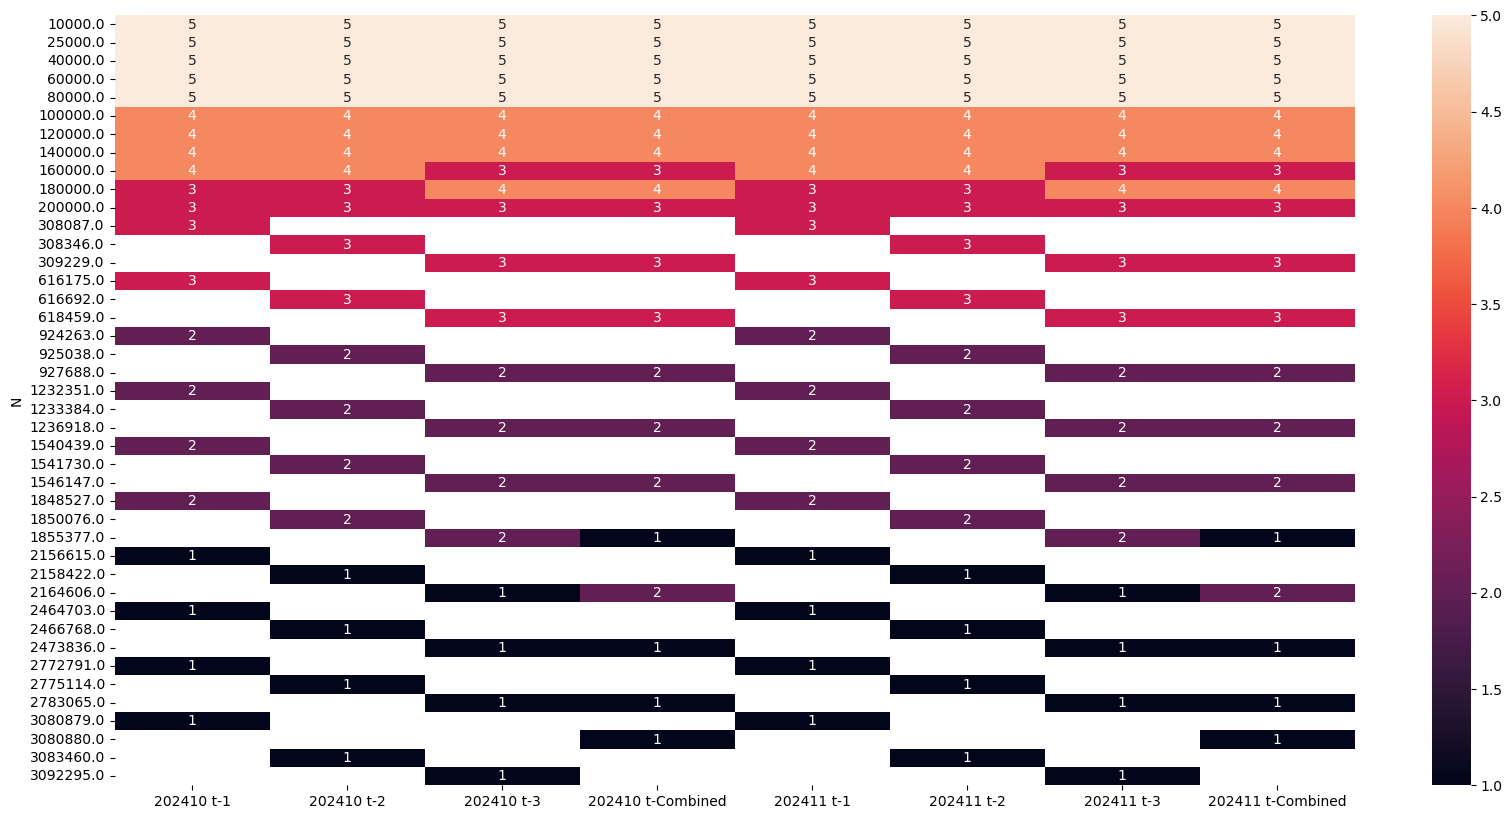

In [12]:
corte_modelo_360 = pd.DataFrame()
for ttt,save_backtesting in enumerate(backtesting_all):
    print(save_backtesting.keys())
    for t in  save_backtesting.keys():
        name = nametag_model[ttt]+' t-'+str(t)
        #if t == 1:
        df_tempo = save_backtesting[t]['modelo_360']
        df_tempo = df_tempo[['N','Aceleracion']].set_index('N').sort_index()
        df_tempo = df_tempo.rename(columns={'Aceleracion':name})
        corte_modelo_360 = pd.concat([corte_modelo_360,df_tempo],axis = 1)
corte_modelo_360 = corte_modelo_360.sort_index()
plt.figure(figsize=(20,10))
sns.heatmap(corte_modelo_360, annot = True, fmt = '0.1g')

In [13]:
base_calificada_nueva = catalog.load('base_calificada_nueva')

[12/20/24 16:48:17] INFO     Loading data from 'base_calificada_nueva' (ParquetDataSet)...      ]8;id=624288;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=955444;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [16]:
print(base_calificada_nueva['y_pred'].sum())
print(base_calificada_nueva['y_pred'].shape)

414479
(4144798,)


In [18]:
ttt = 1
obs_order = 414479.0*2
nametag_model[ttt]

'202411'

In [19]:
df_tempo = backtesting_all[ttt][1]['modelo_360']
if np.isnan(df_tempo.loc[0,'pend']) == True:
    df_tempo.loc[0,'pend'] = df_tempo.loc[0,'Aciertos'] /df_tempo.loc[0,'N']
df_temp = df_tempo[df_tempo['N']<=obs_order]
df_temp['Aceleracion'] = backtesting.deciles_func(df_temp['pend'], 5)
df_temp1 = df_tempo[df_tempo['N']>obs_order]
df_temp1.loc[df_temp1.index,'Aceleracion'] = 1
df_temp = pd.concat([df_temp,df_temp1], axis = 0)
df_temp

[12/20/24 16:49:37] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=766748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=280524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#203\203]8;;\

                    INFO     Cantidad de Deciles 5                                                     ]8;id=970617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=457921;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#233\233]8;;\

                    WARNING  /tmp/ipykernel_2127/1675877078.py:5: SettingWithCopyWarning:           ]8;id=176562;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=997204;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_temp['Aceleracion'] = backtesting.deciles_func(df_temp['pend'],                  
                             5)                                                                                    
                                                                                                                   

N  Aciertos      pend  Aceleracion
0     10000.0     139.0  0.013900          5.0
1     25000.0     320.0  0.012067          5.0
2     40000.0     442.0  0.008133          4.0
3     60000.0     603.0  0.008050          4.0
4     80000.0     786.0  0.009150          5.0
5    100000.0     888.0  0.005100          3.0
6    120000.0    1009.0  0.006050          3.0
7    140000.0    1112.0  0.005150          3.0
8    160000.0    1189.0  0.003850          2.0
9    180000.0    1257.0  0.003400          2.0
10   200000.0    1320.0  0.003150          1.0
11   308087.0    1542.0  0.002054          1.0
12   616175.0    1759.0  0.000704          1.0
13   924263.0    1837.0  0.000253          1.0
14  1232351.0    1891.0  0.000175          1.0
15  1540439.0    1927.0  0.000117          1.0
16  1848527.0    1958.0  0.000101          1.0
17  2156615.0    1966.0  0.000026          1.0
18  2464703.0    1966.0  0.000000          1.0
19  2772791.0    1967.0  0.000003          1.0
20  3080879.0    1967.0  0.000000          1.0

df_temp.to_parquet('s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/VIV/09-backtesting/curva_efec.parquet')

In [21]:
pd.read_parquet('s3://data-bbog-dev-sandbox-entity/casos-uso/fabrica-personas/VIV/09-backtesting/curva_efec.parquet')

N  Aciertos      pend  Aceleracion
0     10000.0     139.0  0.013900          5.0
1     25000.0     320.0  0.012067          5.0
2     40000.0     442.0  0.008133          4.0
3     60000.0     603.0  0.008050          4.0
4     80000.0     786.0  0.009150          5.0
5    100000.0     888.0  0.005100          3.0
6    120000.0    1009.0  0.006050          3.0
7    140000.0    1112.0  0.005150          3.0
8    160000.0    1189.0  0.003850          2.0
9    180000.0    1257.0  0.003400          2.0
10   200000.0    1320.0  0.003150          1.0
11   308087.0    1542.0  0.002054          1.0
12   616175.0    1759.0  0.000704          1.0
13   924263.0    1837.0  0.000253          1.0
14  1232351.0    1891.0  0.000175          1.0
15  1540439.0    1927.0  0.000117          1.0
16  1848527.0    1958.0  0.000101          1.0
17  2156615.0    1966.0  0.000026          1.0
18  2464703.0    1966.0  0.000000          1.0
19  2772791.0    1967.0  0.000003          1.0
20  3080879.0    1967.0  0.000000          1.0